## Step 1:
load CVS files and nomalize

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize, brentq


In [2]:
def _normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    cols = {c: str(c).strip().lower().replace(" ", "").replace("_", "") for c in df.columns}
    df = df.rename(columns=cols)

    rename_map = {}
    for c in df.columns:
        if c in ["eventid", "event_id", "id", "event"]:
            rename_map[c] = "eventid"
        elif c in ["classificationscore", "score", "classscore", "cls"]:
            rename_map[c] = "classificationscore"
        elif c in ["energy", "energykev", "e", "energ"]:
            rename_map[c] = "energy"
    df = df.rename(columns=rename_map)

    needed = {"eventid", "classificationscore", "energy"}
    if needed.issubset(df.columns):
        return df[["eventid", "classificationscore", "energy"]].copy()

    raise ValueError(f"Missing {needed - set(df.columns)}. Found columns: {list(df.columns)}")

def load_detector_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    # detect "no header" case (column names are numeric strings)
    all_numeric_colnames = True
    for c in df.columns:
        try:
            float(str(c))
        except:
            all_numeric_colnames = False
            break

    if all_numeric_colnames and len(df.columns) == 3:
        df = pd.read_csv(path, header=None, names=["eventid", "classificationscore", "energy"])
        return df[["eventid", "classificationscore", "energy"]].copy()

    return _normalize_columns(df)

def preview(df: pd.DataFrame, name: str, n: int = 5) -> None:
    # enforce types (nice formatting + fewer surprises later)
    out = df.copy()
    out["eventid"] = pd.to_numeric(out["eventid"], errors="coerce").astype("Int64")
    out["classificationscore"] = pd.to_numeric(out["classificationscore"], errors="coerce")
    out["energy"] = pd.to_numeric(out["energy"], errors="coerce")

    # quick stats
    missing = out.isna().sum()
    print(f"\n=== {name} ===")
    print(f"shape: {out.shape}")
    # print(f"missing: eventid={missing['eventid']}, score={missing['classificationscore']}, energy={missing['energy']}")
    print(
        "score range: "
        f"[{out['classificationscore'].min():.4f}, {out['classificationscore'].max():.4f}]   "
        "energy range: "
        f"[{out['energy'].min():.2f}, {out['energy'].max():.2f}] keV"
    )

    # show head as a clean table with fixed rounding
    # display(out.head(n).style.format({
    #     "eventid": "{:d}",
    #     "classificationscore": "{:.4f}",
    #     "energy": "{:.2f}"
    # }))

In [3]:
# ---- Load ----
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 120)
pd.set_option("display.precision", 4)

DATA_DIR = "data" 
PATH_A = f"{DATA_DIR}/DetectorA.csv"
PATH_B = f"{DATA_DIR}/DetectorB.csv"
PATH_C = f"{DATA_DIR}/DetectorC.csv"
PATH_T = f"{DATA_DIR}/DetectorTarget.csv"

A = load_detector_csv(PATH_A)
B = load_detector_csv(PATH_B)
C = load_detector_csv(PATH_C)
T = load_detector_csv(PATH_T)

preview(A, "Detector A")
preview(B, "Detector B")
preview(C, "Detector C")
preview(T, "Detector Target")


=== Detector A ===
shape: (40000, 3)
score range: [0.0000, 0.9720]   energy range: [1000.02, 3475.61] keV

=== Detector B ===
shape: (40000, 3)
score range: [0.0000, 0.9630]   energy range: [1000.01, 4998.51] keV

=== Detector C ===
shape: (40000, 3)
score range: [0.0000, 0.9710]   energy range: [1000.11, 3351.51] keV

=== Detector Target ===
shape: (4902, 3)
score range: [0.0000, 0.9630]   energy range: [1000.01, 4177.60] keV


In [4]:
# ============================================
# Define global energy binning based on data
# ============================================

# Combine energies from all detectors to see full range
all_E = np.concatenate([
    A["energy"].values,
    B["energy"].values,
    C["energy"].values,
    T["energy"].values,
])

E_data_min = float(np.nanmin(all_E))
E_data_max = float(np.nanmax(all_E))
print(f"Global data energy range: [{E_data_min:.2f}, {E_data_max:.2f}] keV")

# ---- Choose E_MIN, E_MAX, BINW ----
#   1) Look at the data range
#   2) Expand a bit to be safe
#   3) Use a reasonable bin width for ~1 keV resolution

# Pad by 50 keV on each side, but not below 0
E_MIN = max(0.0, E_data_min - 50.0)
E_MAX = E_data_max + 50.0

# Bin width
BINW = 0.5  # keV

# Construct common bin edges and centers (used for ALL detectors)
EDGES   = np.arange(E_MIN, E_MAX + BINW, BINW)
CENTERS = 0.5 * (EDGES[:-1] + EDGES[1:])

print(f"Analysis binning: E_MIN={E_MIN:.1f} keV, E_MAX={E_MAX:.1f} keV, BINW={BINW:.2f} keV")
print(f"Number of bins = {len(EDGES) - 1}")


Global data energy range: [1000.01, 4998.51] keV
Analysis binning: E_MIN=950.0 keV, E_MAX=5048.5 keV, BINW=0.50 keV
Number of bins = 8197


In [5]:
# ============================================
# Convert energies to counts and PDFs
# ============================================

def make_hist_counts_and_pdf(energies: np.ndarray,
                             edges: np.ndarray,
                             bin_width: float):
    """
    Returns:
      counts[k] = number of events in bin k
      pdf[k]    = normalized PDF per keV:
                    pdf[k] = counts[k] / (N_total * bin_width)
    such that:
                    sum(pdf[k] * bin_width) = 1
    """
    counts, _ = np.histogram(energies, bins=edges)
    counts = counts.astype(float)

    total = counts.sum()
    if total > 0:
        pdf = counts / (total * bin_width)
    else:
        pdf = np.zeros_like(counts)

    return counts, pdf


In [6]:
hA, pA = make_hist_counts_and_pdf(A["energy"].values, EDGES, BINW)
hB, pB = make_hist_counts_and_pdf(B["energy"].values, EDGES, BINW)
hC, pC = make_hist_counts_and_pdf(C["energy"].values, EDGES, BINW)
hT, pT = make_hist_counts_and_pdf(T["energy"].values, EDGES, BINW)

print("PDF integrals (should be ~1):")
print("A:", np.sum(pA * BINW))
print("B:", np.sum(pB * BINW))
print("C:", np.sum(pC * BINW))
print("T:", np.sum(pT * BINW))


PDF integrals (should be ~1):
A: 1.0
B: 1.0
C: 1.0
T: 1.0


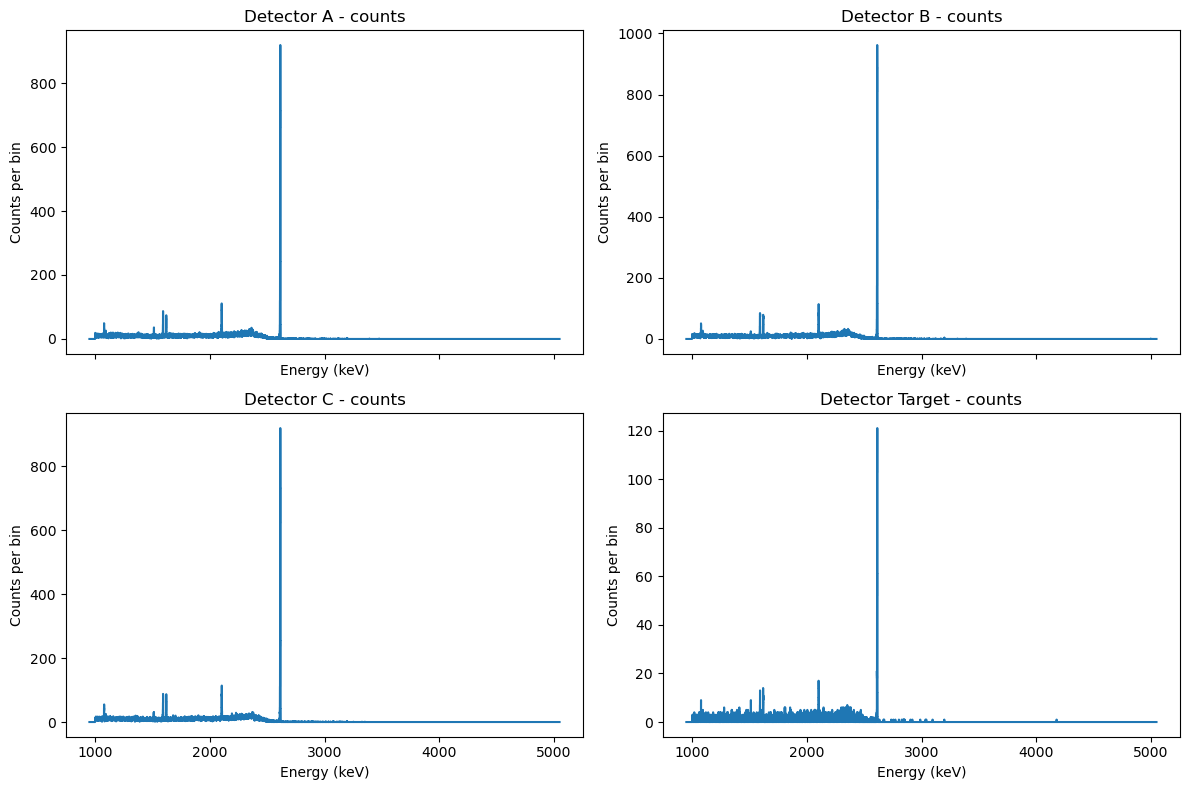

In [7]:
# ============================================
# Plot count distributions
# ============================================
def plot_count_spectra_grid(centers, counts_list, labels, xlim=None):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=False)
    axes = axes.ravel()

    for ax, counts, lab in zip(axes, counts_list, labels):
        ax.step(centers, counts, where="mid")
        ax.set_title(f"{lab} - counts")
        ax.set_xlabel("Energy (keV)")
        ax.set_ylabel("Counts per bin")
        if xlim is not None:
            ax.set_xlim(*xlim)

    plt.tight_layout()
    plt.show()

plot_count_spectra_grid(
    CENTERS,
    [hA, hB, hC, hT],
    ["Detector A", "Detector B", "Detector C", "Detector Target"],
    # xlim=(E_MIN, E_MAX)
)


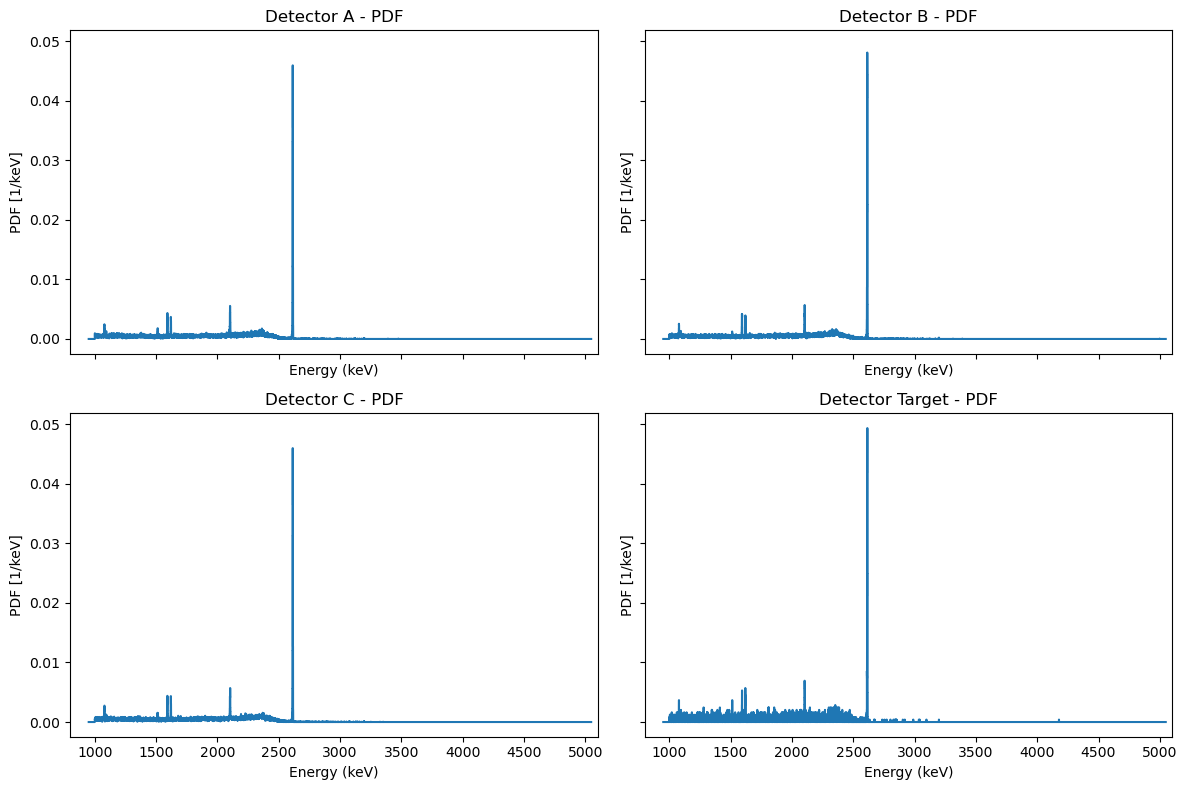

In [10]:
# ============================================
# Plot PDF distributions
# ============================================
def plot_pdf_spectra_grid(centers, pdfs_list, labels, xlim=None):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
    axes = axes.ravel()

    for ax, pdf, lab in zip(axes, pdfs_list, labels):
        ax.step(centers, pdf, where="mid")
        ax.set_title(f"{lab} - PDF")
        ax.set_xlabel("Energy (keV)")
        ax.set_ylabel("PDF [1/keV]")
        if xlim is not None:
            ax.set_xlim(*xlim)

    plt.tight_layout()
    plt.show()

plot_pdf_spectra_grid(
    CENTERS,
    [pA, pB, pC, pT],
    ["Detector A", "Detector B", "Detector C", "Detector Target"],
    xlim=(800, 5100)
)


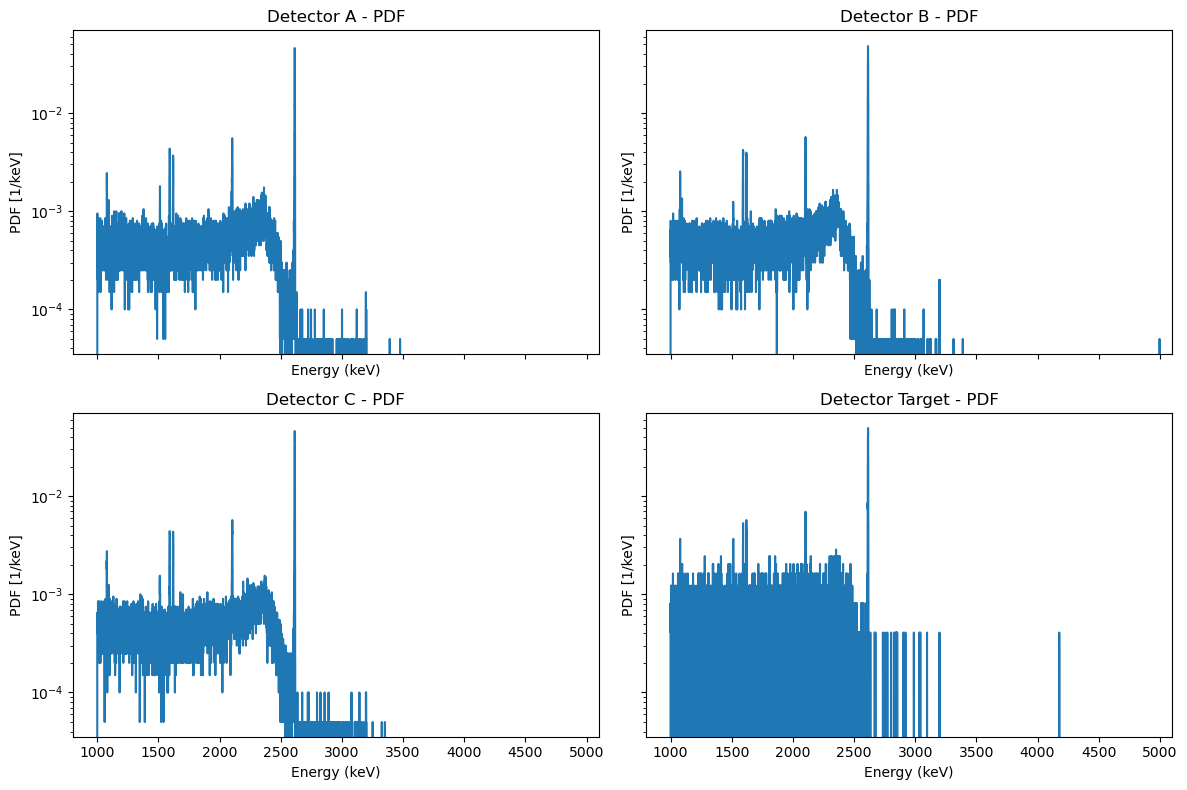

In [11]:
# ============================================
# Plot PDF distributions (log-scale)
# ============================================
def plot_pdf_spectra_grid(centers, pdfs_list, labels, xlim=None):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
    axes = axes.ravel()

    for ax, pdf, lab in zip(axes, pdfs_list, labels):
        ax.step(centers, pdf, where="mid")
        ax.set_yscale("log")
        ax.set_title(f"{lab} - PDF")
        ax.set_xlabel("Energy (keV)")
        ax.set_ylabel("PDF [1/keV]")
        if xlim is not None:
            ax.set_xlim(*xlim)

    plt.tight_layout()
    plt.show()

plot_pdf_spectra_grid(
    CENTERS,
    [pA, pB, pC, pT],
    ["Detector A", "Detector B", "Detector C", "Detector Target"],
    xlim=(800, 5100)
)


## Step 2:
Detector A

In [12]:
# ---------------- helpers (shared) ----------------
def window_mask_range(E: np.ndarray, lo: float, hi: float) -> np.ndarray:
    return (E >= lo) & (E <= hi)

def get_peak_and_sideband_scores(df: pd.DataFrame,
                                 center_keV: float,
                                 half_width: float,
                                 side_mult: float = 3.0):
    """
    peak: [c-hw, c+hw]
    sidebands: [c-side_mult*hw, c-hw] and [c+hw, c+side_mult*hw]
    """
    E = df["energy"].values
    S = df["classificationscore"].values

    lo_peak, hi_peak = center_keV - half_width, center_keV + half_width
    lo_sb1,  hi_sb1  = center_keV - side_mult*half_width, center_keV - half_width
    lo_sb2,  hi_sb2  = center_keV + half_width, center_keV + side_mult*half_width

    m_peak = window_mask_range(E, lo_peak, hi_peak)
    m_sb1  = window_mask_range(E, lo_sb1, hi_sb1)
    m_sb2  = window_mask_range(E, lo_sb2, hi_sb2)

    scores_peak = S[m_peak]
    scores_sb   = np.concatenate([S[m_sb1], S[m_sb2]])

    if len(scores_peak) == 0:
        raise ValueError("No events in PEAK window.")
    if len(scores_sb) == 0:
        raise ValueError("No events in SIDEBANDS. Increase side_mult or half_width.")

    # alpha = peak_width / sideband_total_width
    peak_w = (hi_peak - lo_peak)  # = 2*hw
    sb_w   = (hi_sb1 - lo_sb1) + (hi_sb2 - lo_sb2)  # = 2*(side_mult-1)*hw
    alpha = peak_w / sb_w

    return scores_peak, scores_sb, alpha

def net_pass_rate(scores_peak: np.ndarray,
                  scores_sb: np.ndarray,
                  alpha: float,
                  thr: float) -> float:
    """
    Baseline-subtracted pass fraction:
      net = (Npass_peak - alpha*Npass_sb) / (Npeak - alpha*Nsb)
    """
    Np = len(scores_peak)
    Ns = len(scores_sb)
    denom = Np - alpha*Ns
    if denom <= 0:
        return np.nan
    num = (scores_peak >= thr).sum() - alpha*(scores_sb >= thr).sum()
    return float(num / denom)


thr  TPR_A1592_net
0    0.0000         1.0000
1    0.0010         1.0073
2    0.0020         0.9976
3    0.0046         0.9976
4    0.0063         0.9951
..      ...            ...
241  0.8778         0.0170
242  0.8893         0.0146
243  0.9008         0.0109
244  0.9049         0.0061
245  0.9270         0.0024

[246 rows x 2 columns]

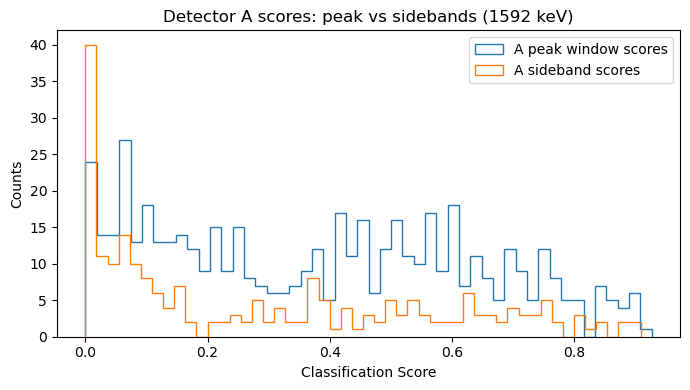

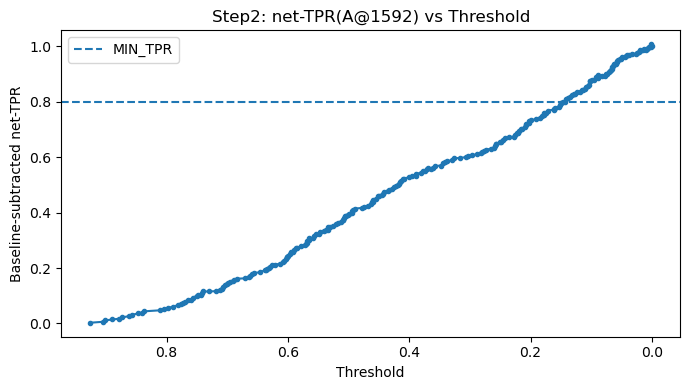

In [13]:
# ============================================================
# Step 2: Scan thresholds using Detector A @ 1592 keV (net-TPR)
# ============================================================
SIGNAL_KEV = 1592.0
PEAK_HALF_WIDTH = 3.0
SIDE_MULT = 3.0
N_THR = 250          # how many candidate thresholds to try
MIN_TPR = 0.80       # constraint for filtering later

# peak vs sideband scores in A
A_peak, A_sb, alphaA = get_peak_and_sideband_scores(
    A, SIGNAL_KEV, PEAK_HALF_WIDTH, side_mult=SIDE_MULT
)

# candidate threshold grid (use quantiles of A_peak for robust coverage)
qs = np.linspace(0.0, 1.0, N_THR)
thr_grid = np.quantile(A_peak, qs)
thr_grid = np.unique(thr_grid.astype(float))   # remove duplicates if any

rows2 = []
for thr in thr_grid:
    tpr_net = net_pass_rate(A_peak, A_sb, alphaA, thr)
    rows2.append({"thr": float(thr), "TPR_A1592_net": float(tpr_net)})

df_step2 = pd.DataFrame(rows2).sort_values("thr")
display(df_step2)

# plots for Step2
plt.figure(figsize=(7,4))
plt.hist(A_peak, bins=50, histtype="step", label="A peak window scores")
plt.hist(A_sb,   bins=50, histtype="step", label="A sideband scores")
plt.xlabel("Classification Score")
plt.ylabel("Counts")
plt.title("Detector A scores: peak vs sidebands (1592 keV)")
plt.legend()
plt.tight_layout()
plt.show()
plt.figure(figsize=(7,4))
plt.plot(df_step2["thr"], df_step2["TPR_A1592_net"], marker="o", markersize=3)
plt.axhline(MIN_TPR, linestyle="--", label="MIN_TPR")
plt.gca().invert_xaxis()
plt.xlabel("Threshold")
plt.ylabel("Baseline-subtracted net-TPR")
plt.title("Step2: net-TPR(A@1592) vs Threshold")
plt.legend()
plt.tight_layout()
plt.show()

## Step 3:
Detector B

thr  FPR_B2103_net
0    0.0000         1.0000
1    0.0010         0.9247
2    0.0020         0.8828
3    0.0046         0.8135
4    0.0063         0.7733
..      ...            ...
241  0.8778         0.0000
242  0.8893         0.0000
243  0.9008        -0.0009
244  0.9049        -0.0009
245  0.9270        -0.0009

[246 rows x 2 columns]

thr  TPR_A1592_net  FPR_B2103_net
0    0.0000         1.0000         1.0000
1    0.0010         1.0073         0.9247
2    0.0020         0.9976         0.8828
3    0.0046         0.9976         0.8135
4    0.0063         0.9951         0.7733
..      ...            ...            ...
241  0.8778         0.0170         0.0000
242  0.8893         0.0146         0.0000
243  0.9008         0.0109        -0.0009
244  0.9049         0.0061        -0.0009
245  0.9270         0.0024        -0.0009

[246 rows x 3 columns]

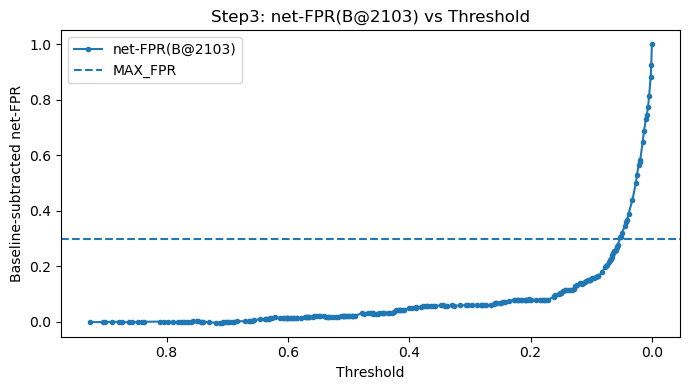

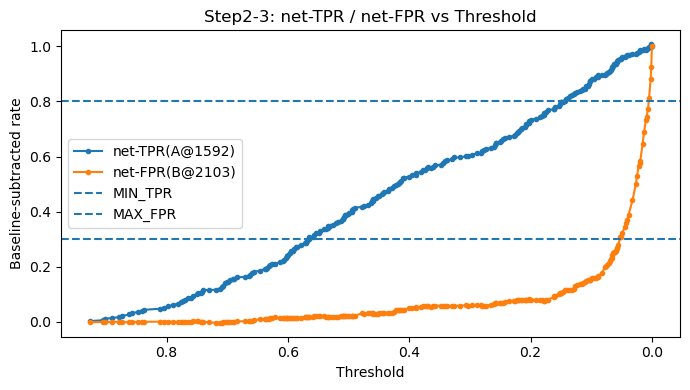

Kept 38/246 candidates after filtering.


thr  TPR_A1592_net  FPR_B2103_net
22  0.0560         0.9490         0.2780
23  0.0570         0.9465         0.2686
24  0.0580         0.9417         0.2686
25  0.0597         0.9368         0.2575
26  0.0616         0.9344         0.2541
27  0.0620         0.9344         0.2541
28  0.0640         0.9283         0.2489
29  0.0650         0.9247         0.2421
30  0.0660         0.9198         0.2327
31  0.0676         0.9149         0.2275
32  0.0694         0.9101         0.2216
33  0.0709         0.9064         0.2147
34  0.0736         0.9016         0.2062
35  0.0760         0.9004         0.2027
36  0.0778         0.8943         0.1976
37  0.0817         0.8943         0.1788
38  0.0880         0.8967         0.1668
39  0.0891         0.8870         0.1642
40  0.0920         0.8882         0.1600
41  0.0952         0.8797         0.1583
42  0.0980         0.8797         0.1574
43  0.1014         0.8748         0.1523
44  0.1020         0.8748         0.1523
45  0.1044         0.8615         0.1523
46  0.1058         0.8566         0.1514
47  0.1080         0.8542         0.1471
48  0.1110         0.8457         0.1446
49  0.1132         0.8433         0.1411
50  0.1160         0.8408         0.1369
51  0.1190         0.8360         0.1386
52  0.1230         0.8348         0.1343
53  0.1260         0.8287         0.1283
54  0.1290         0.8262         0.1198
55  0.1317         0.8226         0.1155
56  0.1358         0.8177         0.1138
57  0.1379         0.8129         0.1146
58  0.1410         0.8080         0.1163
59  0.1433         0.8007         0.1138

In [14]:
# ============================================================
# Step 3: Evaluate background using Detector B @ 2103 keV (net-FPR)
#         (apply the same thresholds from Step 2)
# ============================================================
BKG_KEV = 2103.0
MAX_FPR = 0.30

# peak vs sideband scores in B
B_peak, B_sb, alphaB = get_peak_and_sideband_scores(
    B, BKG_KEV, PEAK_HALF_WIDTH, side_mult=SIDE_MULT
)

# compute net-FPR for each threshold from Step2
rows3 = []
for thr in df_step2["thr"].values:
    fpr_net = net_pass_rate(B_peak, B_sb, alphaB, float(thr))
    rows3.append({"thr": float(thr), "FPR_B2103_net": float(fpr_net)})

df_step3 = pd.DataFrame(rows3).sort_values("thr")
display(df_step3)

# merge Step2 + Step3 => df_cutscan (for filtering)
df_cutscan = df_step2.merge(df_step3, on="thr", how="inner").sort_values("thr")
display(df_cutscan)

# plot for Step3 + combined
plt.figure(figsize=(7,4))
plt.plot(df_cutscan["thr"], df_cutscan["FPR_B2103_net"], marker="o", markersize=3, label="net-FPR(B@2103)")
plt.axhline(MAX_FPR, linestyle="--", label="MAX_FPR")
plt.gca().invert_xaxis()
plt.xlabel("Threshold")
plt.ylabel("Baseline-subtracted net-FPR")
plt.title("Step3: net-FPR(B@2103) vs Threshold")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(df_cutscan["thr"], df_cutscan["TPR_A1592_net"], marker="o", markersize=3, label="net-TPR(A@1592)")
plt.plot(df_cutscan["thr"], df_cutscan["FPR_B2103_net"], marker="o", markersize=3, label="net-FPR(B@2103)")
plt.axhline(MIN_TPR, linestyle="--", label="MIN_TPR")
plt.axhline(MAX_FPR, linestyle="--", label="MAX_FPR")
plt.gca().invert_xaxis()
plt.xlabel("Threshold")
plt.ylabel("Baseline-subtracted rate")
plt.title("Step2-3: net-TPR / net-FPR vs Threshold")
plt.legend()
plt.tight_layout()
plt.show()

# filtering
df_filt = df_cutscan[
    (df_cutscan["TPR_A1592_net"] >= MIN_TPR) &
    (df_cutscan["FPR_B2103_net"] <= MAX_FPR)
].copy().sort_values("thr")

print(f"Kept {len(df_filt)}/{len(df_cutscan)} candidates after filtering.")
display(df_filt)

THR_GRID_F = df_filt["thr"].to_numpy()


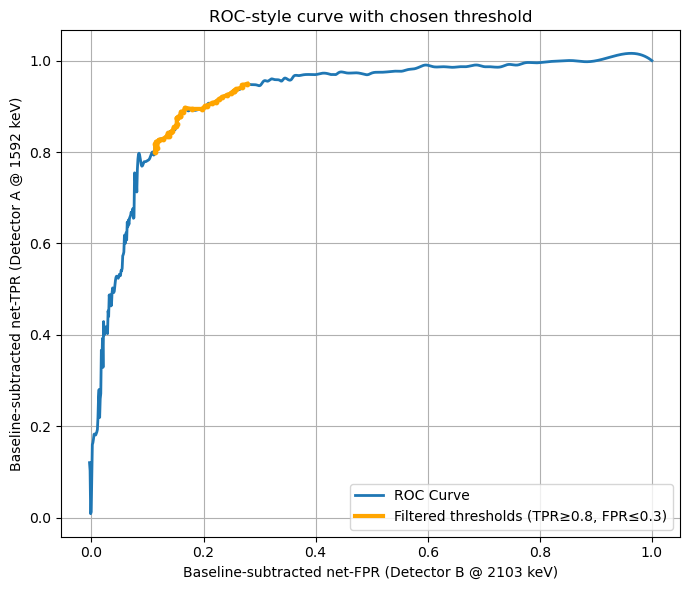

In [15]:
# ============================================
# Plot ROC curve: net-TPR vs net-FPR; 
# ============================================

from scipy.interpolate import make_interp_spline

# ---------------------------------
# Dense, uniform threshold grid
# ---------------------------------
thr_grid_smooth = np.linspace(0.0, 1.0, 2000)

tpr_list = []
fpr_list = []

for thr in thr_grid_smooth:
    tpr_list.append(net_pass_rate(A_peak, A_sb, alphaA, thr))
    fpr_list.append(net_pass_rate(B_peak, B_sb, alphaB, thr))

tpr_arr = np.array(tpr_list, dtype=float)
fpr_arr = np.array(fpr_list, dtype=float)

# Remove NaNs
mask = (~np.isnan(tpr_arr)) & (~np.isnan(fpr_arr))
tpr_arr = tpr_arr[mask]
fpr_arr = fpr_arr[mask]
thr_grid_smooth = thr_grid_smooth[mask]

# Sort by FPR for a nice monotonic ROC
order = np.argsort(fpr_arr)
fpr_sorted = fpr_arr[order]
tpr_sorted = tpr_arr[order]
thr_sorted = thr_grid_smooth[order]

# Remove duplicate FPR values (keep first occurrence)
unique_mask = np.append([True], np.diff(fpr_sorted) != 0)
fpr_unique = fpr_sorted[unique_mask]
tpr_unique = tpr_sorted[unique_mask]

# Create a smooth spline interpolation
x_new = np.linspace(fpr_sorted.min(), fpr_sorted.max(), 1000)
# tpr_smooth = make_interp_spline(fpr_sorted, tpr_sorted, k=3)(x_new)
tpr_smooth = make_interp_spline(fpr_unique, tpr_unique, k=3)(x_new)

df_sel = df_filt.dropna(subset=["TPR_A1592_net", "FPR_B2103_net"]).copy()

# pick one “best” threshold (maximize Youden’s J = TPR−FPR among filtered candidates)
if not df_sel.empty:
    # Use Youden’s J to choose the optimal threshold, after applying the constraints.
    df_sel["J"] = df_sel["TPR_A1592_net"] - df_sel["FPR_B2103_net"]
    best_row = df_sel.loc[df_sel["J"].idxmax()]
    thr_star = float(best_row["thr"])
    tpr_star = float(best_row["TPR_A1592_net"])
    fpr_star = float(best_row["FPR_B2103_net"])
    # print(f"Chosen threshold thr* = {thr_star:.3f}")
    # print(f"  net-TPR(t*) = {tpr_star:.3f}")
    # print(f"  net-FPR(t*) = {fpr_star:.3f}")
else:
    thr_star = None
    print("WARNING: df_filt is empty; no threshold passed the TPR/FPR cuts.")


plt.figure(figsize=(7,6))

# Smooth ROC curve
plt.plot(x_new, tpr_smooth, '-', linewidth=2, label="ROC Curve")

# Highlight the region of the ROC curve that corresponds to thresholds that passed filters
if not df_filt.empty:
    # Extract filtered points
    fpr_filt = df_filt["FPR_B2103_net"].values
    tpr_filt = df_filt["TPR_A1592_net"].values

    # Sort by FPR for plotting
    order_f = np.argsort(fpr_filt)
    fpr_filt_sorted = fpr_filt[order_f]
    tpr_filt_sorted = tpr_filt[order_f]

    # Plot highlighted segment
    plt.plot(
        fpr_filt_sorted,
        tpr_filt_sorted,
        color="orange",
        linewidth=3,
        zorder=3,
        label="Filtered thresholds (TPR≥0.8, FPR≤0.3)"
    )

    # Optional scatter to make them pop visually
    plt.scatter(
        fpr_filt,
        tpr_filt,
        color="orange",
        s=10,
        zorder=6
    )

# Highlight chosen threshold if it exists
# if thr_star is not None:
#     # Red chosen point (always higher zorder)
#     plt.scatter([fpr_star], [tpr_star], color='red', s=80, zorder=10, label=f"Chosen thr* = {thr_star:.3f}")
    
#     # Annotate with text box
#     txt = (f"thr* = {thr_star:.3f}\n"
#            f"TPR* = {tpr_star:.3f}\n"
#            f"FPR* = {fpr_star:.3f}")
#     plt.annotate(
#         txt,
#         xy=(fpr_star, tpr_star),
#         xytext=(fpr_star + 0.02, tpr_star - 0.05),
#         arrowprops=dict(arrowstyle="->", color="red"),
#         fontsize=10,
#         zorder=10,
#         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.9),
#         ha='left', va='top'  # anchor so the box stays below-right
#     )


plt.xlabel("Baseline-subtracted net-FPR (Detector B @ 2103 keV)")
plt.ylabel("Baseline-subtracted net-TPR (Detector A @ 1592 keV)")
plt.title("ROC-style curve with chosen threshold")
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()



## Step 4:


In [13]:
def gaussian_bin_probs(edges: np.ndarray, mu: float, sigma: float) -> np.ndarray:
    cdf_hi = norm.cdf(edges[1:], loc=mu, scale=sigma)
    cdf_lo = norm.cdf(edges[:-1], loc=mu, scale=sigma)
    p = np.maximum(cdf_hi - cdf_lo, 0.0)
    s = p.sum()
    if s <= 0:
        raise ValueError("Gaussian template has zero mass in the chosen range/bins.")
    return p / s

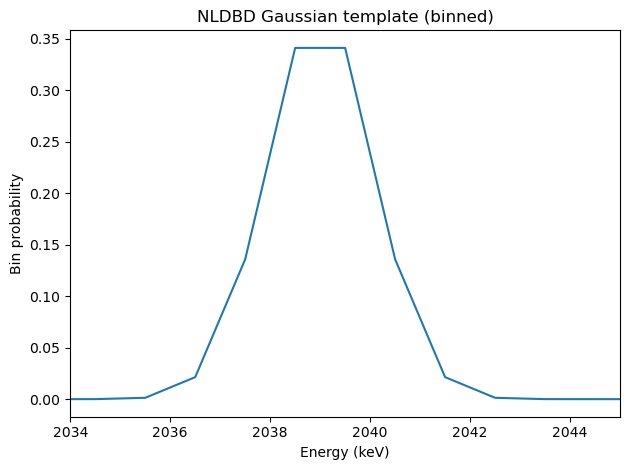

In [14]:
# ==========================================================
# Step 4: Build NLDBD PDF as Gaussian at 2039 keV (width ±1 keV)
# ==========================================================
NLDBD_KEV = 2039.0
NLDBD_SIGMA = 1.0   # interpret "±1 keV" as sigma=1 keV (state this in report)

EMIN, EMAX, BINW = 500.0, 3000.0, 1.0
edges = np.arange(EMIN, EMAX + BINW, BINW)
centers = 0.5 * (edges[:-1] + edges[1:])

pN = gaussian_bin_probs(edges, NLDBD_KEV, NLDBD_SIGMA)

plt.figure()
plt.plot(centers, pN)
plt.xlim(2034, 2045)
plt.xlabel("Energy (keV)")
plt.ylabel("Bin probability")
plt.title("NLDBD Gaussian template (binned)")
plt.tight_layout()
plt.show()


## Step 5:

In [10]:
# ==========================================================
# Step 5: Functions (apply cut -> build templates -> plots comparison with/without cut)
# ==========================================================
def apply_cut(df: pd.DataFrame, thr: float) -> pd.DataFrame:
    """Keep events with classificationscore >= thr."""
    return df[df["classificationscore"] >= thr].copy()

def make_hist_counts(energies: np.ndarray, edges: np.ndarray) -> np.ndarray:
    """Binned counts (float) for a given energy array and bin edges."""
    counts, _ = np.histogram(energies, bins=edges)
    return counts.astype(float)

def make_pdf_from_counts(counts: np.ndarray) -> np.ndarray:
    """Normalize counts into a probability vector (sums to 1)."""
    s = float(np.sum(counts))
    if s <= 0:
        raise ValueError("Empty histogram; check energy range / cut threshold.")
    return counts / s

def build_templates_for_thr(
    A: pd.DataFrame,
    B: pd.DataFrame,
    C: pd.DataFrame,
    T: pd.DataFrame,
    thr: float,
    edges: np.ndarray,
    *,
    return_cut_dfs: bool = False
):
    """
    Apply cut at threshold thr, then build:
      y  : Target histogram counts (NOT normalized)
      pA : normalized template from A after cut
      pB : normalized template from B after cut
      pC : normalized template from C after cut

    If return_cut_dfs=True, also returns (A2,B2,C2,T2).
    """
    # apply cut
    A2 = apply_cut(A, thr)
    B2 = apply_cut(B, thr)
    C2 = apply_cut(C, thr)
    T2 = apply_cut(T, thr)

    # target counts
    y = make_hist_counts(T2["energy"].values, edges)

    # templates
    pA = make_pdf_from_counts(make_hist_counts(A2["energy"].values, edges))
    pB = make_pdf_from_counts(make_hist_counts(B2["energy"].values, edges))
    pC = make_pdf_from_counts(make_hist_counts(C2["energy"].values, edges))

    if return_cut_dfs:
        return y, pA, pB, pC, A2, B2, C2, T2
    return y, pA, pB, pC

# ---------------- plotting helpers ----------------

def plot_before_after_grid(dfs_before, dfs_after, labels, bins=450, xlim=(1000, 3500)):
    """
    2x2 grid. Each panel overlays before cut vs after cut energy spectra.
    dfs_before/after: list of 4 dataframes [A,B,C,T] and [A2,B2,C2,T2]
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=False)
    axes = axes.ravel()

    for ax, df0, df1, lab in zip(axes, dfs_before, dfs_after, labels):
        ax.hist(df0["energy"], bins=bins, range=xlim, histtype="step", label="before cut")
        ax.hist(df1["energy"], bins=bins, range=xlim, histtype="step", label="after cut")
        ax.set_title(lab)
        ax.set_xlim(*xlim)
        ax.set_xlabel("Energy (keV)")
        ax.set_ylabel("Counts")
        ax.legend()

    plt.tight_layout()
    plt.show()

def plot_templates_roi(centers, y, pA, pB, pC, pN, roi=(1900, 2200)):
    """
    Quick ROI view:
      - pA/pB/pC/pN shapes
      - y counts
    """
    lo, hi = roi

    plt.figure()
    plt.plot(centers, pA, label="pA")
    plt.plot(centers, pB, label="pB")
    plt.plot(centers, pC, label="pC")
    plt.plot(centers, pN, label="pNLDBD")
    plt.xlim(lo, hi)
    plt.xlabel("Energy (keV)")
    plt.ylabel("PDF (shape)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.step(centers, y, where="mid")
    plt.xlim(lo, hi)
    plt.xlabel("Energy (keV)")
    plt.ylabel("Target counts / bin")
    plt.title("Target histogram after cut")
    plt.tight_layout()
    plt.show()


In [11]:
# ==========================================================
# Step 5: Build (y, pA, pB, pC) for each candidate threshold
# ==========================================================
templates_by_thr = {}   # thr -> dict(y,pA,pB,pC, sizes...)
rows = []

for thr_i in THR_GRID_F:
    try:
        y, pA, pB, pC, A2, B2, C2, T2 = build_templates_for_thr(
            A, B, C, T, float(thr_i), edges, return_cut_dfs=True
        )

        templates_by_thr[float(thr_i)] = {
            "y": y,
            "pA": pA, "pB": pB, "pC": pC,
            "A2_n": len(A2), "B2_n": len(B2), "C2_n": len(C2), "T2_n": len(T2),
            "y_sum": float(np.sum(y)),
        }

        rows.append({
            "thr": float(thr_i),
            "A2_n": len(A2), "B2_n": len(B2), "C2_n": len(C2), "T2_n": len(T2),
            "Target_counts_sum": float(np.sum(y)),
        })

    except Exception as e:
        rows.append({
            "thr": float(thr_i),
            "error": str(e),
        })

df_step5 = pd.DataFrame(rows).sort_values("thr")
display(df_step5)
print("Built templates for", sum("error" not in r for r in rows), "thresholds.")



thr   A2_n   B2_n   C2_n  T2_n  Target_counts_sum
0   0.0560  23734  23758  23614  2899             2898.0
1   0.0570  23544  23585  23465  2871             2870.0
2   0.0580  23393  23441  23335  2856             2855.0
3   0.0597  23089  23130  23028  2826             2825.0
4   0.0616  22801  22836  22724  2793             2793.0
5   0.0620  22801  22836  22724  2793             2793.0
6   0.0640  22506  22544  22450  2757             2757.0
7   0.0650  22374  22398  22312  2742             2742.0
8   0.0660  22215  22271  22197  2727             2727.0
9   0.0676  21979  22001  21936  2711             2711.0
10  0.0694  21722  21727  21681  2686             2686.0
11  0.0709  21592  21607  21568  2669             2669.0
12  0.0736  21189  21236  21222  2625             2625.0
13  0.0760  20954  21015  21014  2593             2593.0
14  0.0778  20729  20804  20786  2562             2562.0
15  0.0817  20268  20391  20341  2504             2504.0
16  0.0880  19681  19803  19768  2428             2428.0
17  0.0891  19492  19621  19595  2405             2405.0
18  0.0920  19314  19420  19393  2380             2380.0
19  0.0952  18959  19059  19036  2339             2339.0
20  0.0980  18786  18891  18853  2311             2311.0
21  0.1014  18469  18534  18523  2267             2267.0
22  0.1020  18469  18534  18523  2267             2267.0
23  0.1044  18219  18317  18313  2247             2247.0
24  0.1058  18116  18236  18236  2239             2239.0
25  0.1080  17959  18065  18078  2217             2217.0
26  0.1110  17647  17750  17794  2185             2185.0
27  0.1132  17495  17630  17658  2163             2163.0
28  0.1160  17346  17476  17520  2142             2142.0
29  0.1190  17129  17262  17322  2116             2116.0
30  0.1230  16866  17000  17051  2083             2083.0
31  0.1260  16666  16810  16889  2059             2059.0
32  0.1290  16485  16630  16701  2036             2036.0
33  0.1317  16294  16456  16498  2011             2011.0
34  0.1358  16077  16240  16288  1978             1978.0
35  0.1379  15985  16134  16175  1963             1963.0
36  0.1410  15836  15975  16004  1946             1946.0
37  0.1433  15686  15830  15858  1923             1923.0

Built templates for 38 thresholds.


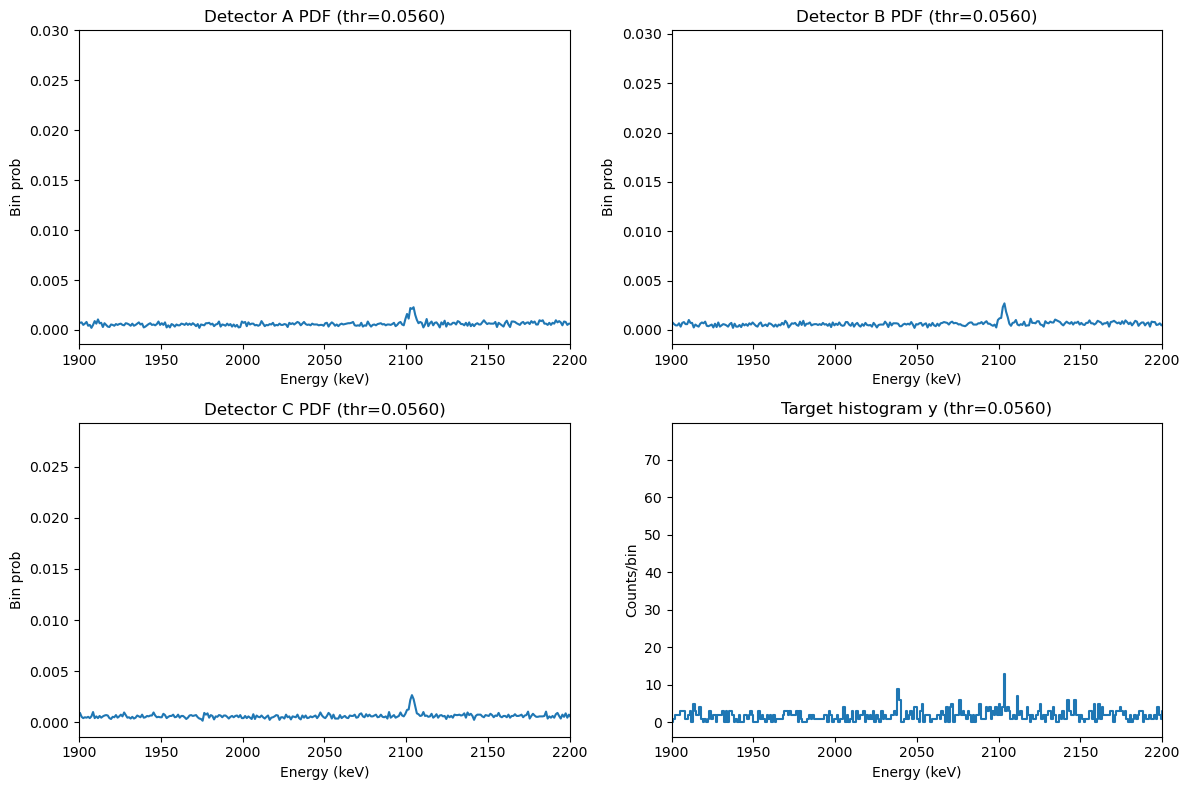

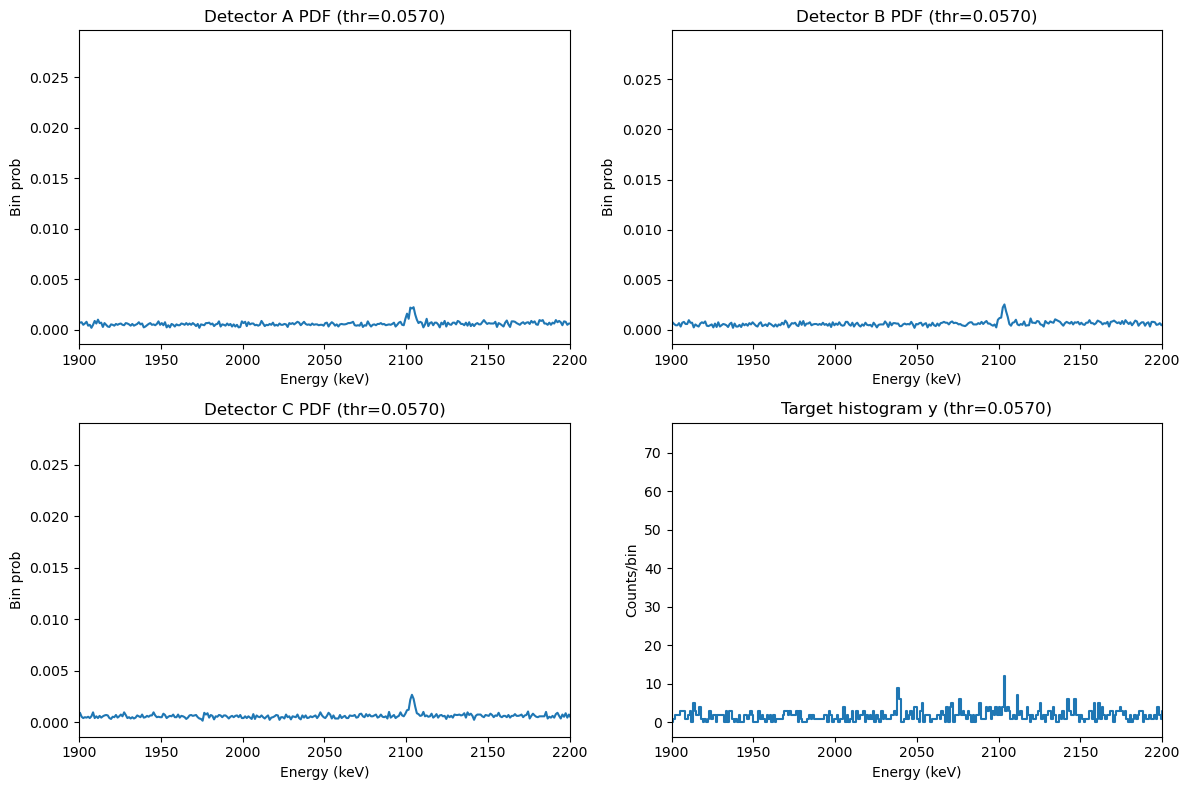

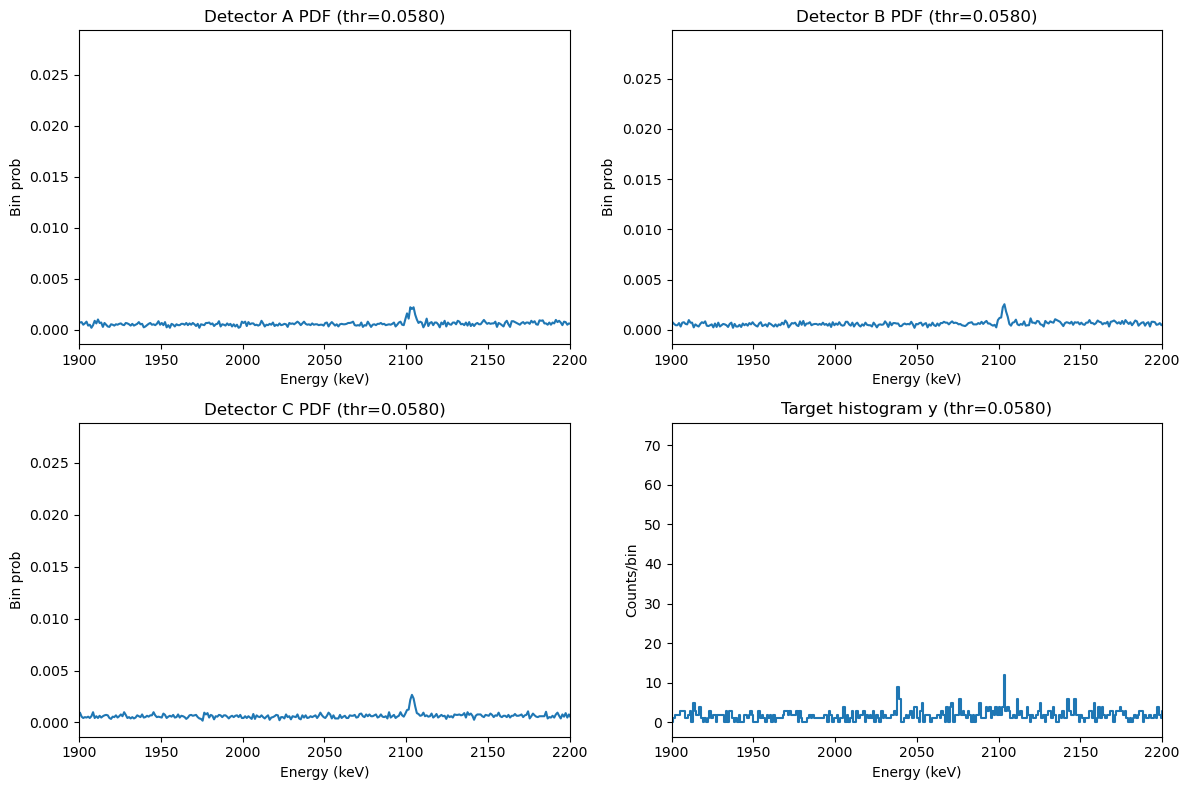

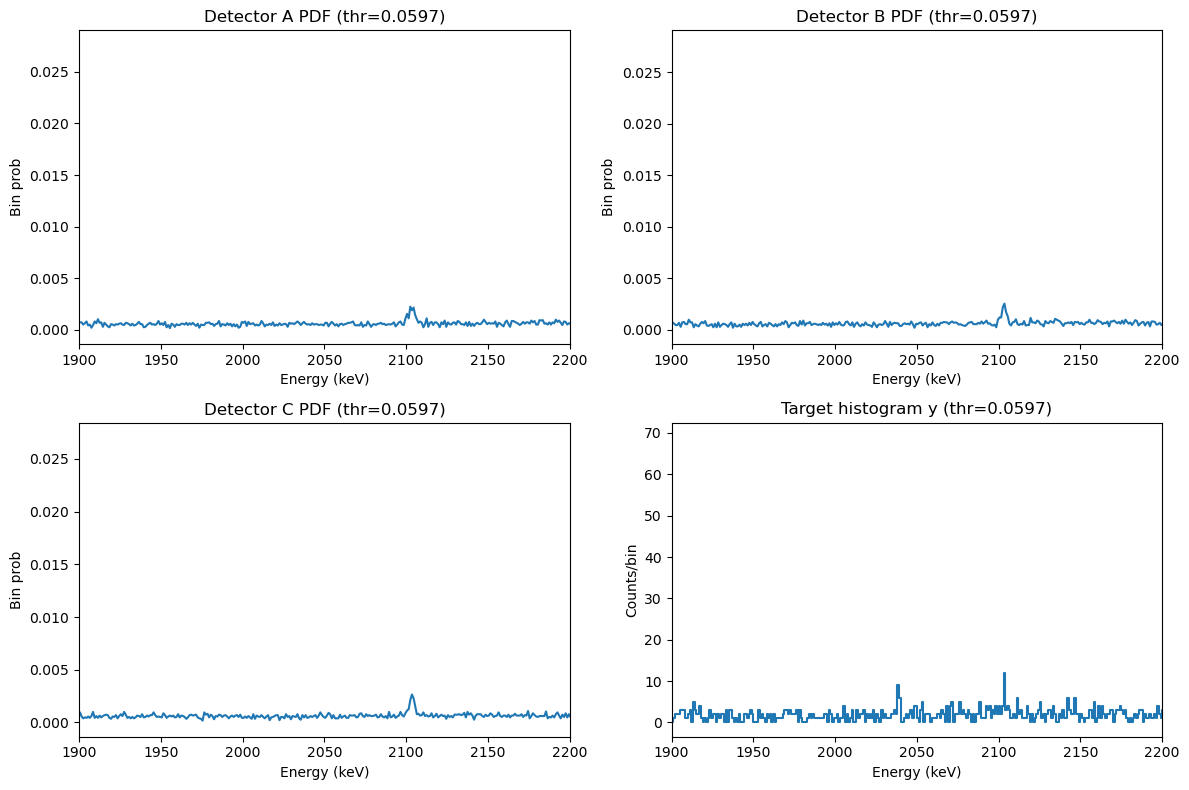

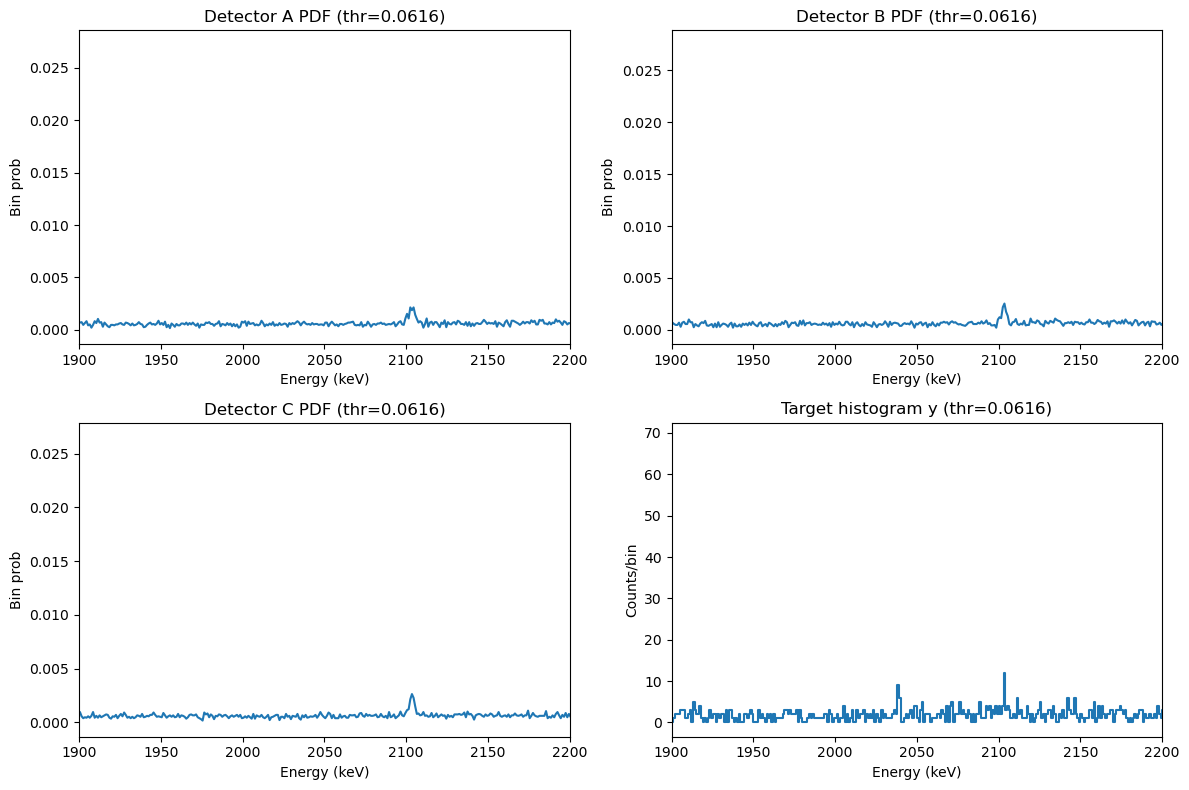

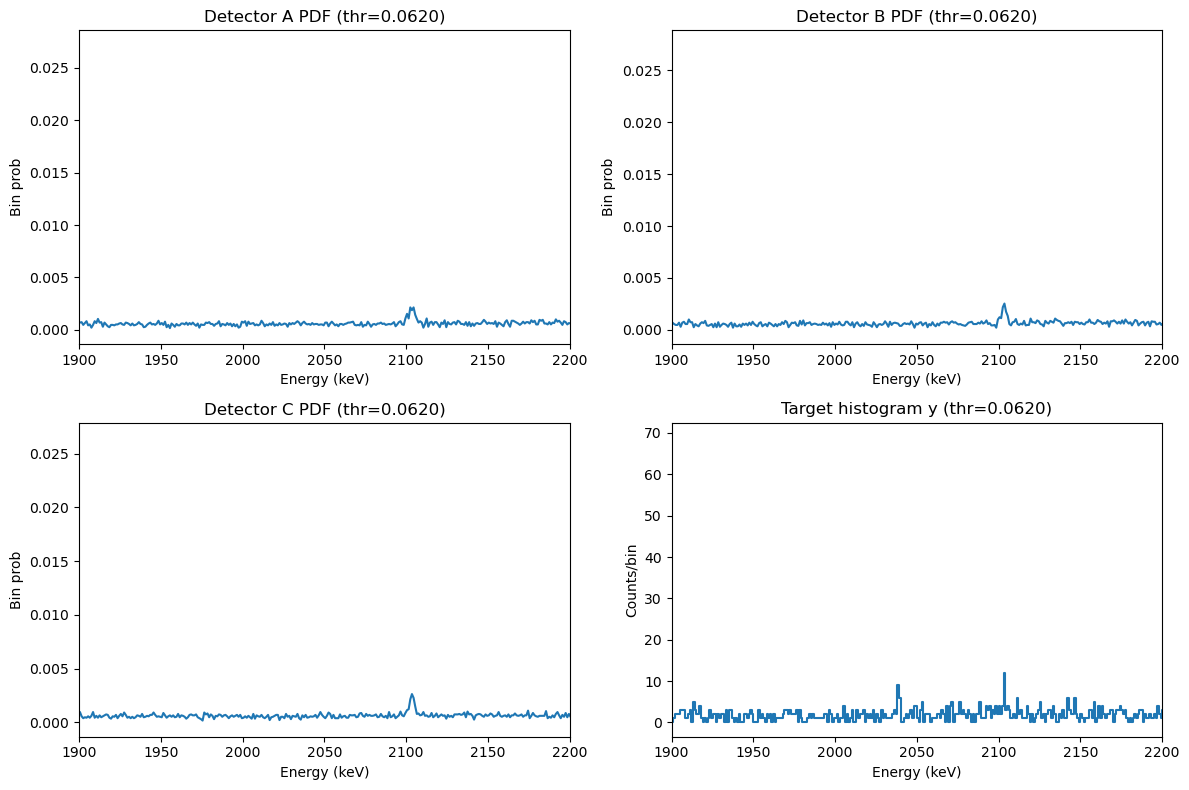

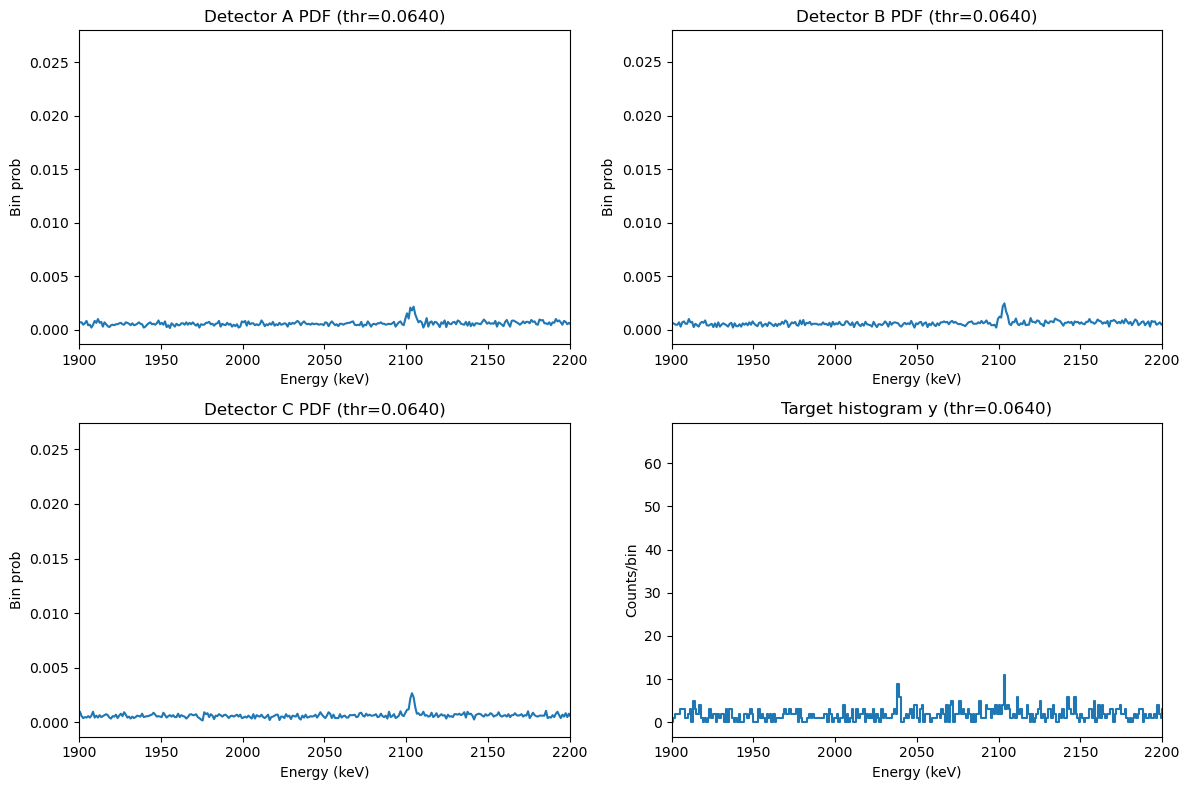

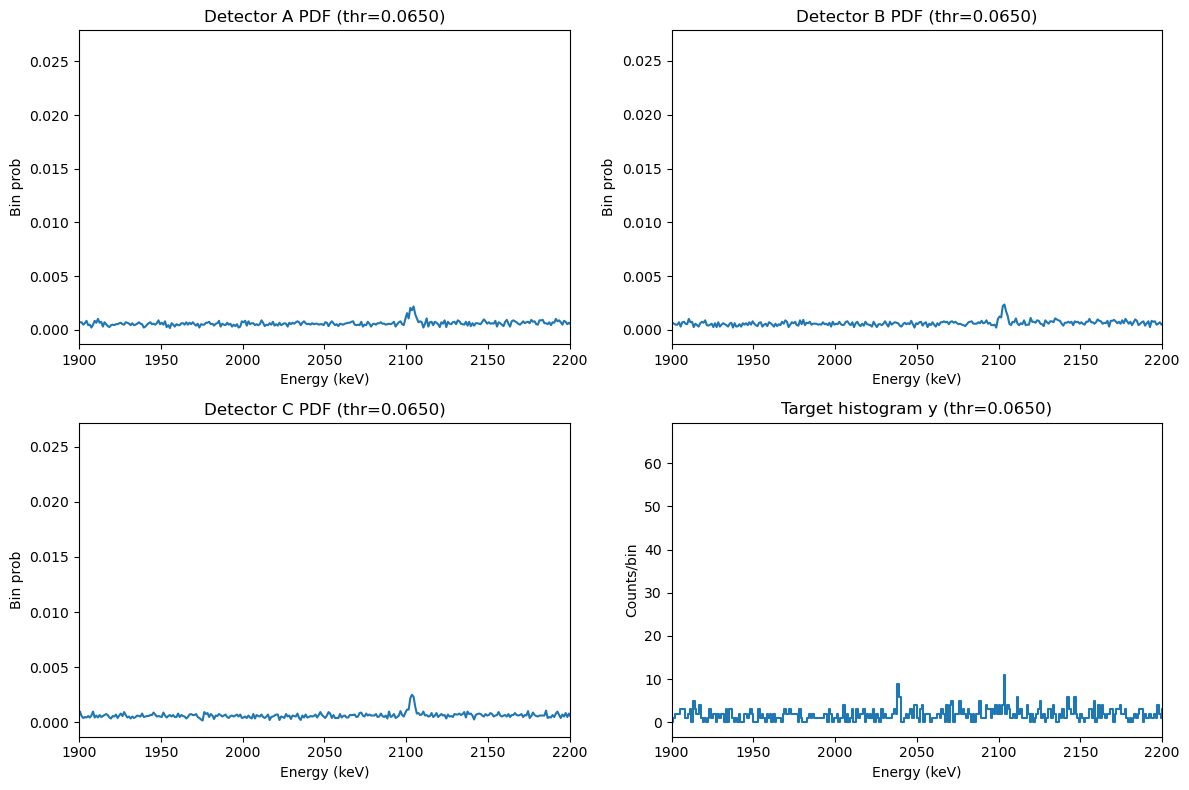

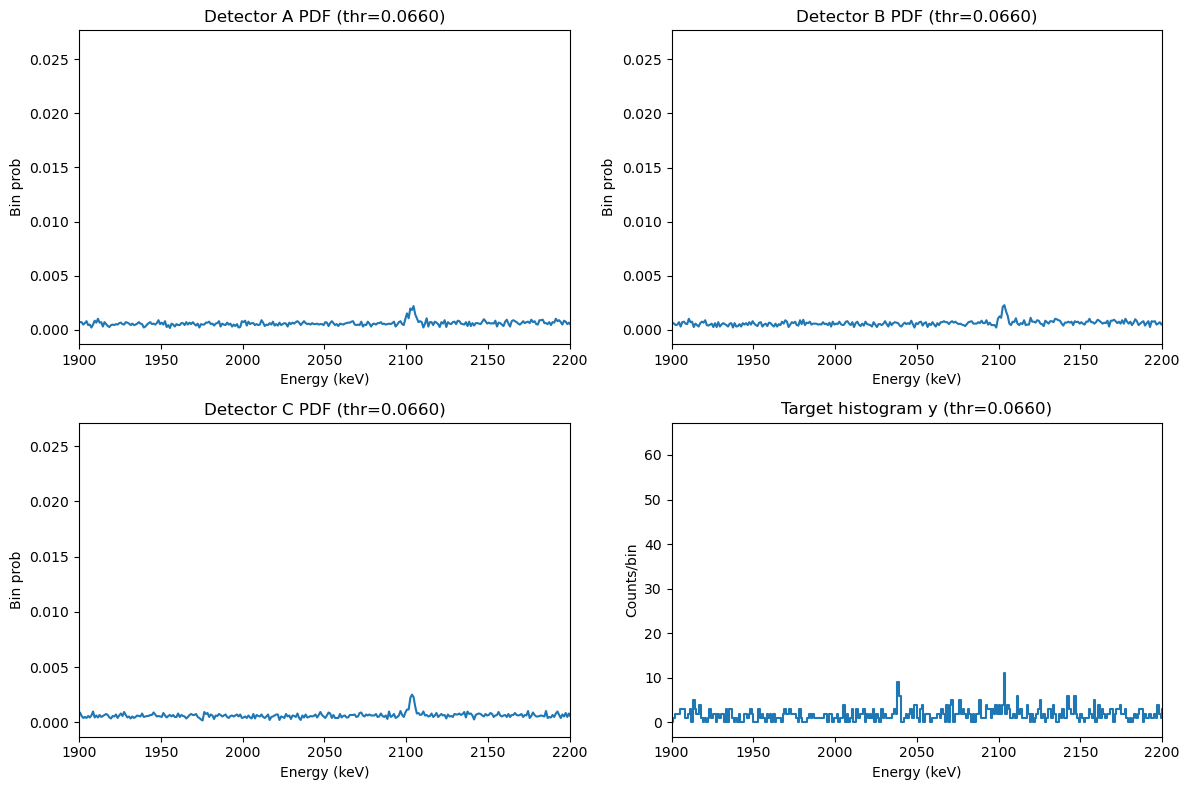

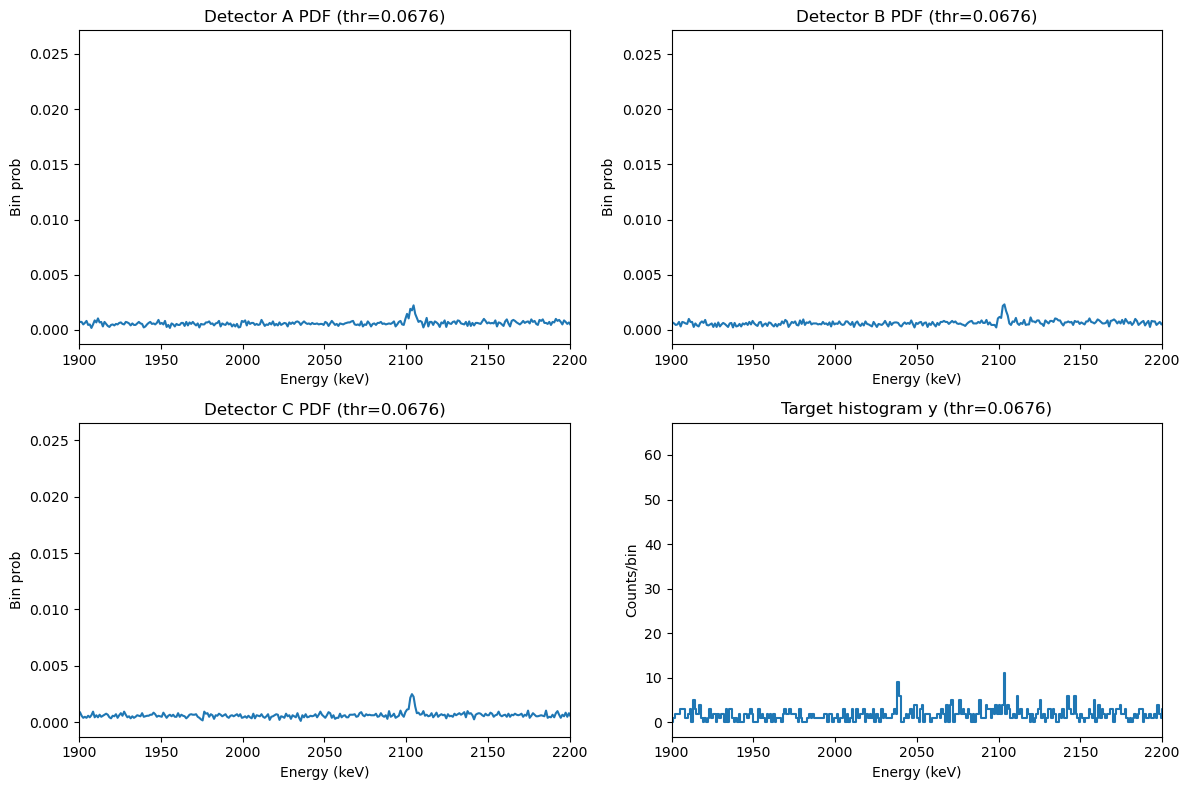

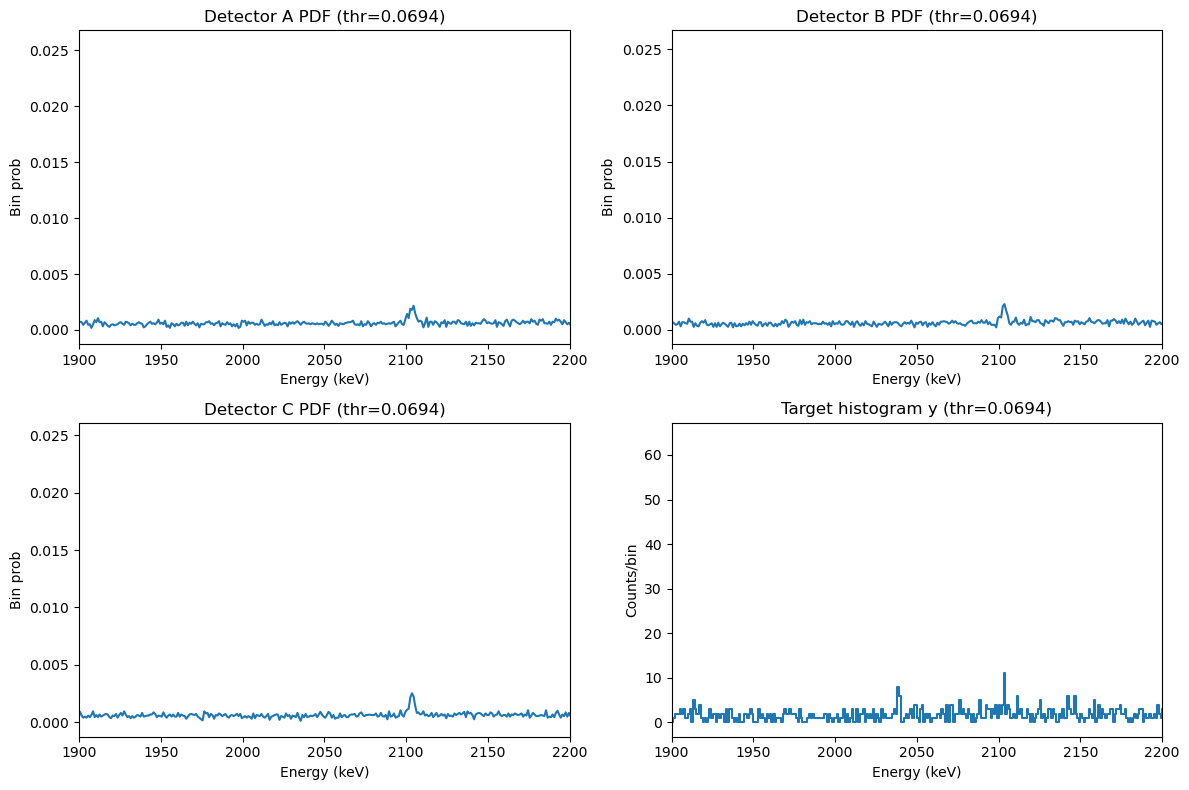

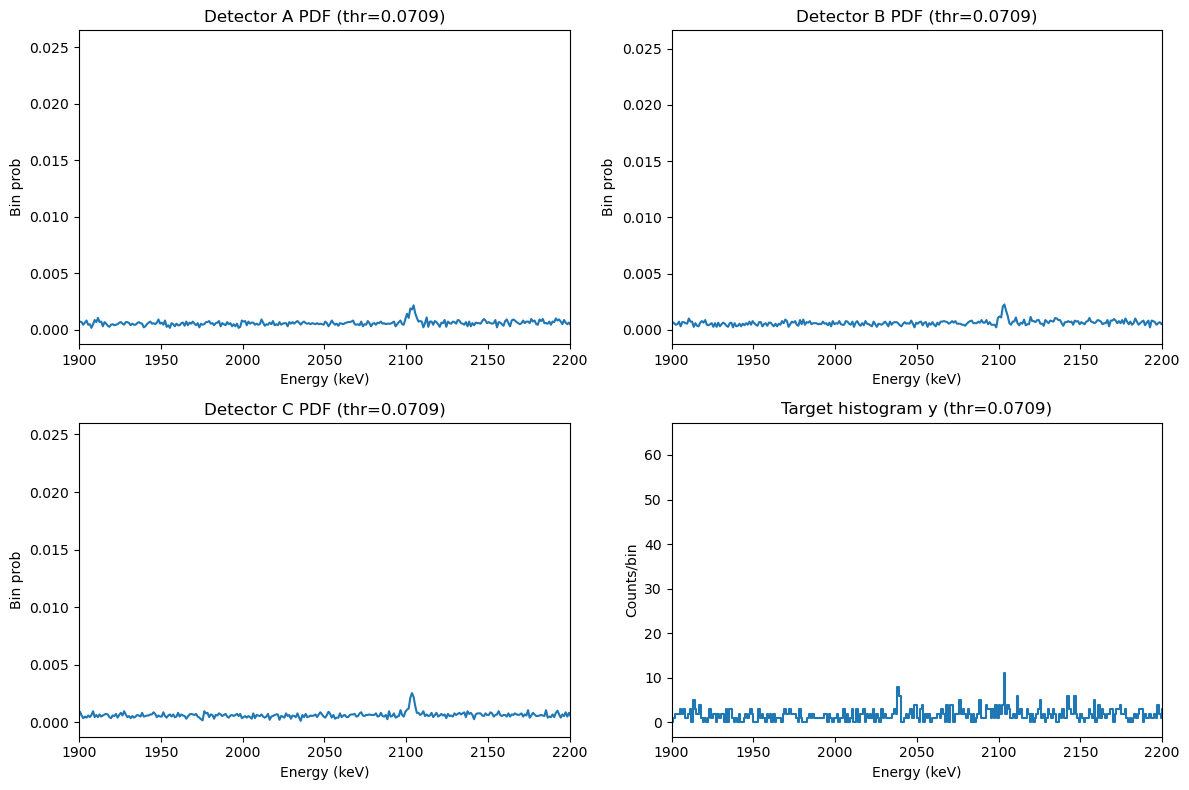

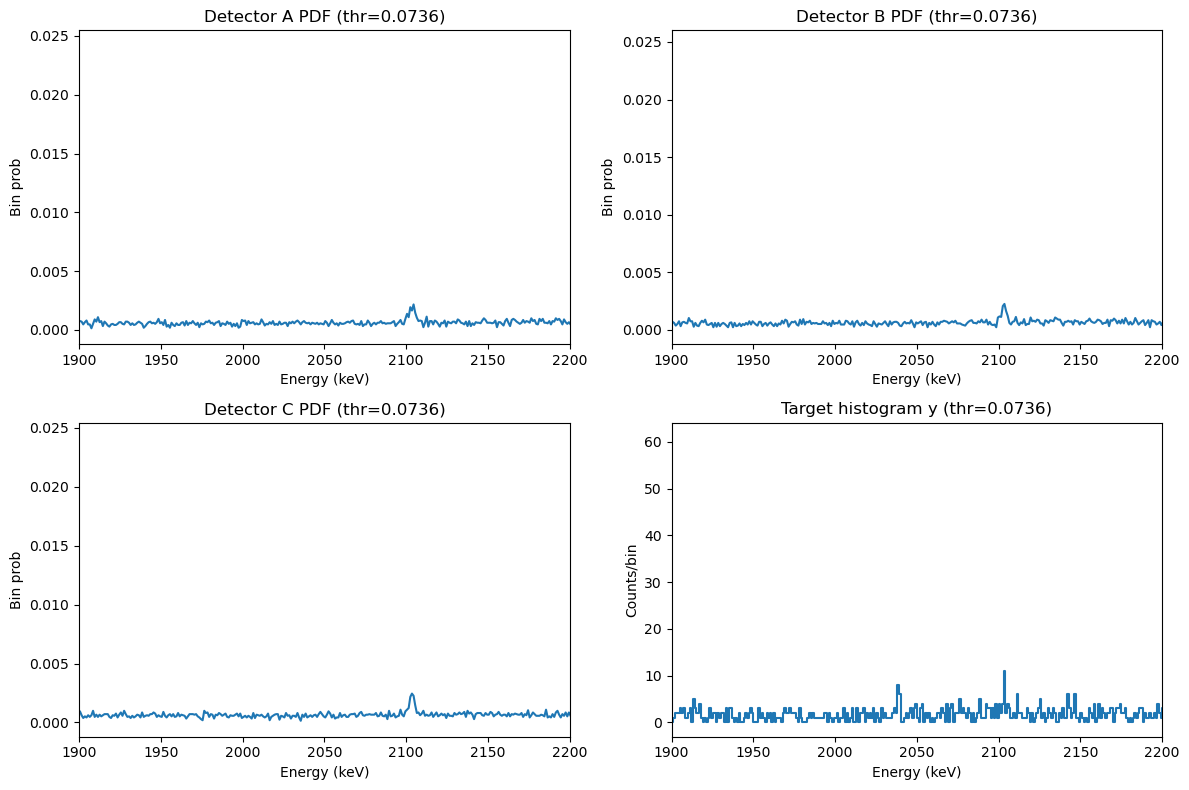

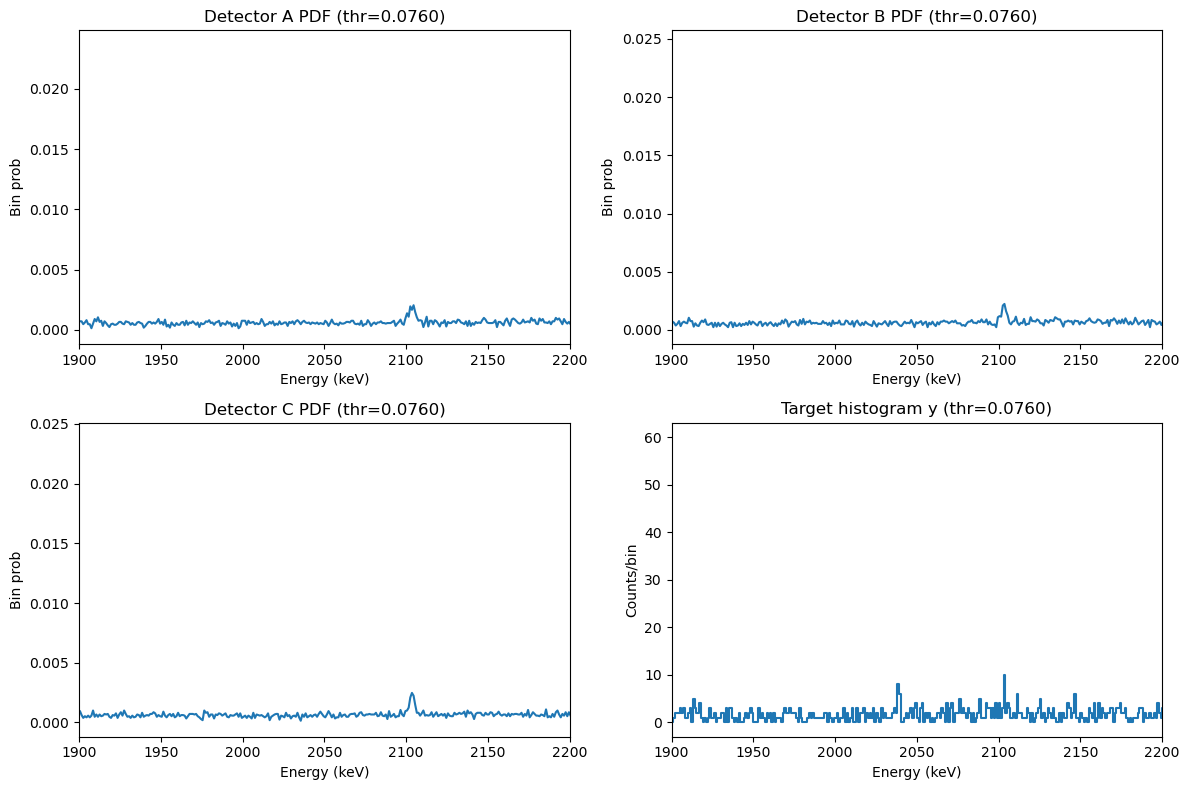

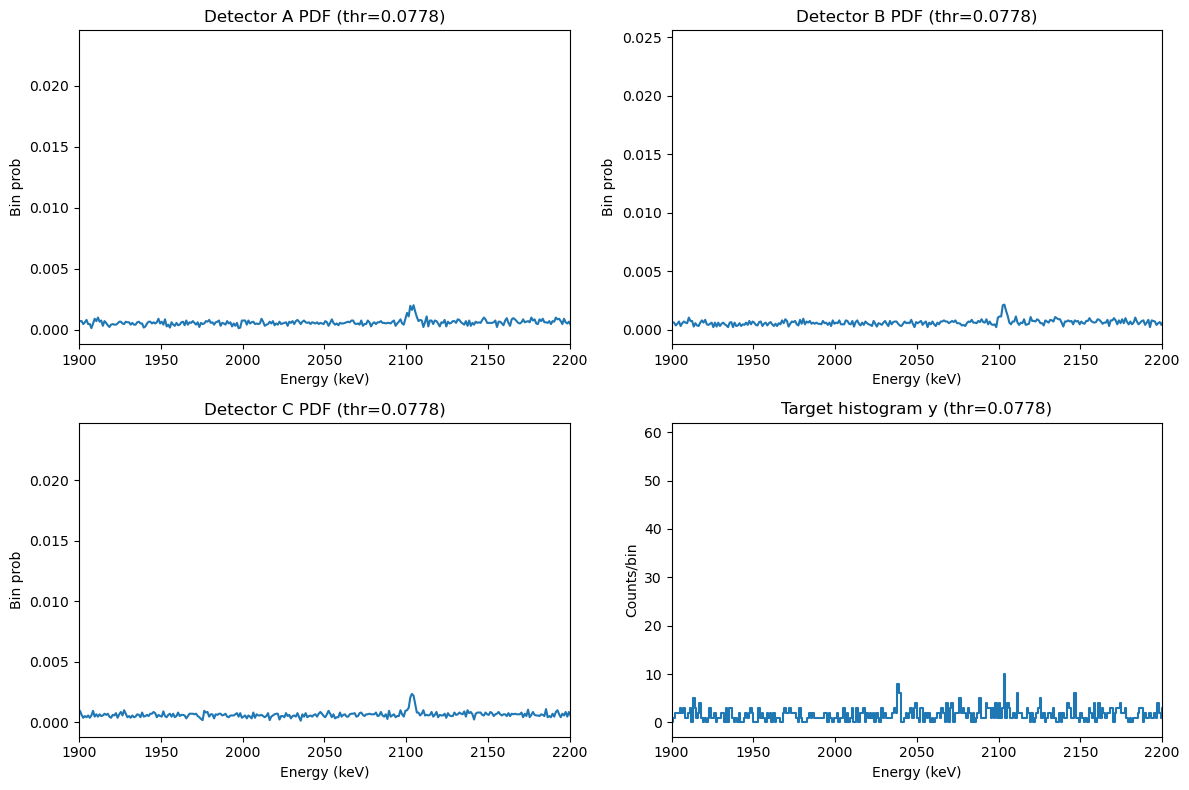

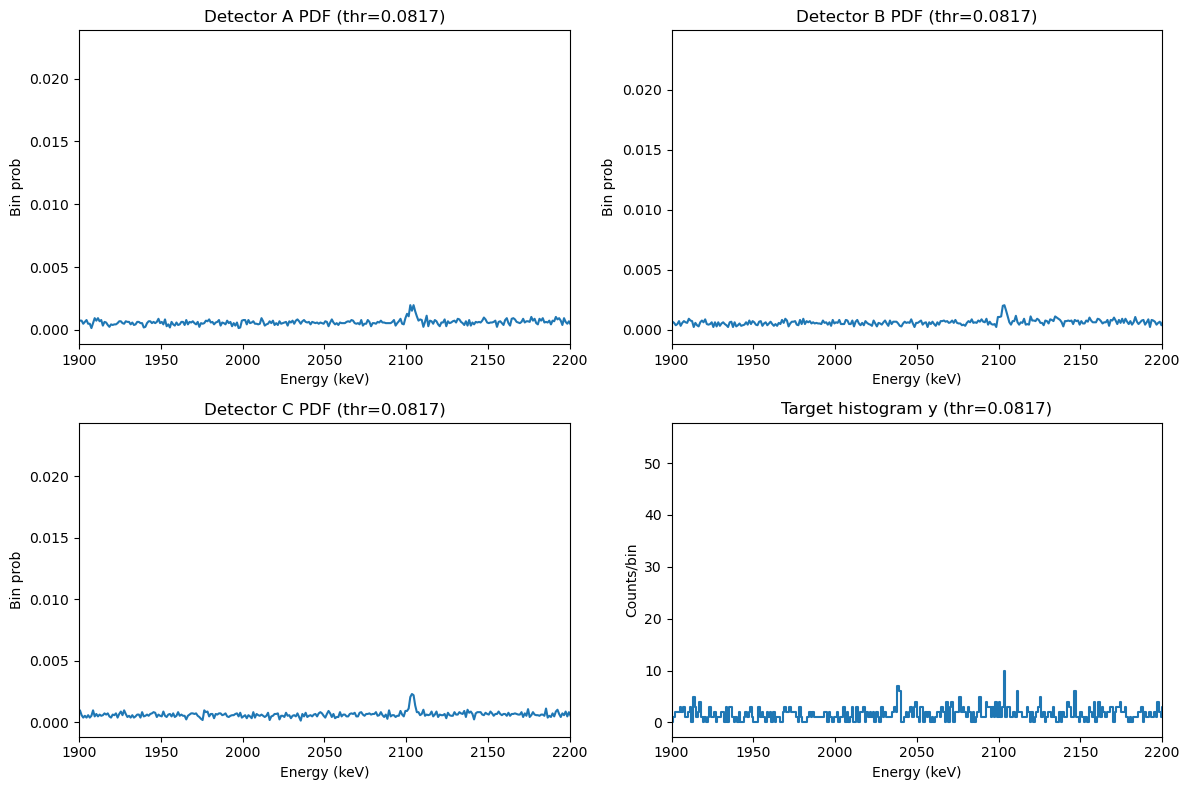

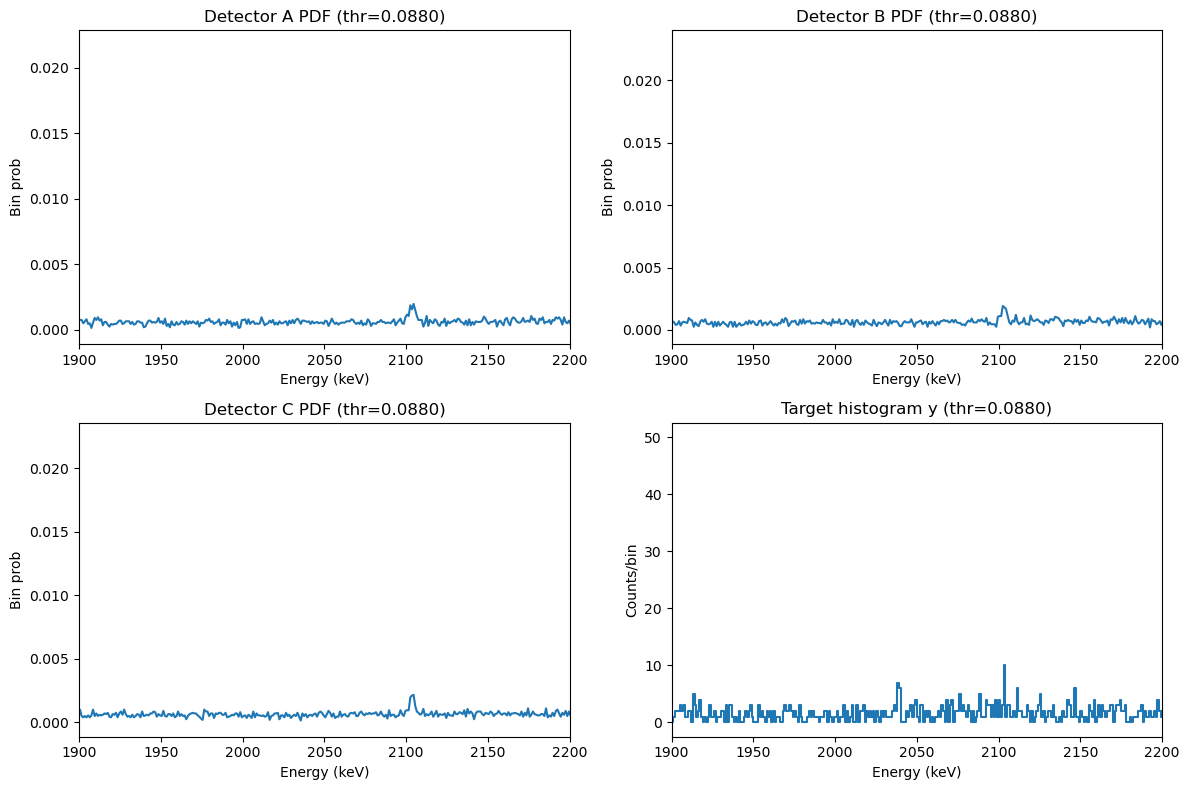

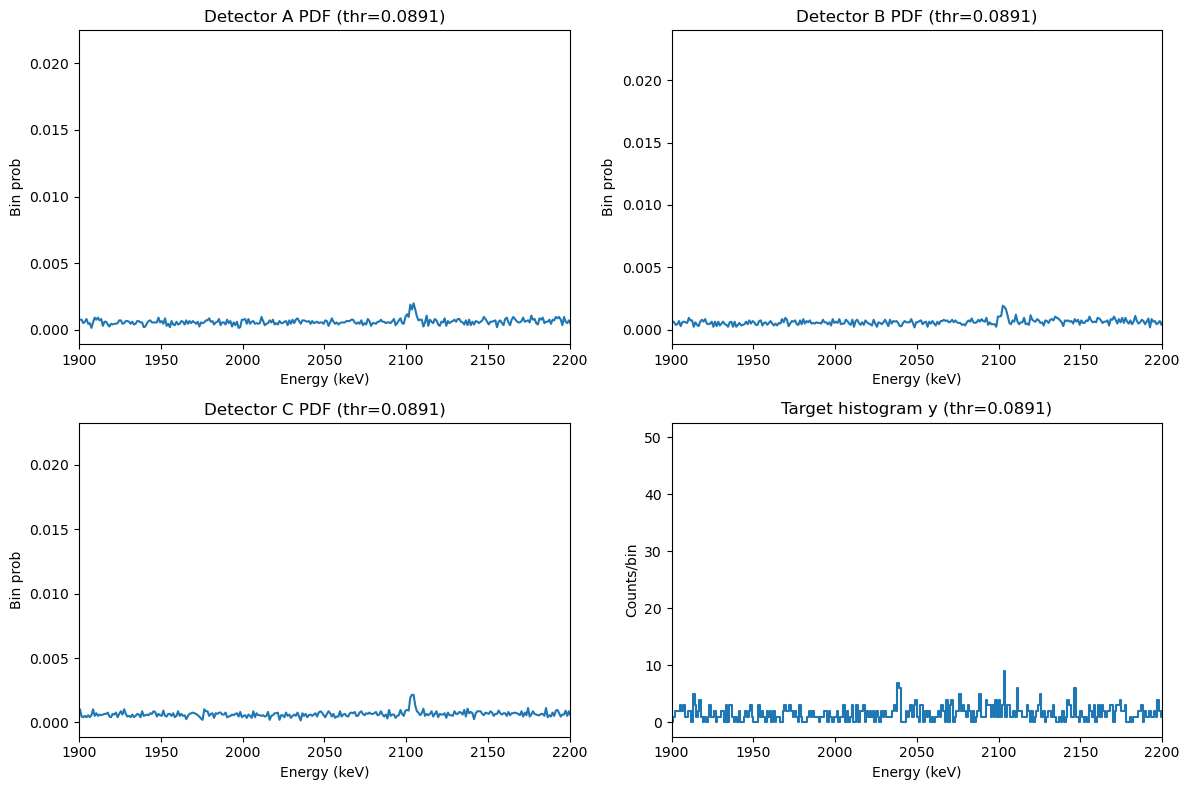

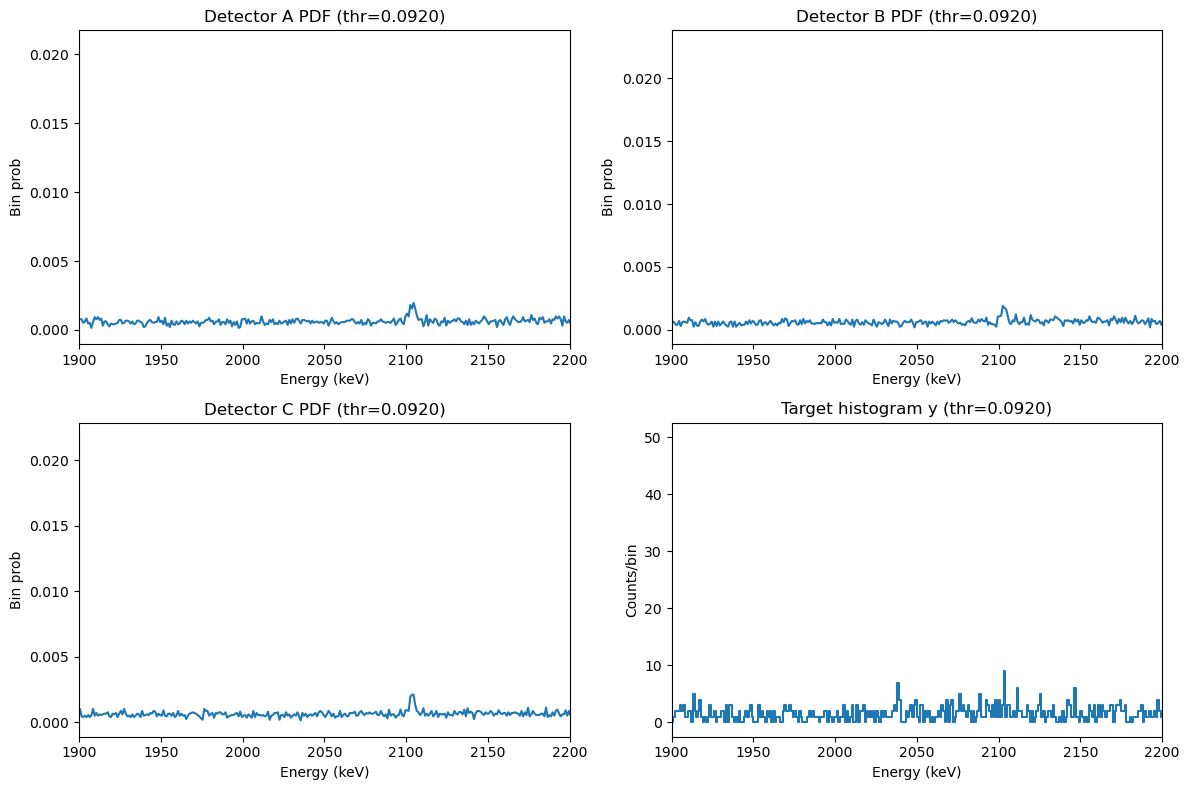

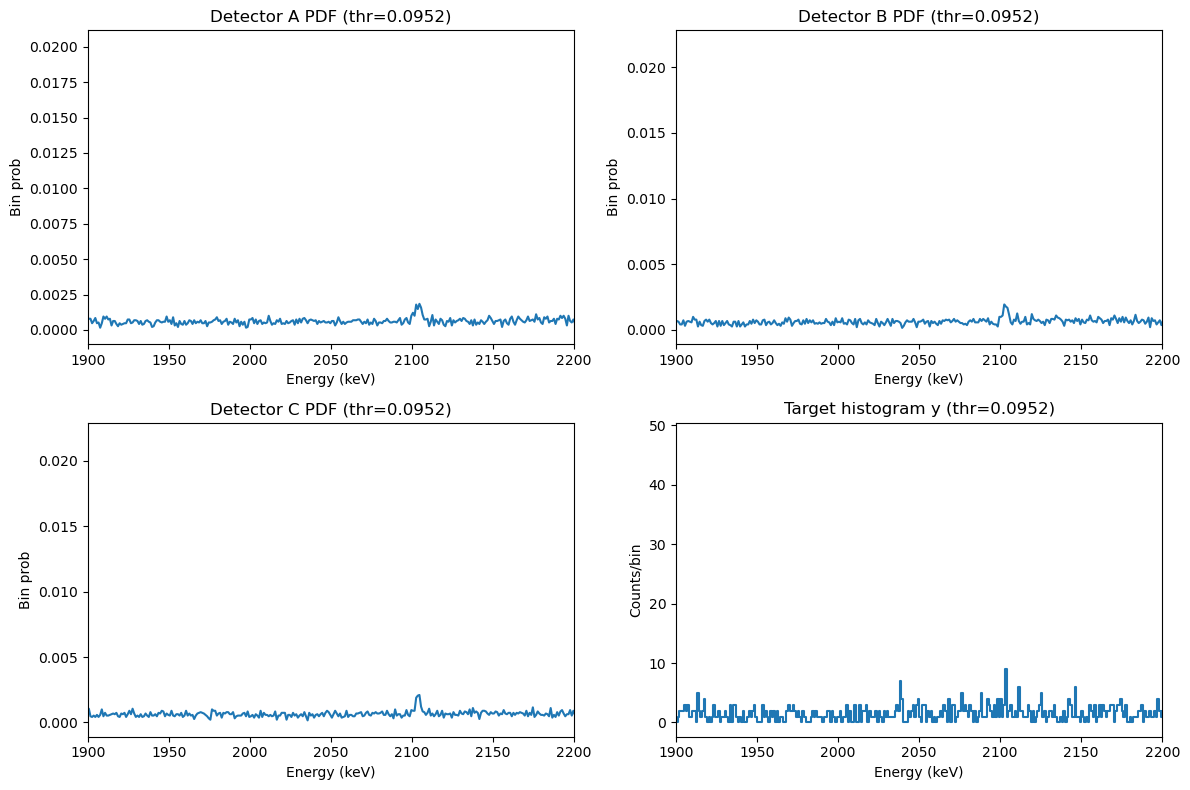

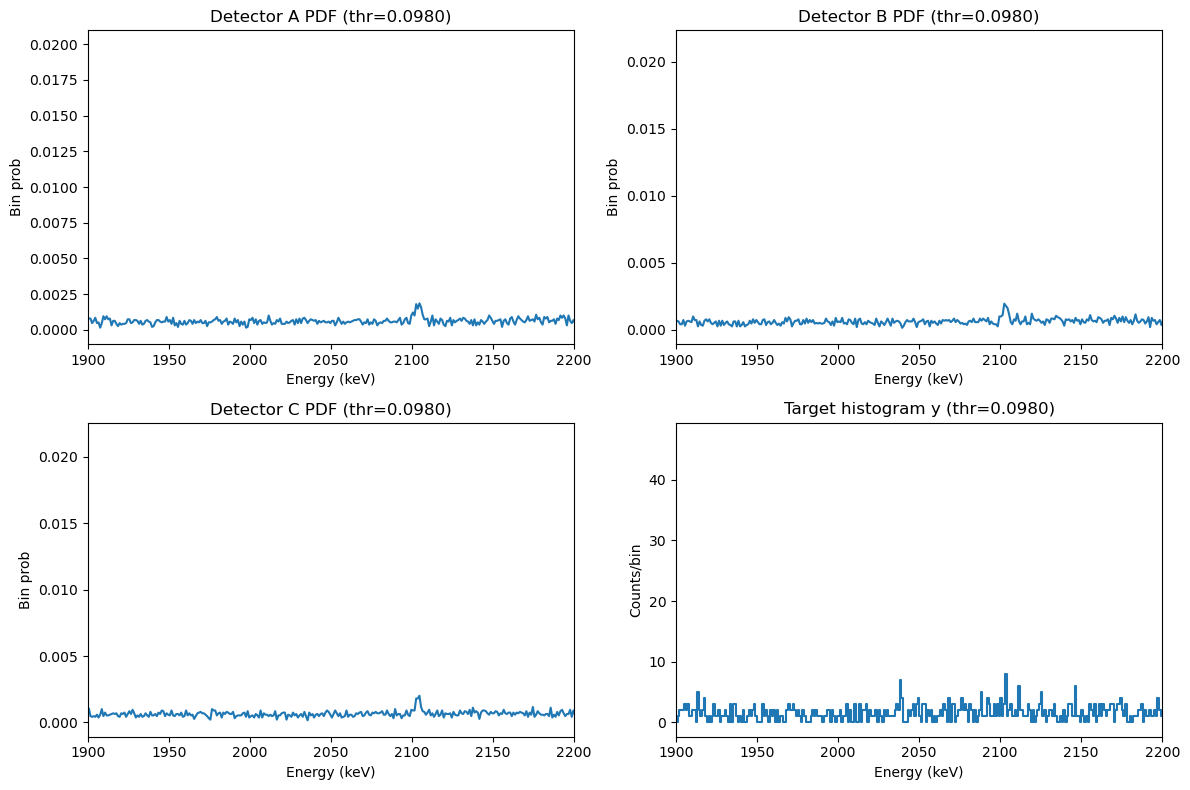

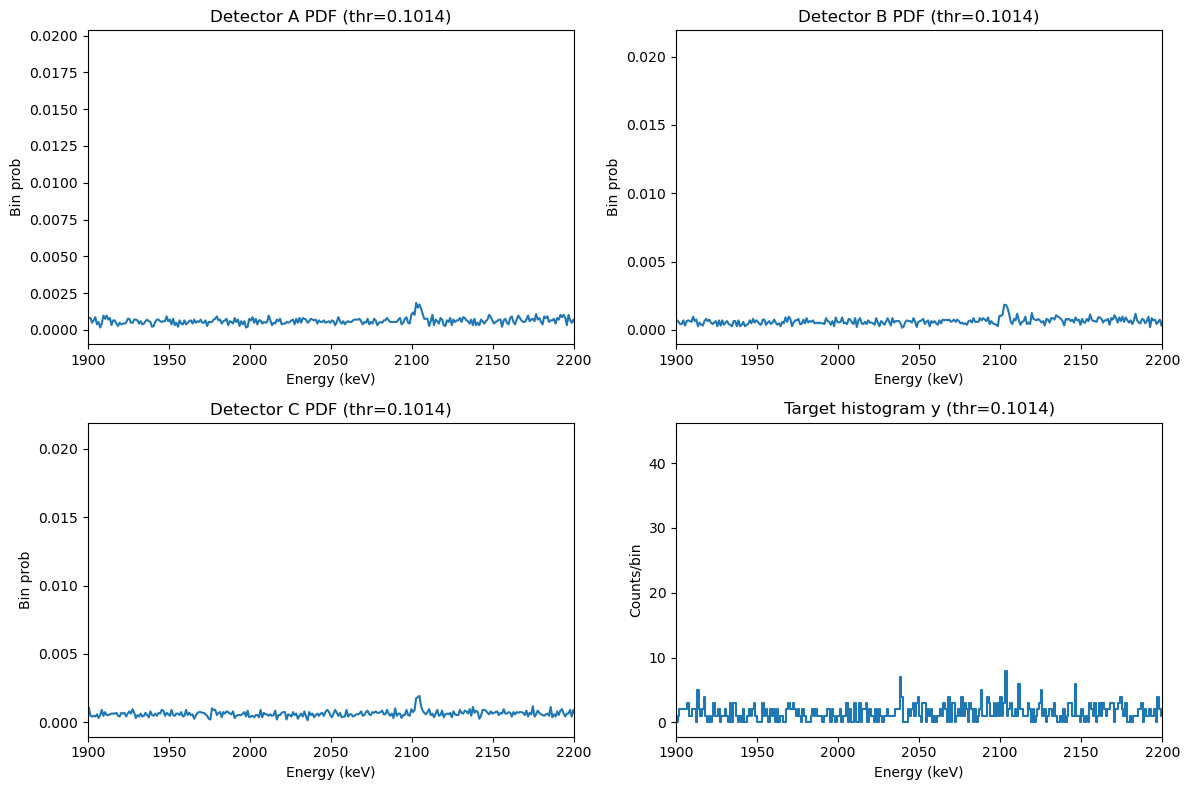

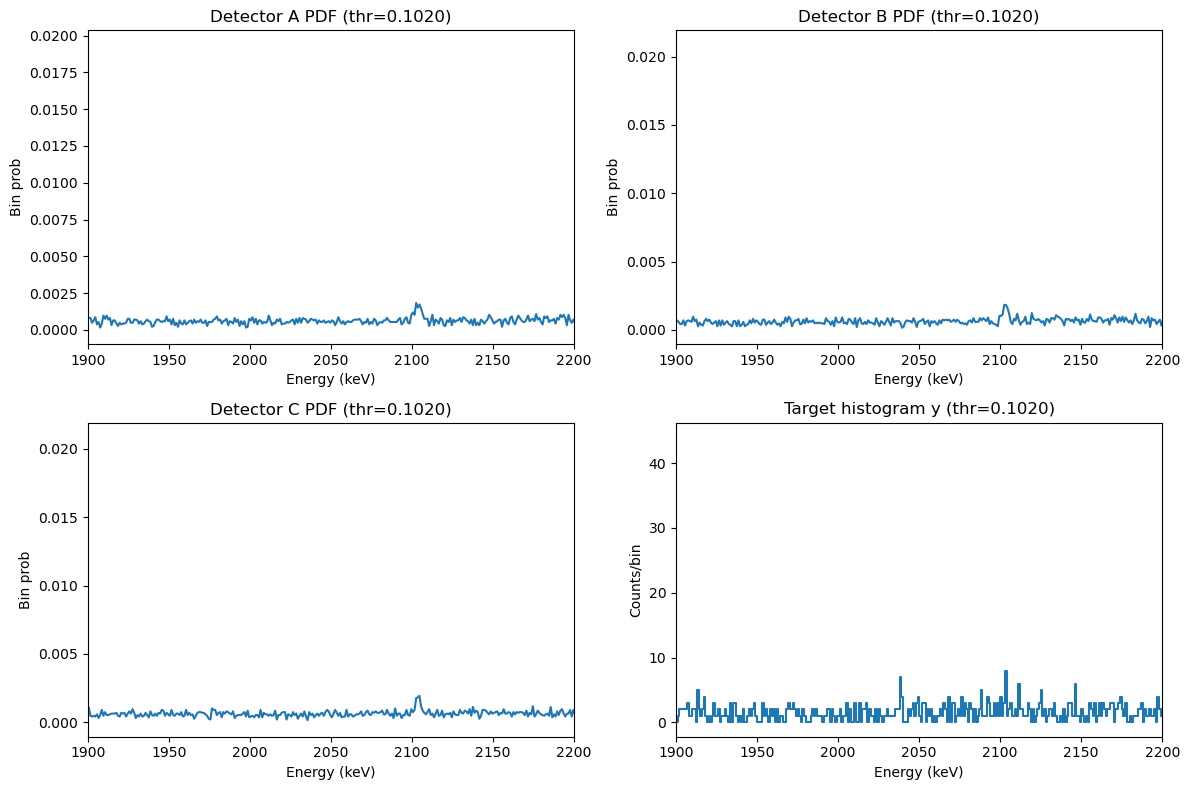

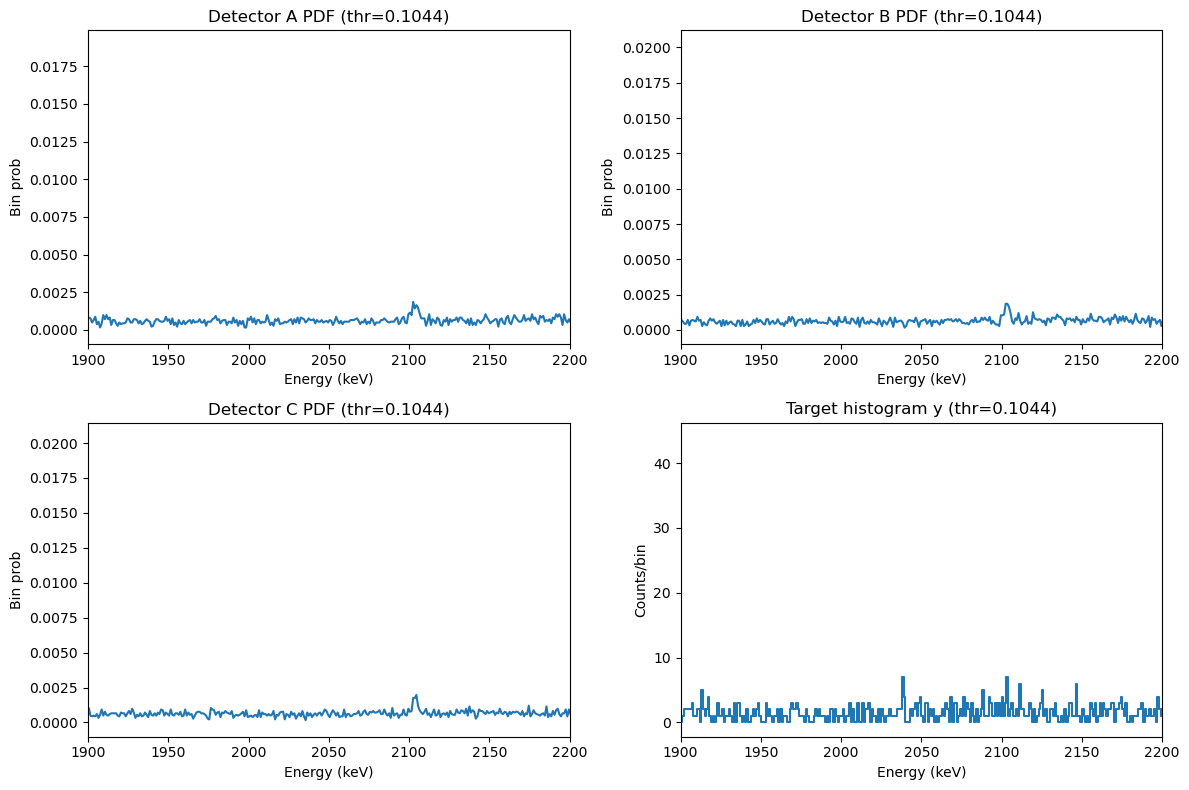

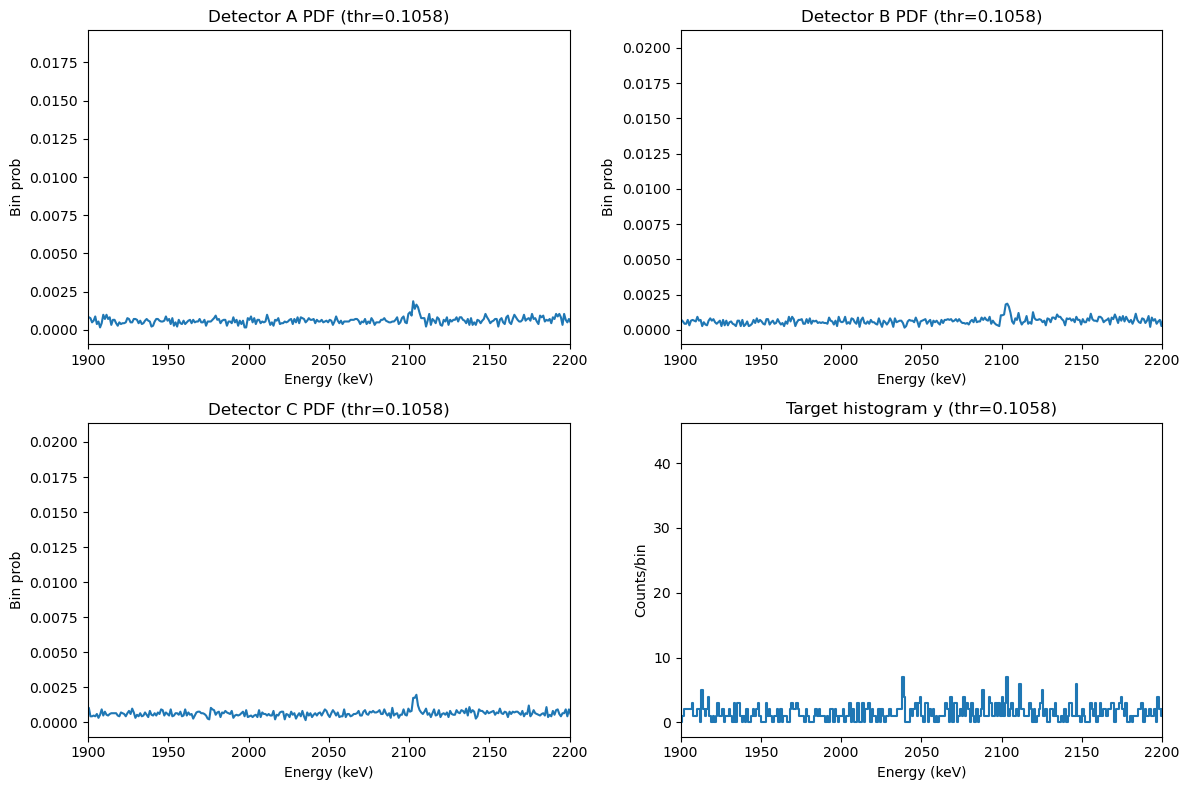

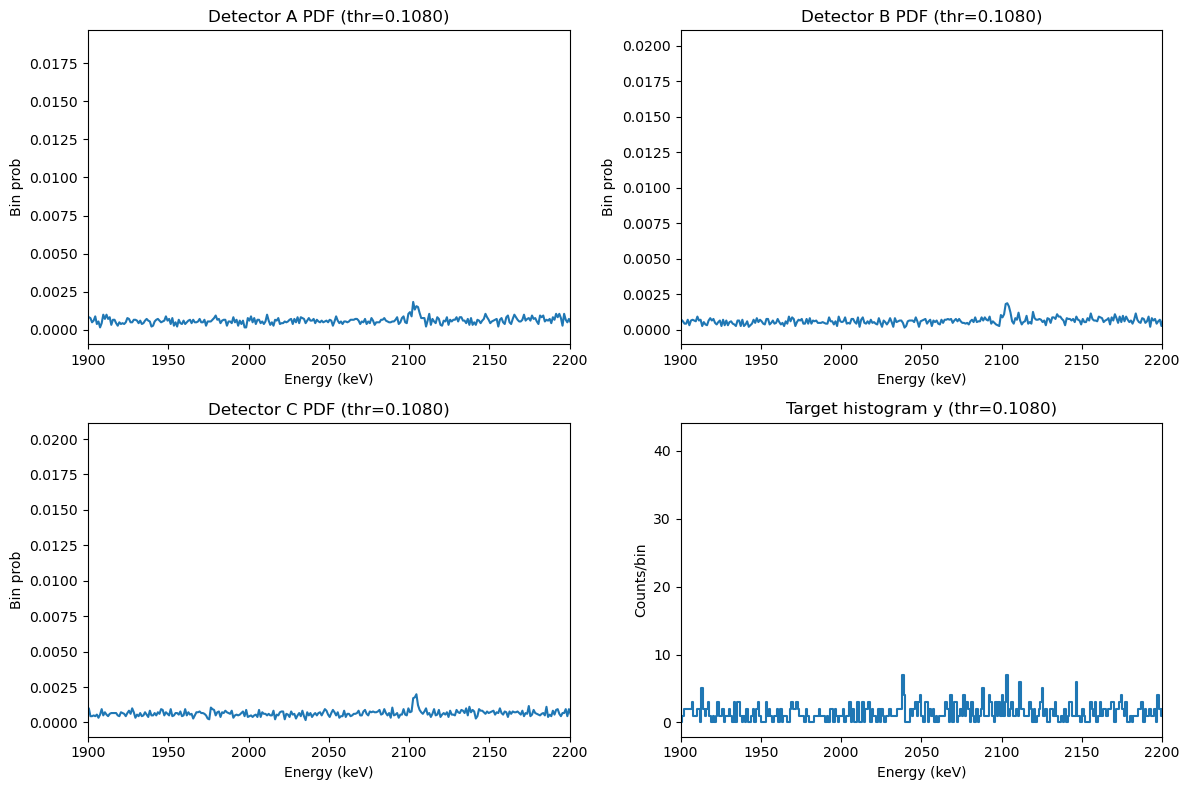

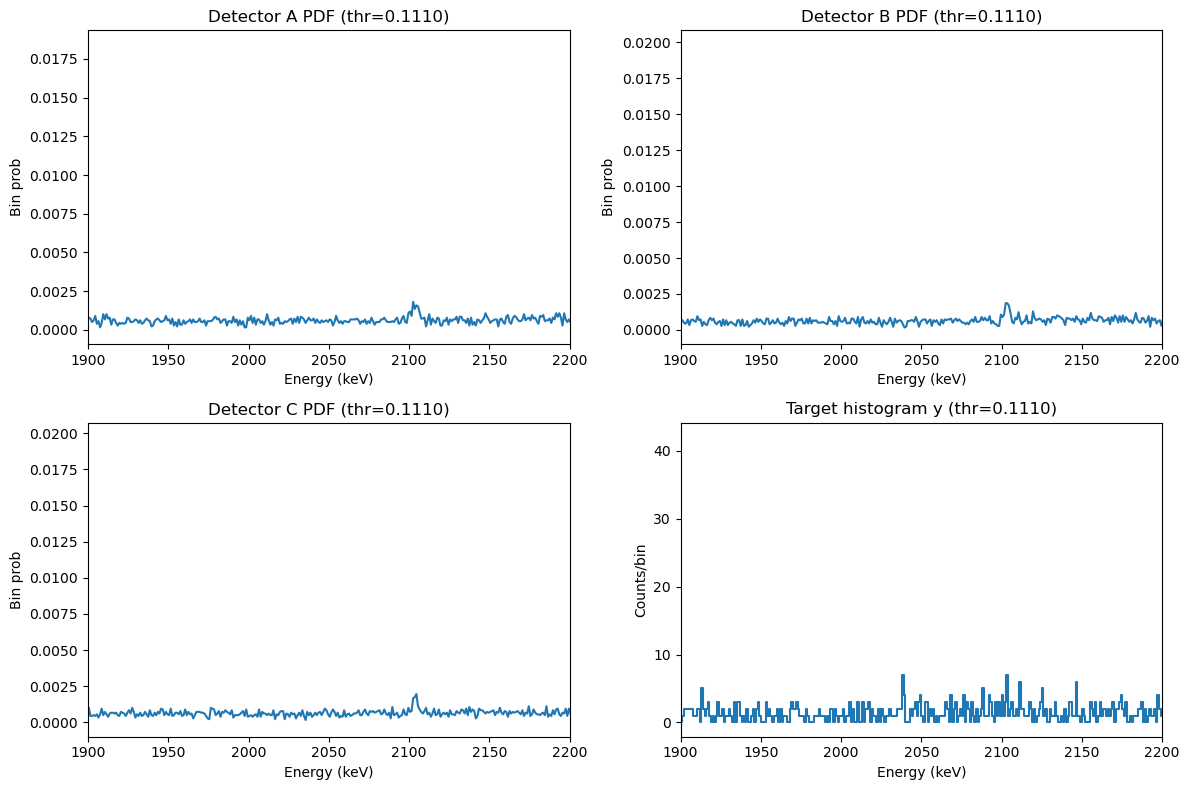

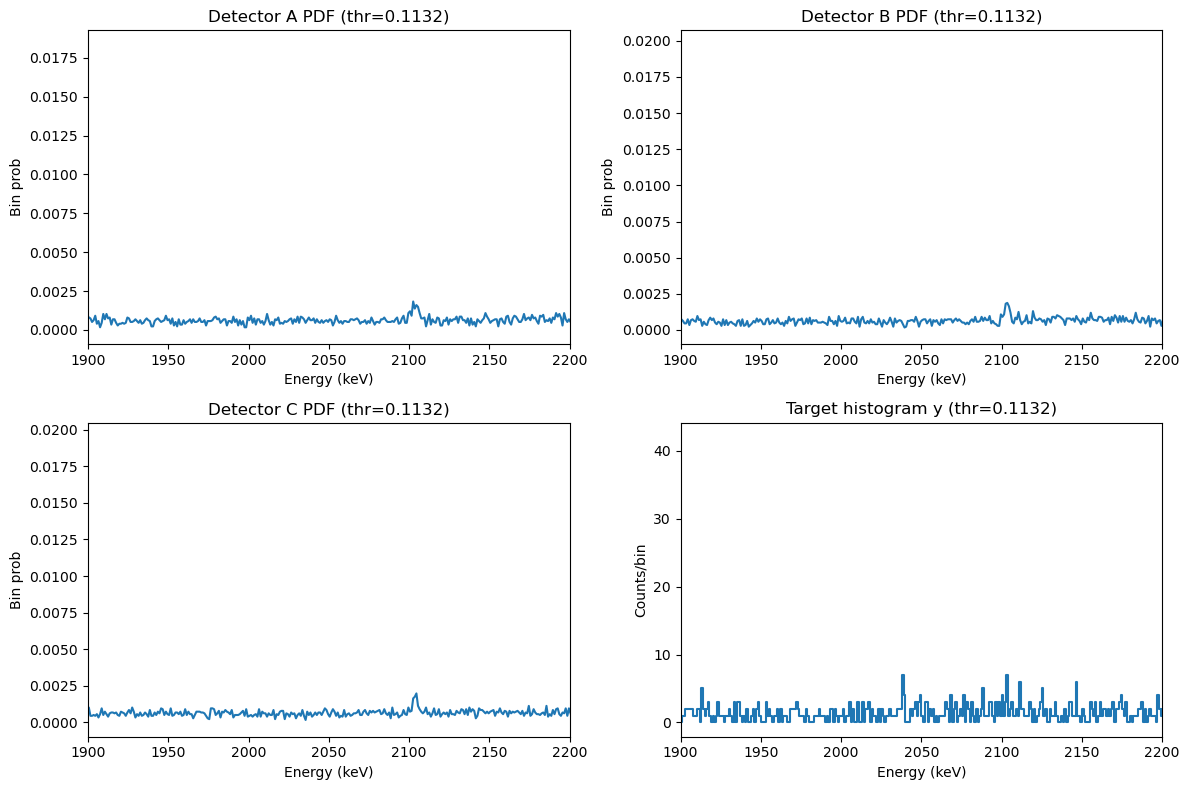

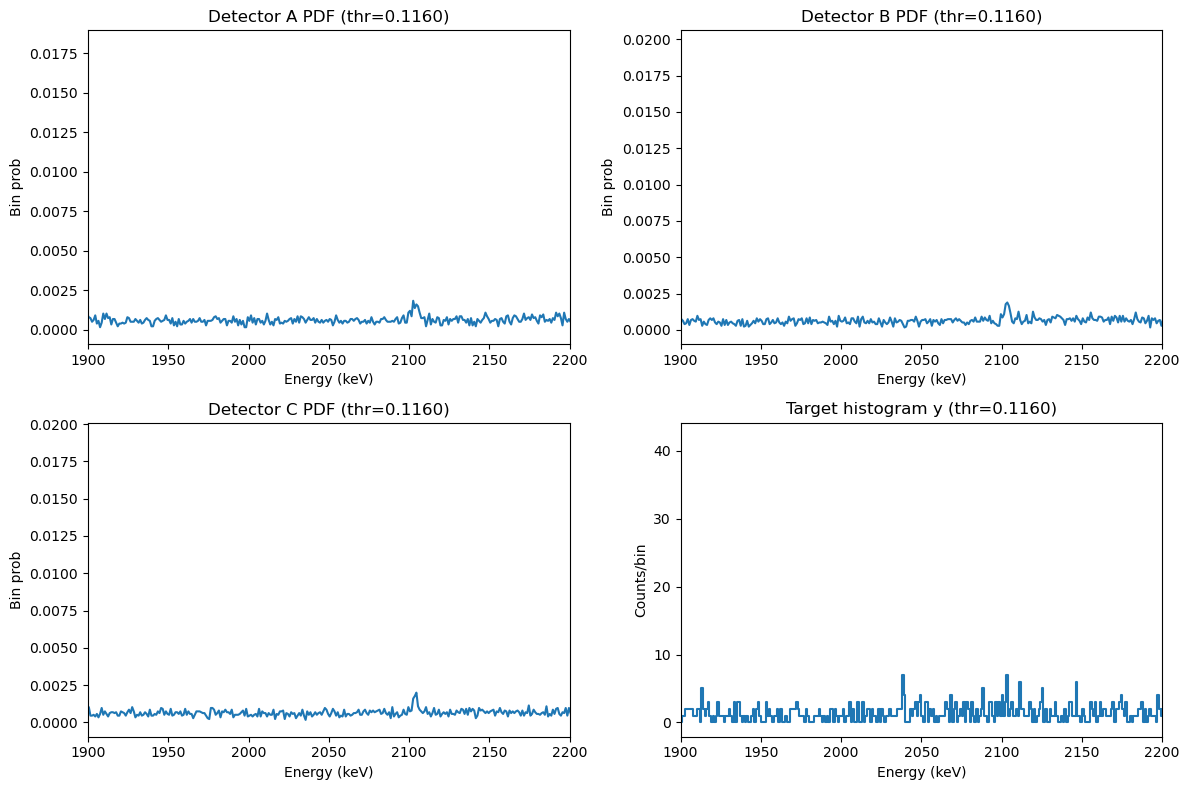

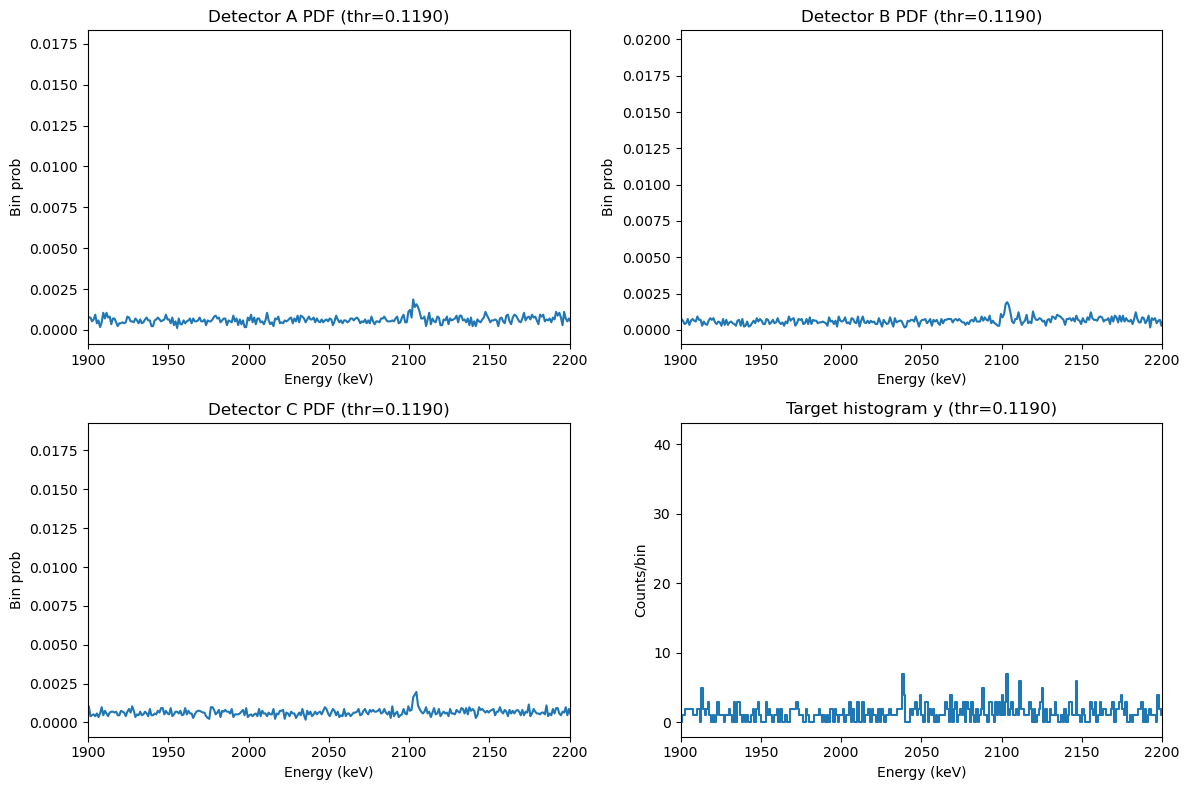

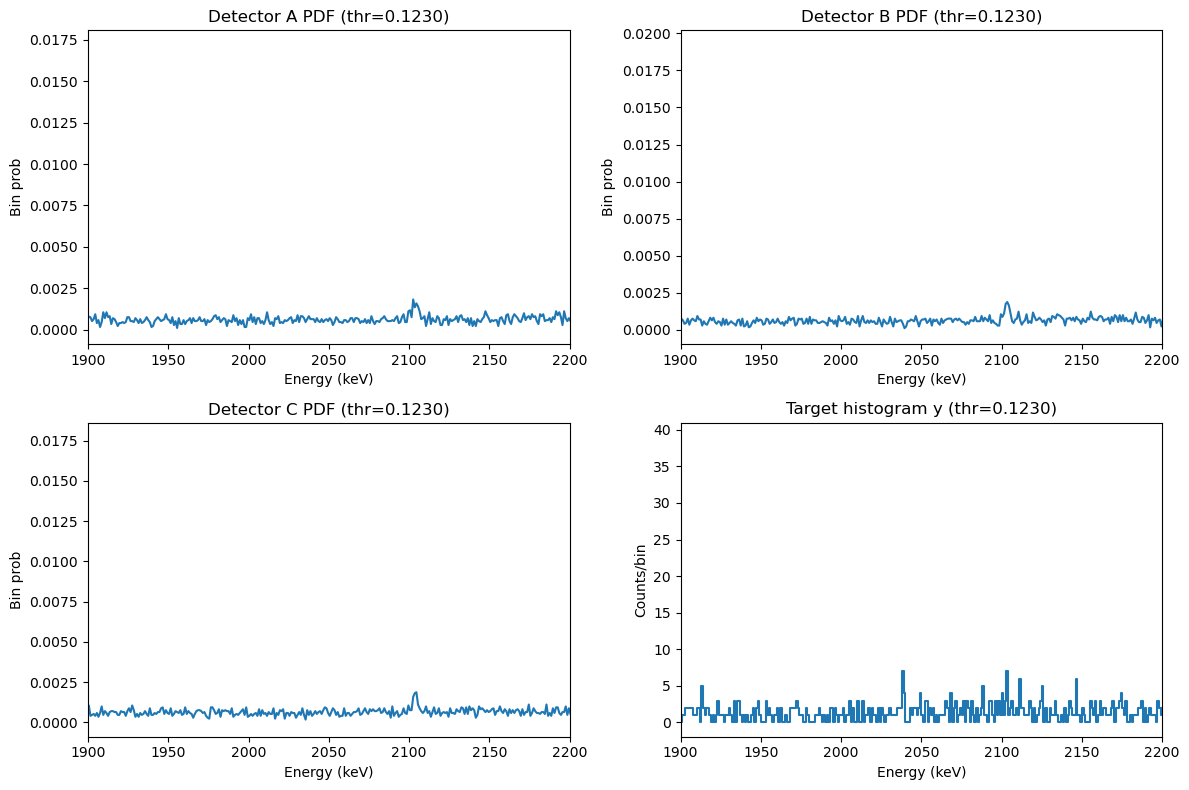

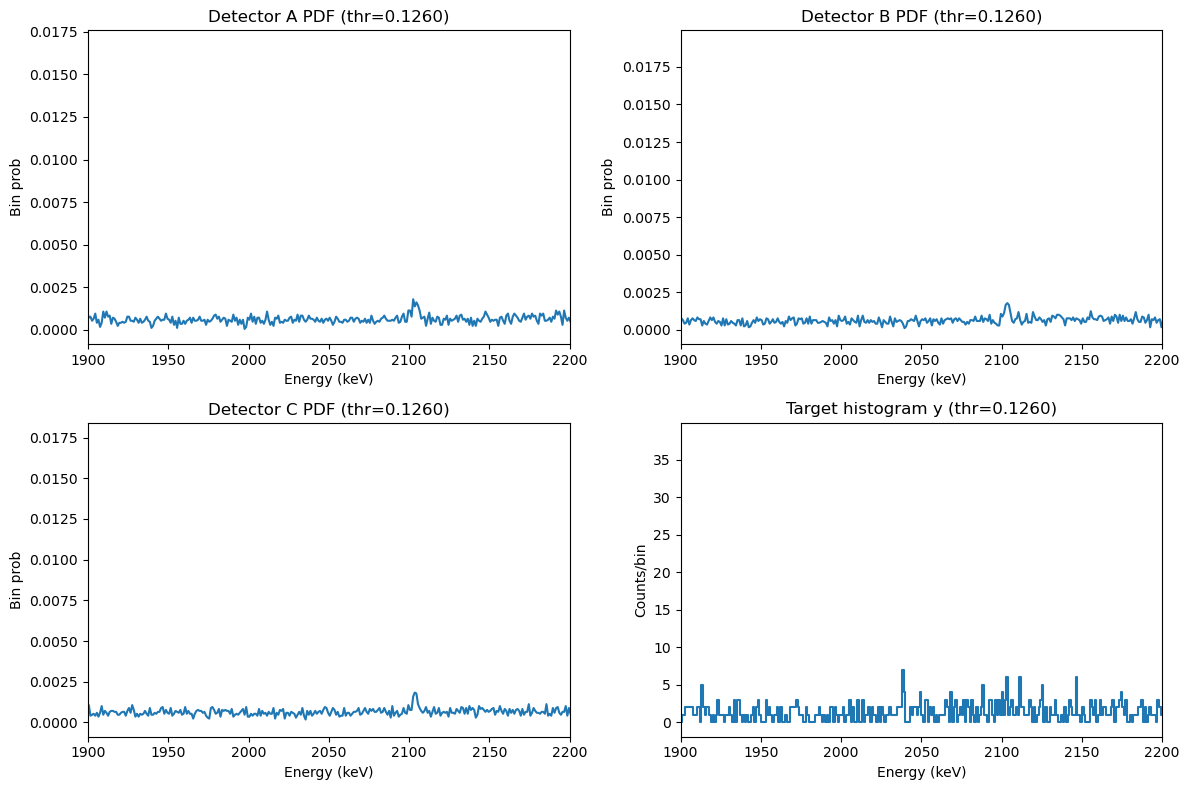

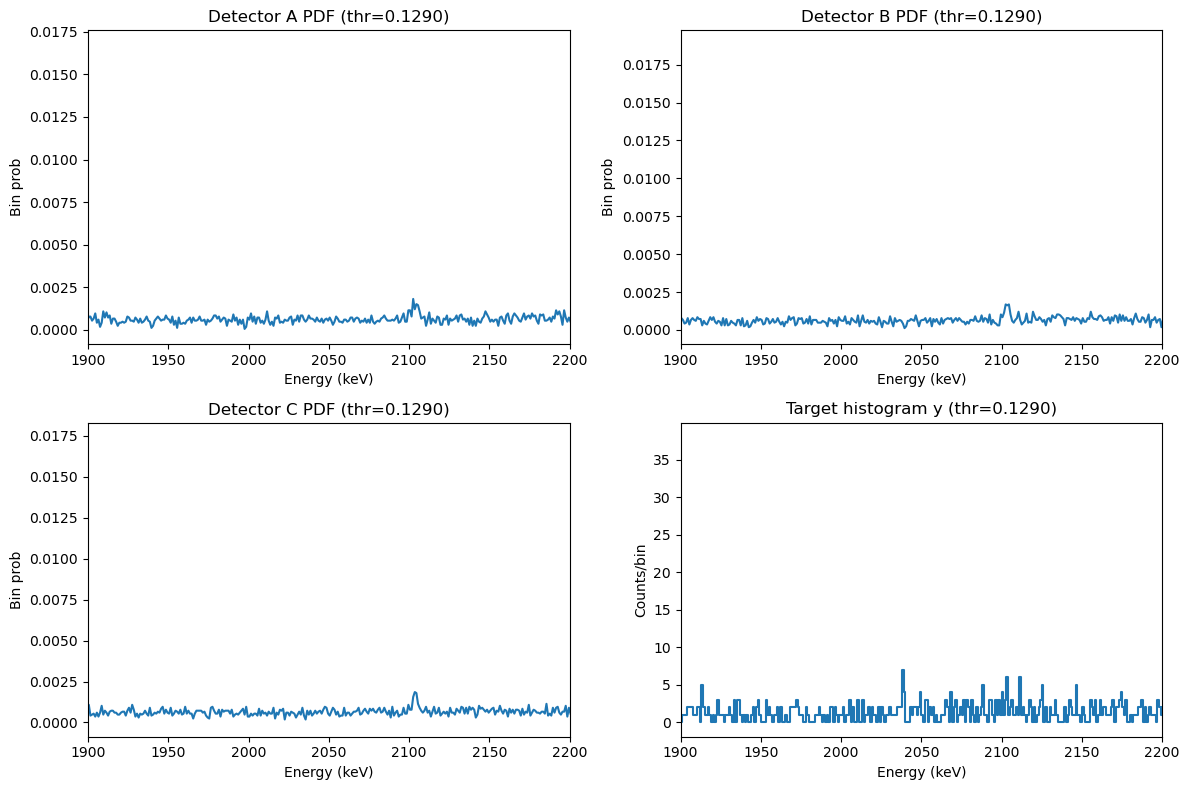

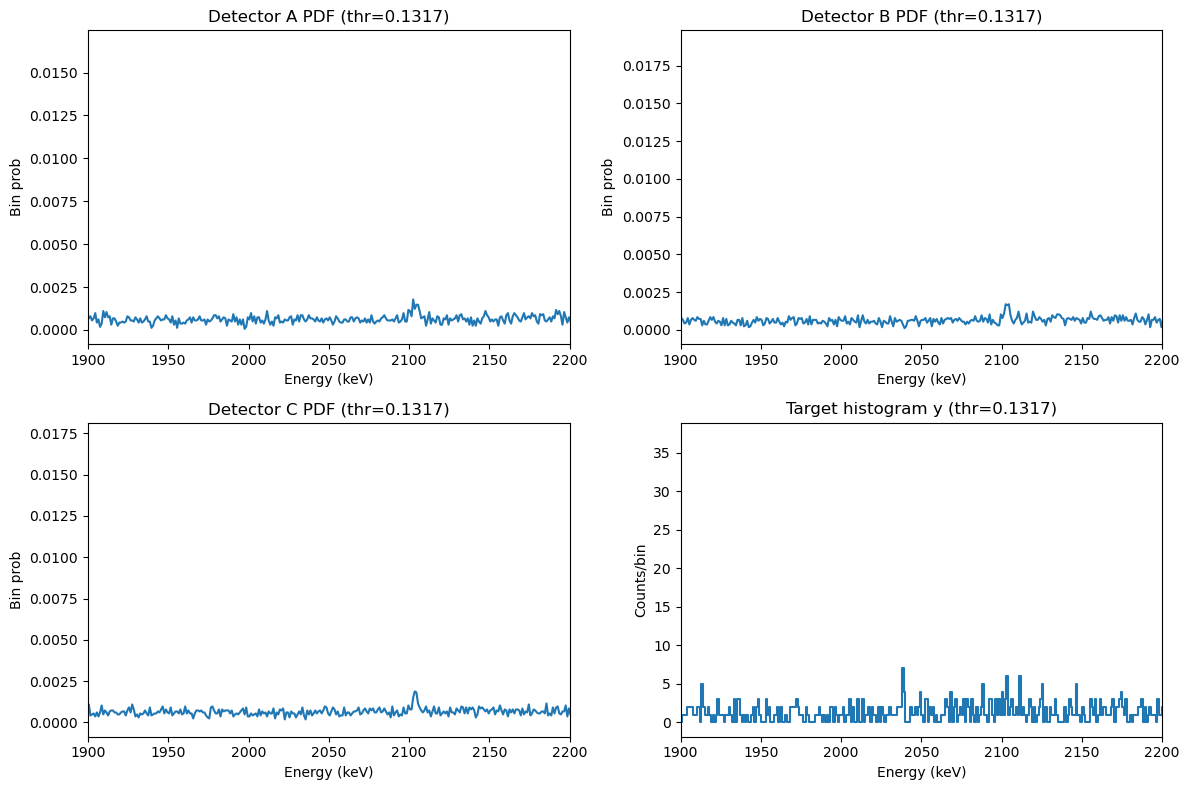

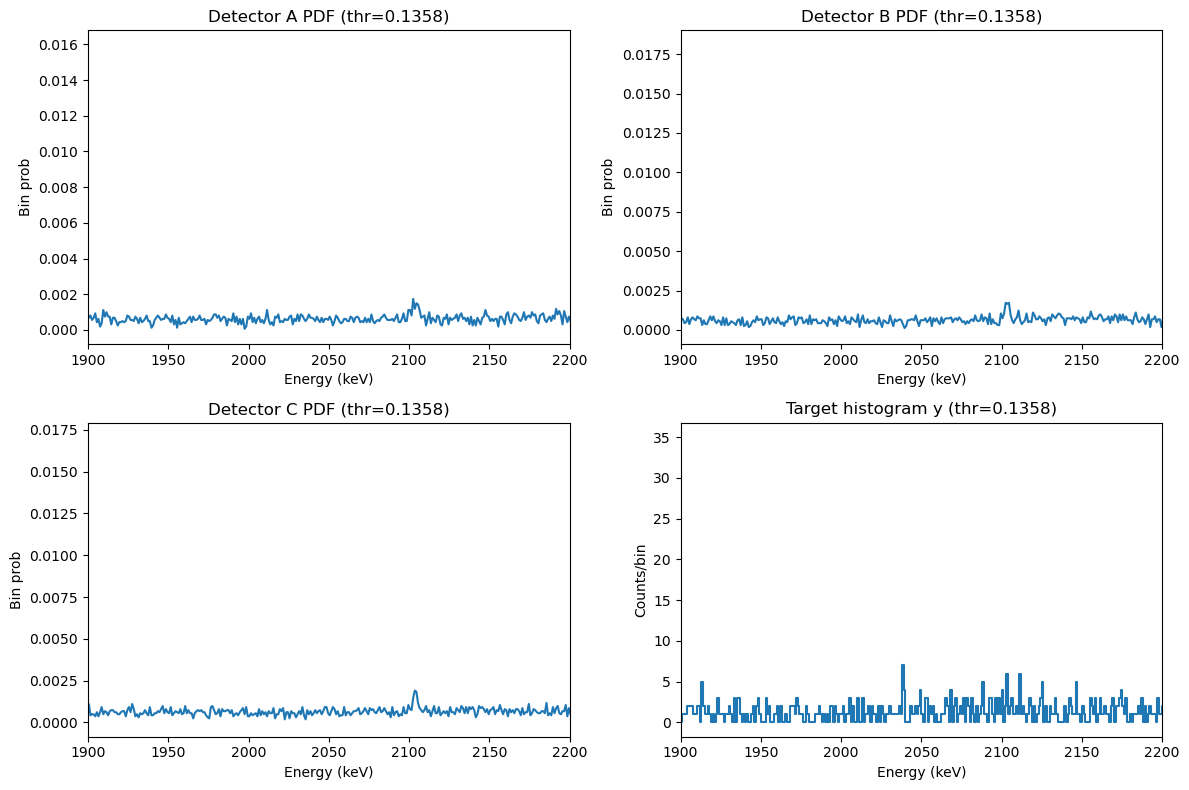

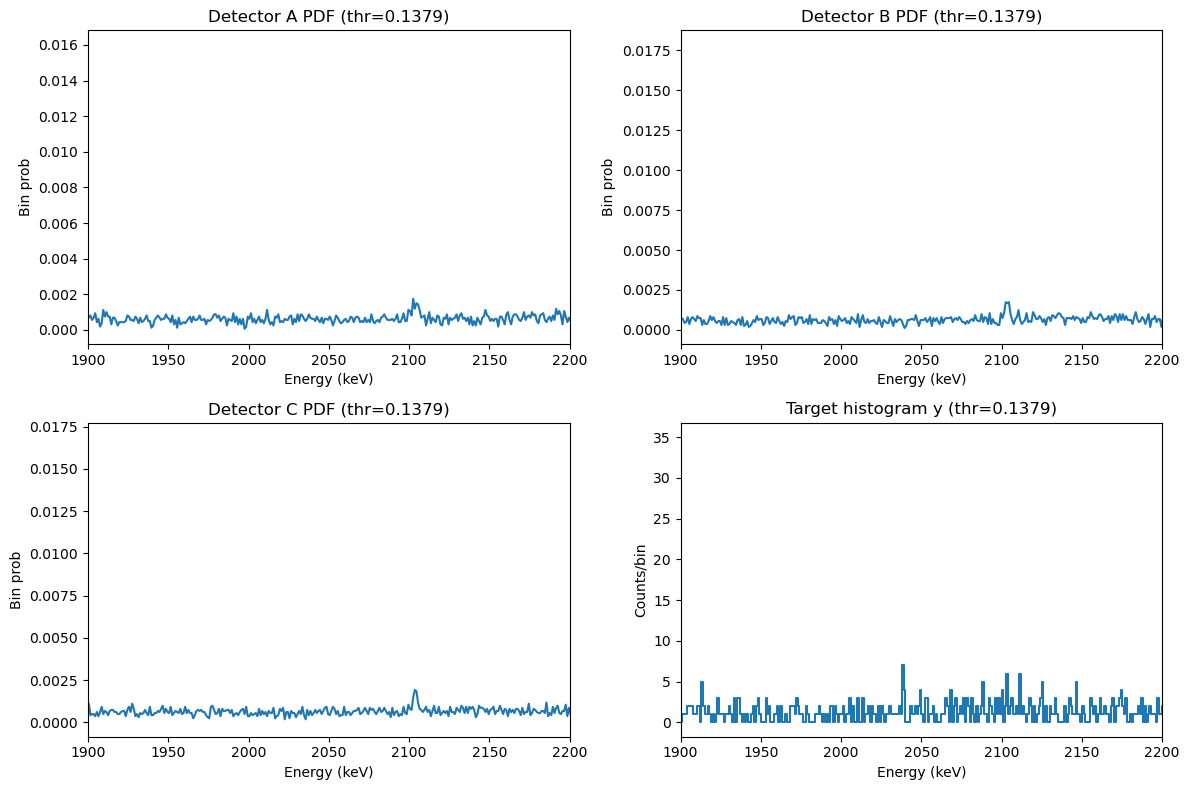

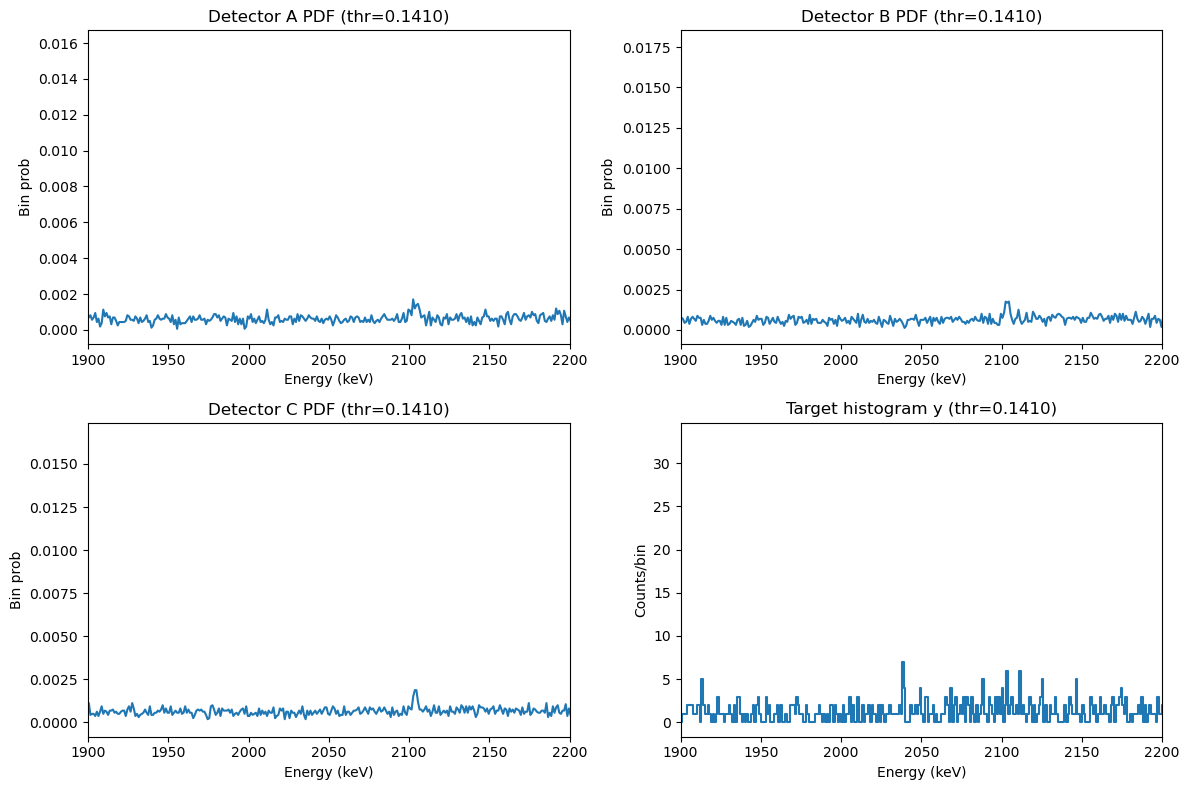

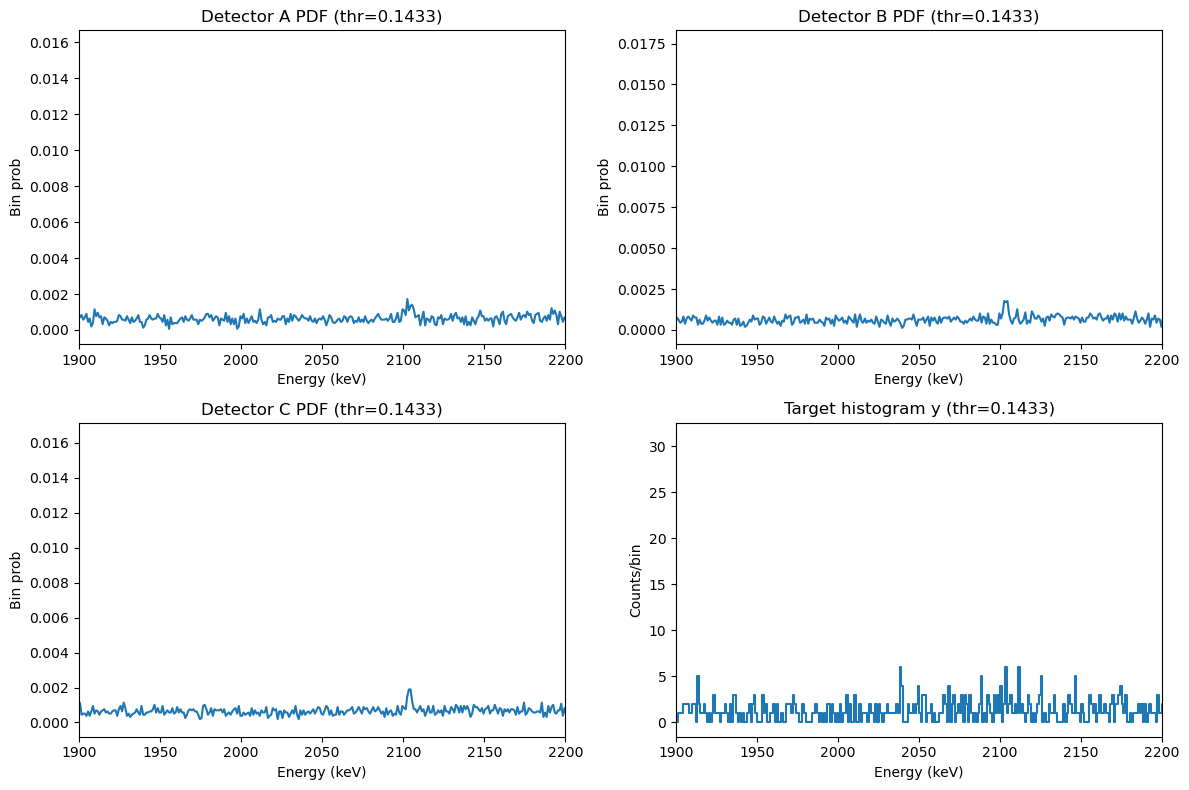

In [12]:
# ==========================================================
# Step 5 plotting: for each candidate threshold, plot pA/pB/pC and target y (2x2)
# ==========================================================
def plot_step5_one_thr(thr_pick: float, templates_by_thr: dict,
                       centers: np.ndarray, roi=(1900, 2200)):
    pack = templates_by_thr[thr_pick]
    pA, pB, pC, y = pack["pA"], pack["pB"], pack["pC"], pack["y"]

    lo, hi = roi
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.ravel()

    # A PDF
    axes[0].plot(centers, pA)
    axes[0].set_title(f"Detector A PDF (thr={thr_pick:.4f})")
    axes[0].set_xlim(lo, hi)
    axes[0].set_xlabel("Energy (keV)")
    axes[0].set_ylabel("Bin prob")

    # B PDF
    axes[1].plot(centers, pB)
    axes[1].set_title(f"Detector B PDF (thr={thr_pick:.4f})")
    axes[1].set_xlim(lo, hi)
    axes[1].set_xlabel("Energy (keV)")
    axes[1].set_ylabel("Bin prob")

    # C PDF
    axes[2].plot(centers, pC)
    axes[2].set_title(f"Detector C PDF (thr={thr_pick:.4f})")
    axes[2].set_xlim(lo, hi)
    axes[2].set_xlabel("Energy (keV)")
    axes[2].set_ylabel("Bin prob")

    # Target histogram counts
    axes[3].step(centers, y, where="mid")
    axes[3].set_title(f"Target histogram y (thr={thr_pick:.4f})")
    axes[3].set_xlim(lo, hi)
    axes[3].set_xlabel("Energy (keV)")
    axes[3].set_ylabel("Counts/bin")

    plt.tight_layout()
    plt.show()

# plot all candidates
ROI = (1900, 2200)  # or (1000, 3500) if you want full range (will look flat)
for thr_i in THR_GRID_F:
    plot_step5_one_thr(float(thr_i), templates_by_thr, centers, roi=ROI)


## Step 6:


In [13]:
# -----------------------------
# Step 6: fit function
# -----------------------------

THETA_A_MU, THETA_A_SIG = 1350.0, 100.0
THETA_B_MU, THETA_B_SIG = 770.0, 270.0

def fit_target(
    y, pA, pB, pC, pN,
    thetaA_mu=THETA_A_MU, thetaA_sig=THETA_A_SIG,
    thetaB_mu=THETA_B_MU, thetaB_sig=THETA_B_SIG,
    use_calib_penalty=True
):
    total = float(np.sum(y))
    x0 = np.array([
        thetaA_mu,
        thetaB_mu,
        max(total - thetaA_mu - thetaB_mu, 10.0),
        0.0
    ], float)

    bounds = [(0, None), (0, None), (0, None), (0, None)]

    res = minimize(
        lambda x: nll_poisson_mixture(
            x, y, pA, pB, pC, pN,
            thetaA_mu, thetaA_sig, thetaB_mu, thetaB_sig,
            use_calib_penalty
        ),
        x0,
        method="L-BFGS-B",
        bounds=bounds
    )

    thetaA_hat, thetaB_hat, thetaC_hat, thetaN_hat = res.x
    mu_hat = thetaA_hat*pA + thetaB_hat*pB + thetaC_hat*pC + thetaN_hat*pN

    return {
        "success": bool(res.success),
        "fun": float(res.fun),
        "thetaA": float(thetaA_hat),
        "thetaB": float(thetaB_hat),
        "thetaC": float(thetaC_hat),
        "thetaN": float(thetaN_hat),
        "mu_hat": mu_hat,
        "res": res,
    }

# -----------------------------
# Step 6: plot helper
# -----------------------------
ROI = (1900, 2200)
def plot_target_vs_fit(centers, y, mu_hat, thr, roi=ROI, extra_title=""):
    lo, hi = roi
    plt.figure(figsize=(8, 4))
    plt.step(centers, y, where="mid", label="Target")
    plt.step(centers, mu_hat, where="mid", label="Fit")
    plt.xlim(lo, hi)
    plt.xlabel("Energy (keV)")
    plt.ylabel("Counts / bin")
    ttl = f"Target vs Fit (thr={thr:.4f})"
    if extra_title:
        ttl += " | " + extra_title
    plt.title(ttl)
    plt.legend()
    plt.tight_layout()
    plt.show()

def nll_poisson_mixture(params, y, pA, pB, pC, pN,
                        thetaA_mu, thetaA_sig, thetaB_mu, thetaB_sig,
                        use_calib_penalty=True):
    """
    Penalized Poisson NLL for binned mixture model:
      mu = thetaA*pA + thetaB*pB + thetaC*pC + thetaN*pN

    NLL = sum( mu - y*log(mu) ) + calibration penalties (optional)
    """
    thetaA, thetaB, thetaC, thetaN = params

    # enforce non-negativity (extra safety even with bounds)
    if (thetaA < 0) or (thetaB < 0) or (thetaC < 0) or (thetaN < 0):
        return 1e50

    mu = thetaA*pA + thetaB*pB + thetaC*pC + thetaN*pN
    mu = np.clip(mu, 1e-12, None)

    nll = float(np.sum(mu - y*np.log(mu)))  # constants dropped

    if use_calib_penalty:
        nll += 0.5*((thetaA - thetaA_mu)/thetaA_sig)**2
        nll += 0.5*((thetaB - thetaB_mu)/thetaB_sig)**2

    return nll


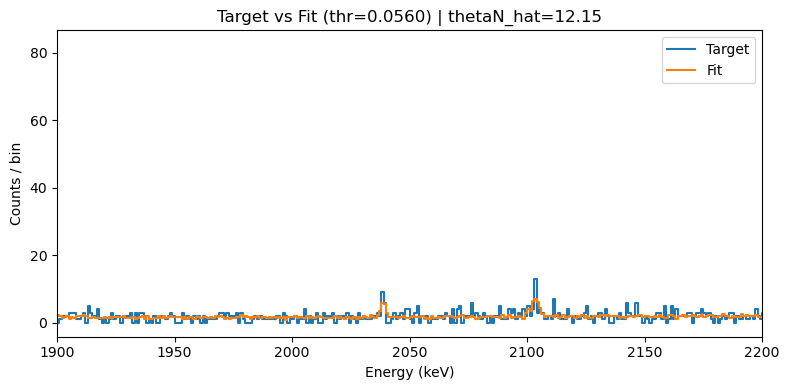

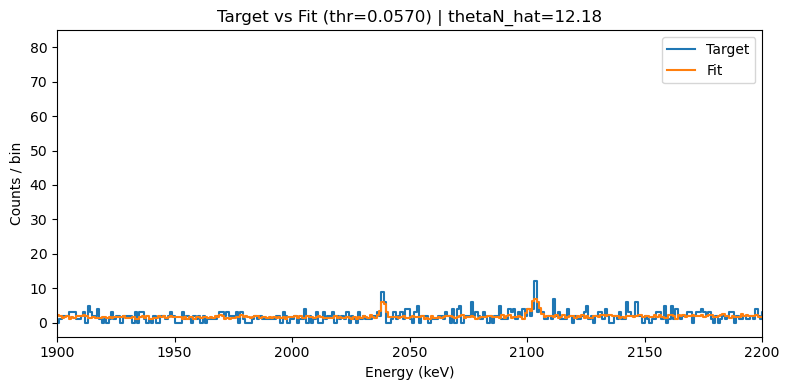

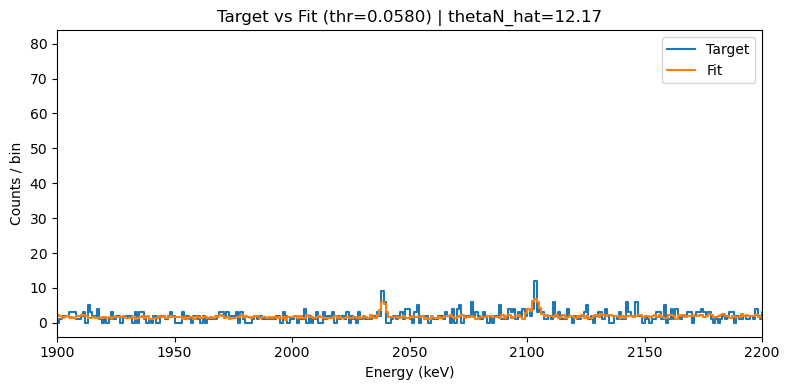

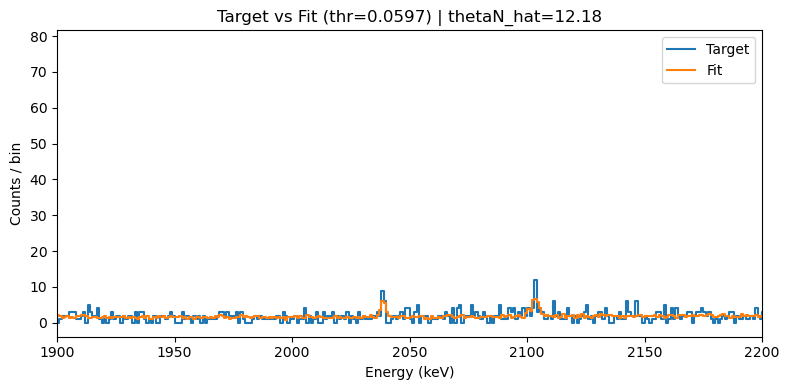

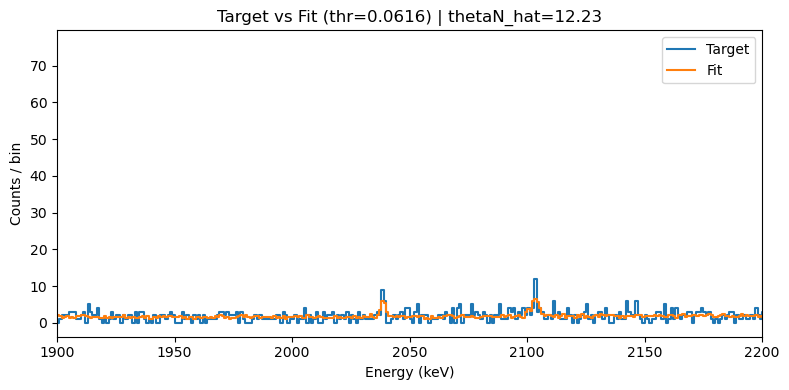

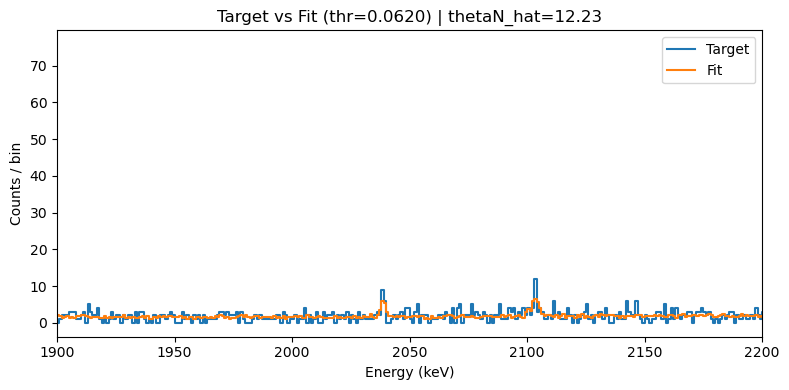

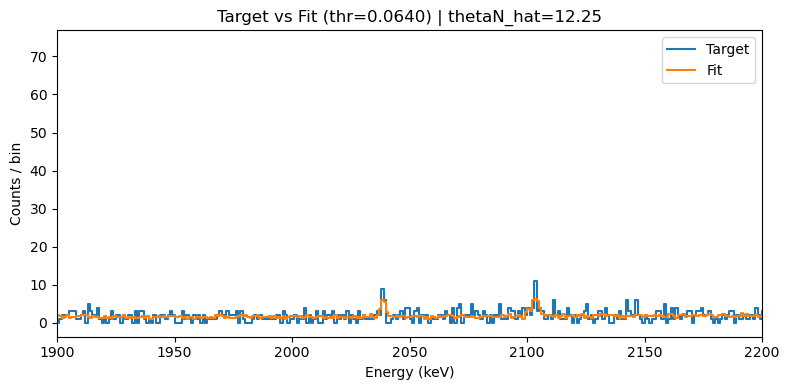

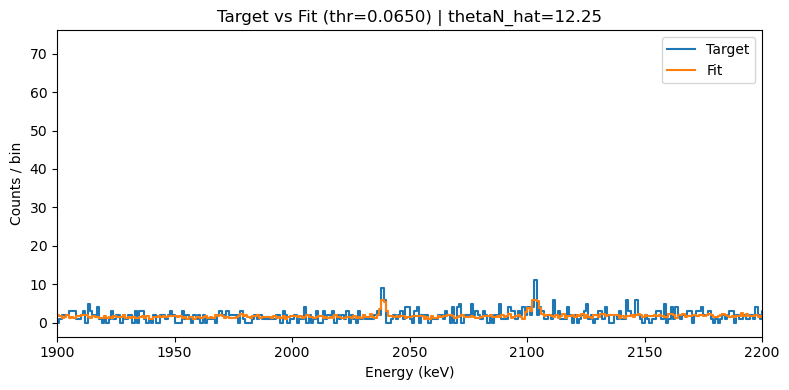

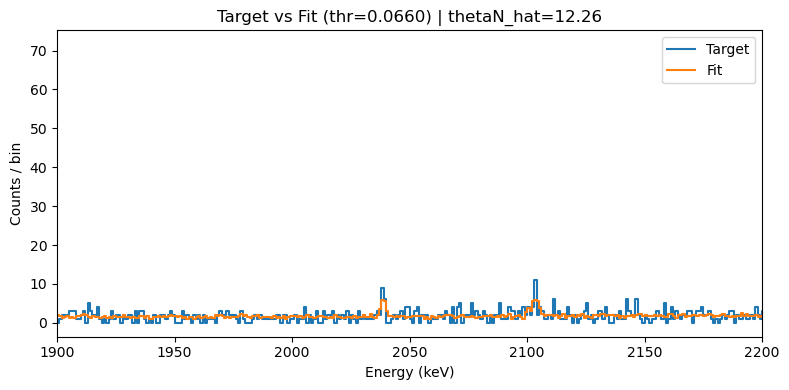

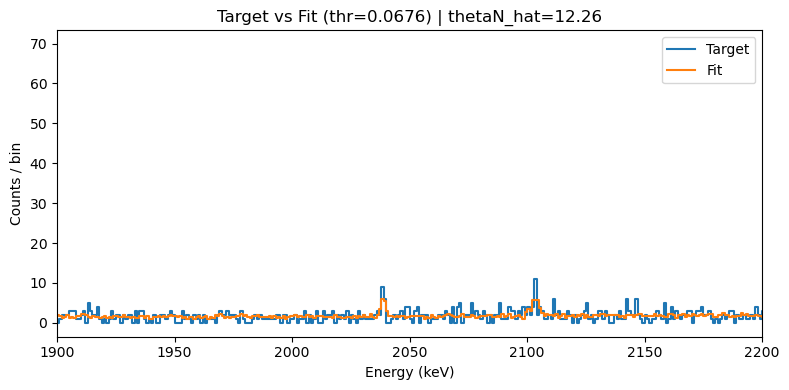

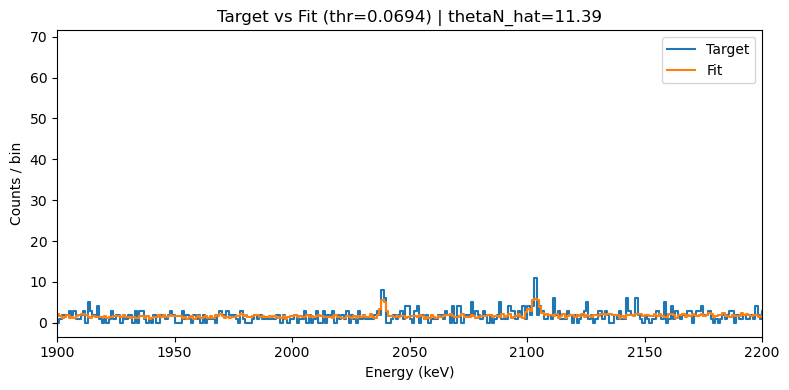

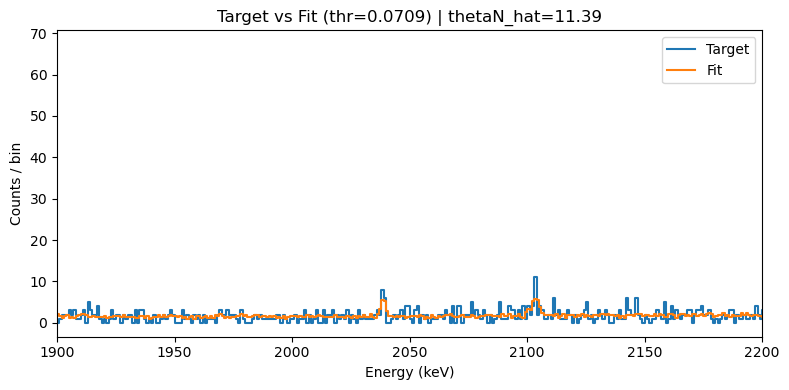

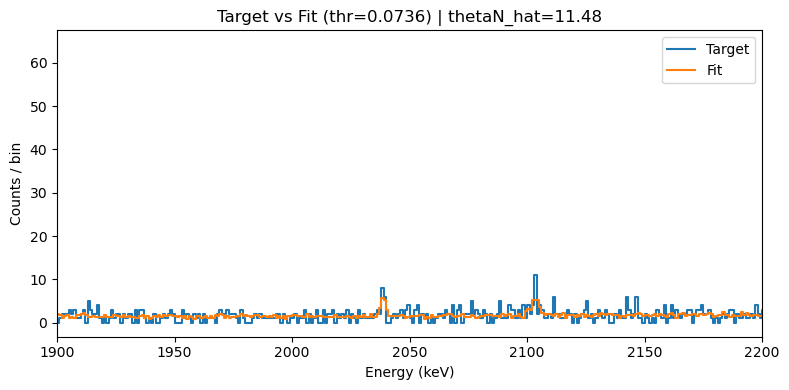

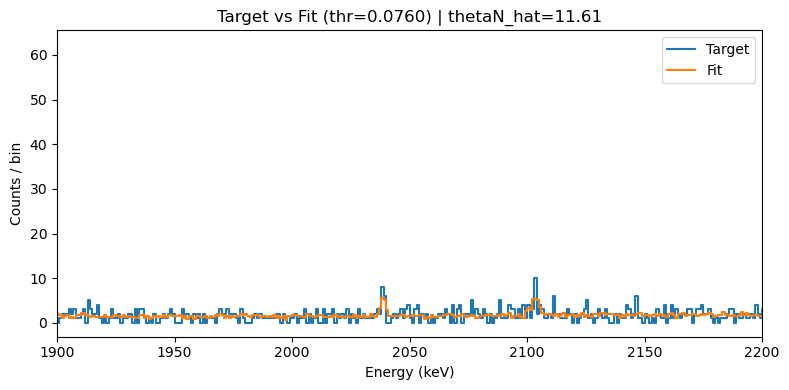

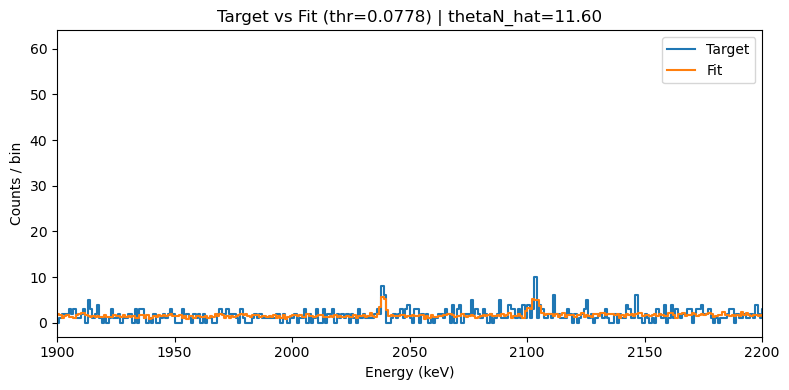

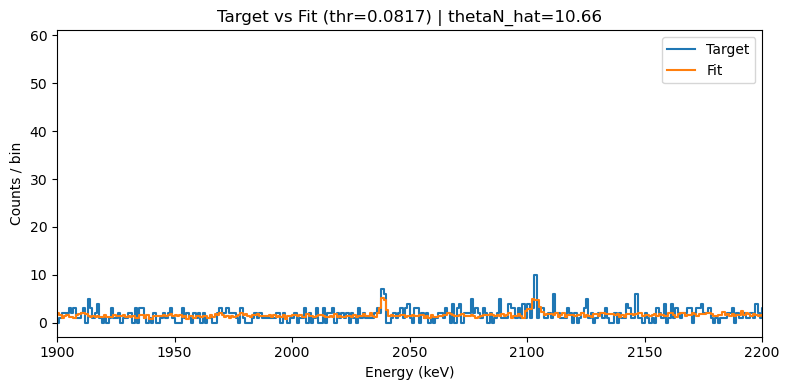

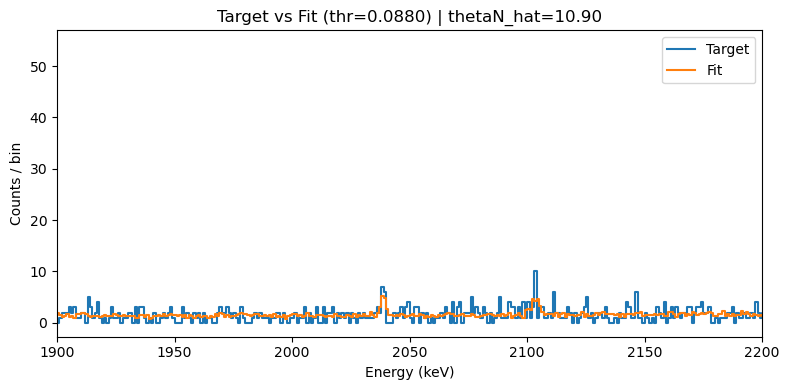

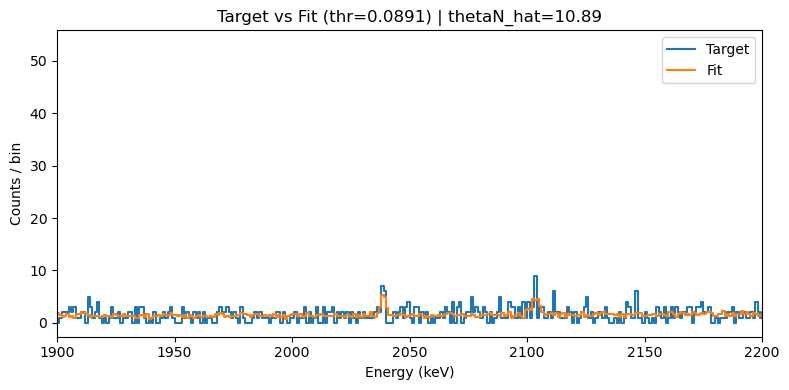

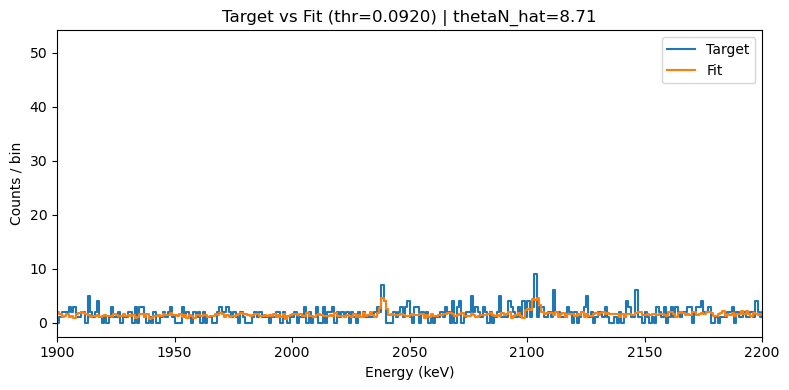

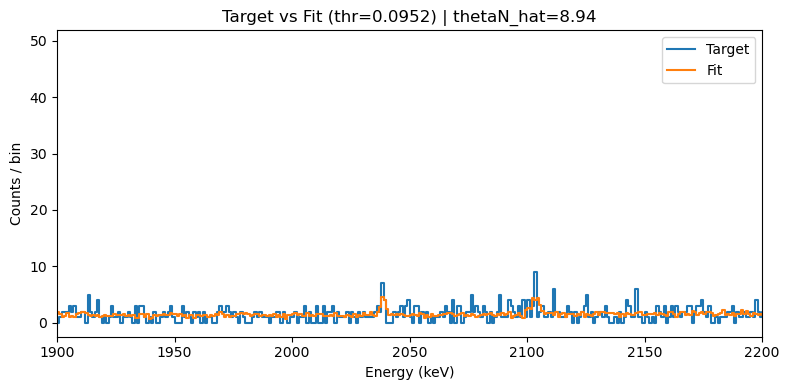

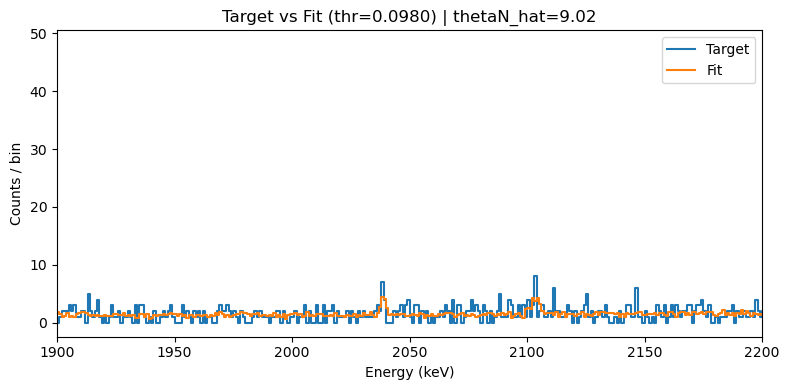

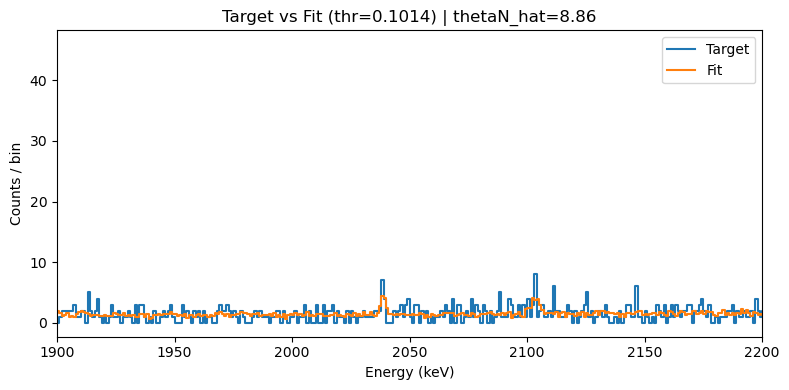

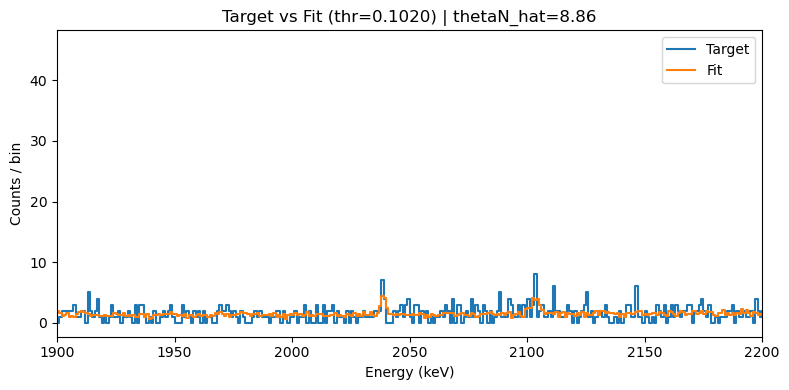

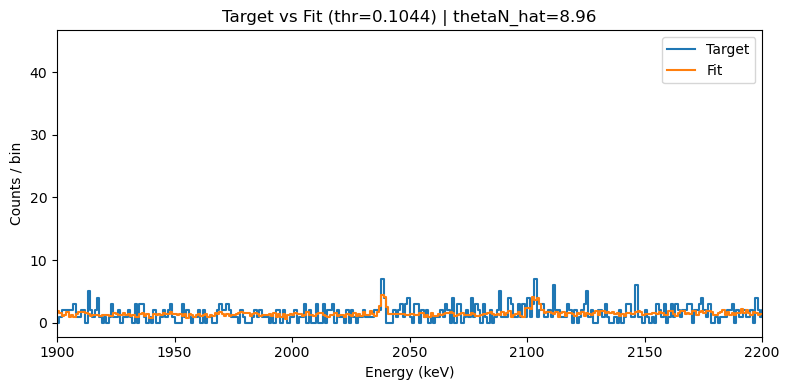

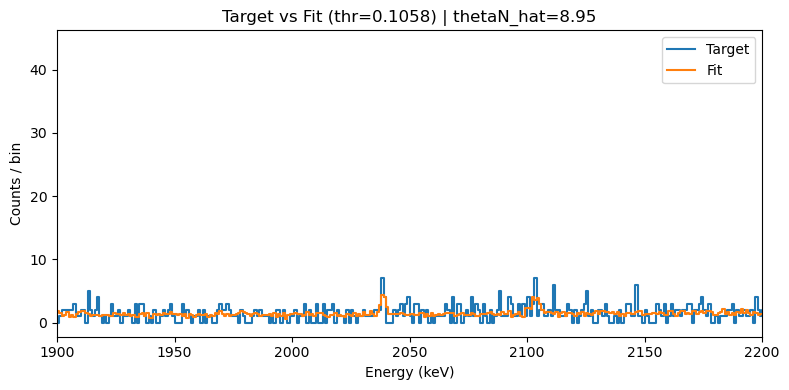

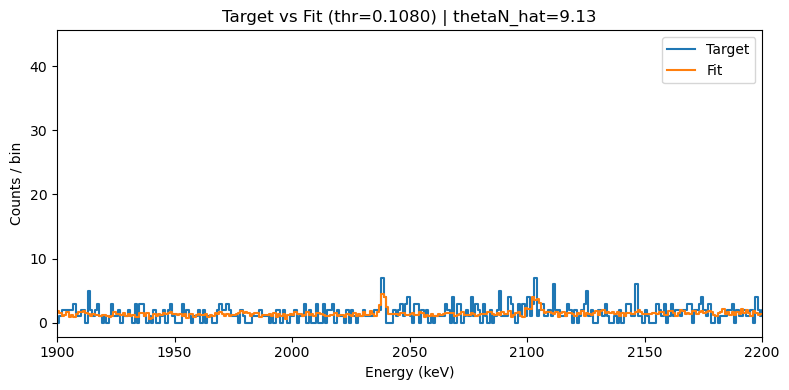

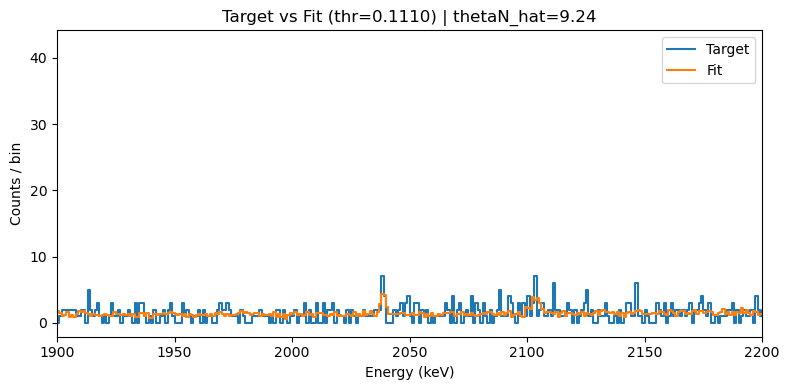

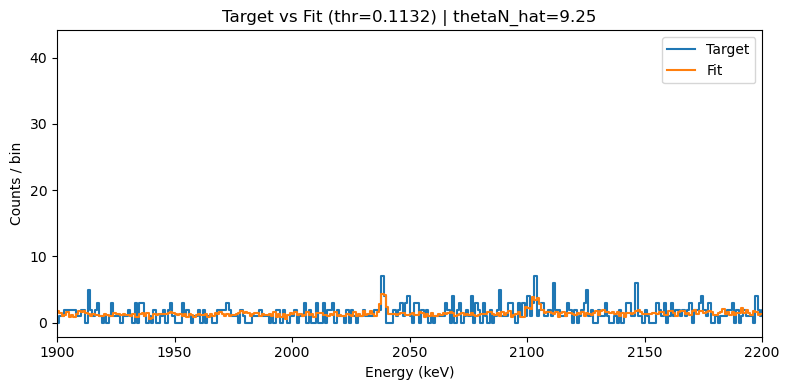

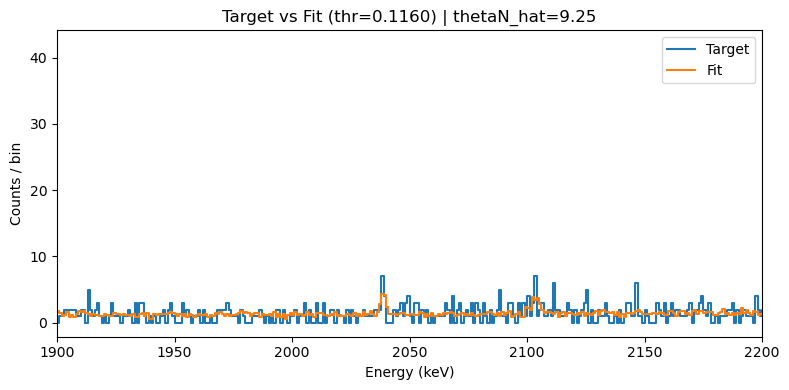

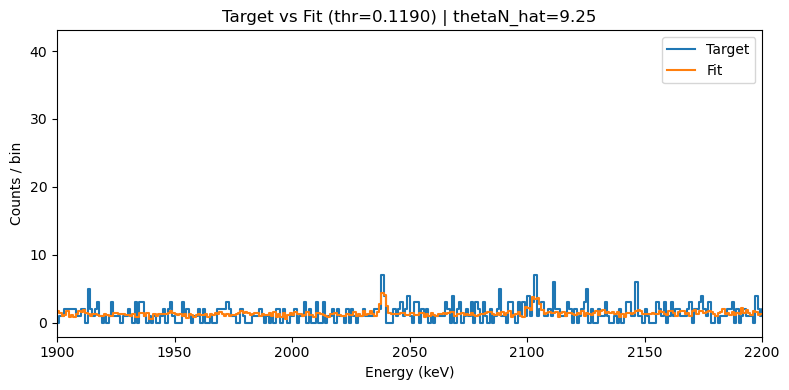

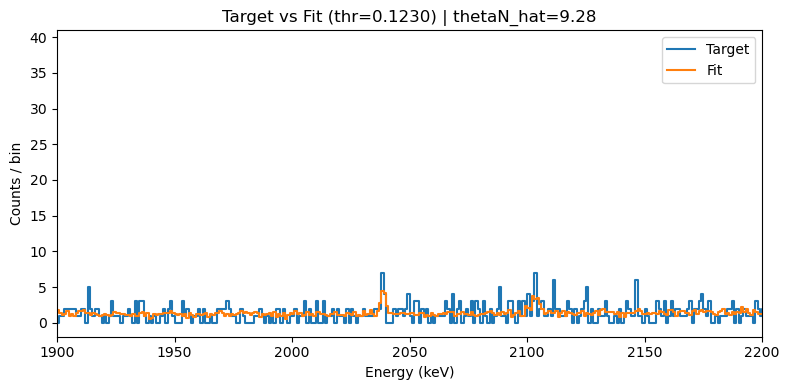

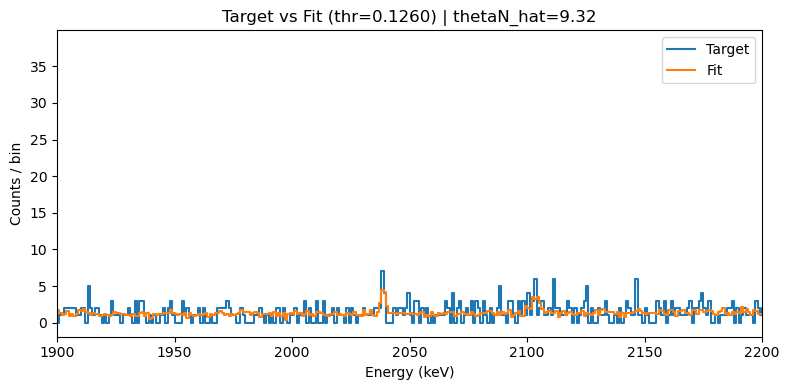

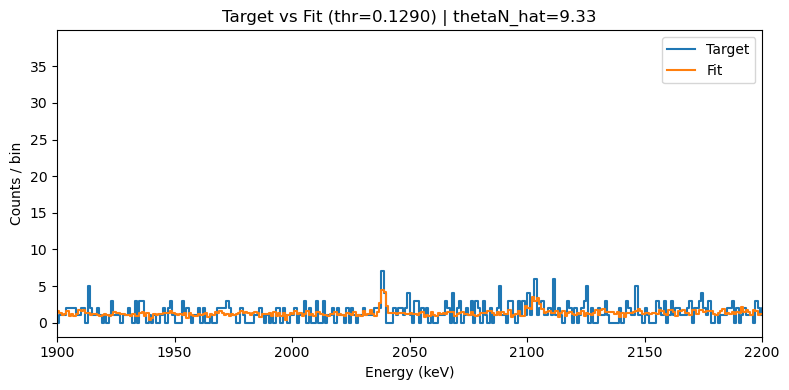

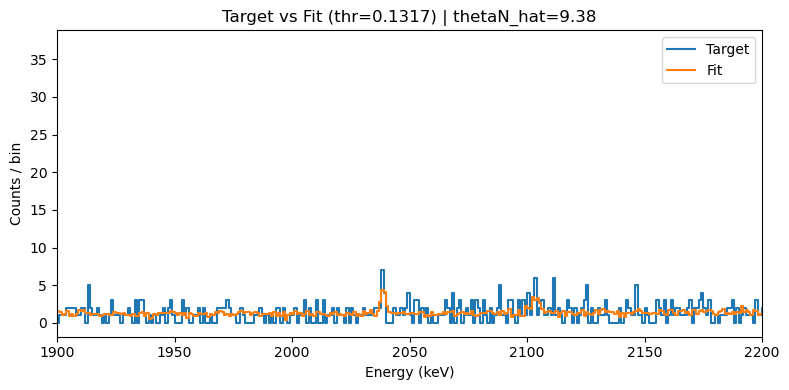

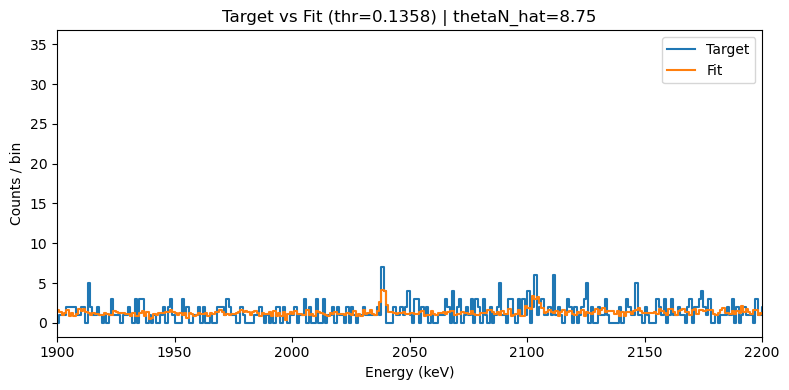

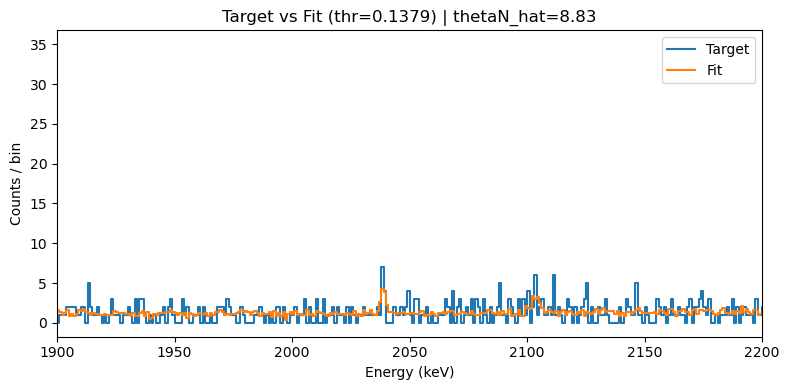

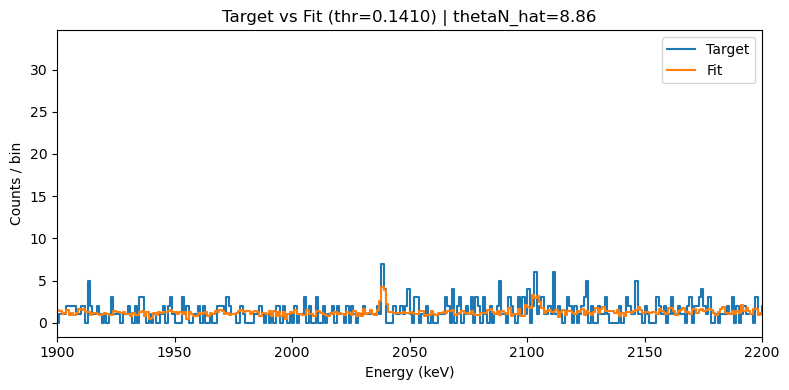

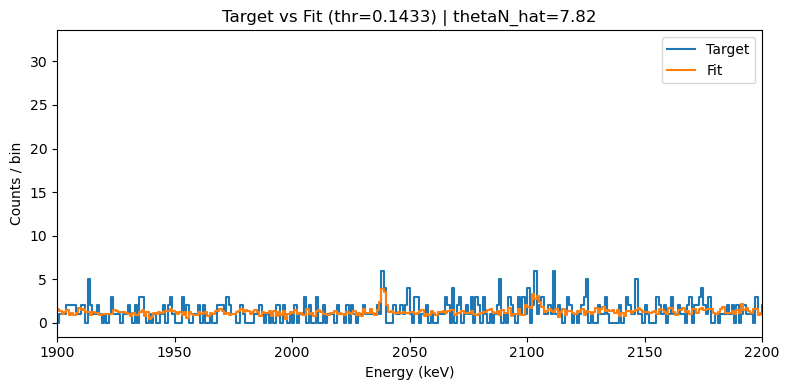

thr  fit_success    nll_min  thetaA_hat  thetaB_hat  thetaC_hat  thetaN_hat  Target_counts_sum
0   0.0560         True   437.5416   1213.7459    878.1503    806.2143     12.1475             2898.0
1   0.0570         True   474.1626   1218.4828    901.1685    749.6507     12.1769             2870.0
2   0.0580         True   500.9856   1212.0838    869.7536    773.5249     12.1682             2855.0
3   0.0597         True   534.6665   1204.1188    865.2729    756.8711     12.1775             2825.0
4   0.0616         True   561.4315   1188.3163    872.4645    734.9684     12.2340             2793.0
5   0.0620         True   561.4315   1188.3163    872.4645    734.9684     12.2340             2793.0
6   0.0640         True   577.3998   1180.6151    891.4499    689.1737     12.2522             2757.0
7   0.0650         True   583.6953   1176.8650    886.3042    683.5515     12.2473             2742.0
8   0.0660         True   596.9032   1179.2527    881.1225    671.1255     12.2587             2727.0
9   0.0676         True   612.0850   1177.3898    878.1871    660.2492     12.2612             2711.0
10  0.0694         True   632.5966   1177.3962    881.2156    632.9353     11.3862             2686.0
11  0.0709         True   643.0279   1174.6121    877.8137    622.4375     11.3886             2669.0
12  0.0736         True   698.1229   1173.8737    895.9754    560.8264     11.4753             2625.0
13  0.0760         True   736.0257   1168.4426    890.5702    540.1386     11.6077             2593.0
14  0.0778         True   757.1926   1166.2829    839.6753    563.0448     11.5990             2562.0
15  0.0817         True   840.8847   1159.2380    825.6731    526.9052     10.6619             2504.0
16  0.0880         True   907.9516   1142.1390    785.5603    509.9899     10.8974             2428.0
17  0.0891         True   933.2212   1138.3090    758.6673    518.3348     10.8910             2405.0
18  0.0920         True   955.6276   1137.7890    741.8359    513.0929      8.7054             2380.0
19  0.0952         True   968.6855   1135.6317    727.0206    490.1627      8.9416             2339.0
20  0.0980         True   985.4946   1130.6443    710.4807    484.2139      9.0205             2311.0
21  0.1014         True  1018.1018   1123.4730    670.3671    488.6186      8.8649             2267.0
22  0.1020         True  1018.1018   1123.4730    670.3671    488.6186      8.8649             2267.0
23  0.1044         True  1031.5594   1111.7705    661.8057    489.9445      8.9627             2247.0
24  0.1058         True  1036.0320   1110.7050    663.1473    481.6972      8.9509             2239.0
25  0.1080         True  1024.9556   1108.4129    655.7178    470.5519      9.1263             2217.0
26  0.1110         True  1042.5005   1114.2484    640.0806    447.8888      9.2433             2185.0
27  0.1132         True  1053.8181   1108.5939    633.7202    438.3948      9.2460             2163.0
28  0.1160         True  1062.0570   1102.2135    622.9935    435.1010      9.2475             2142.0
29  0.1190         True  1074.0849   1100.7293    623.3139    410.3613      9.2549             2116.0
30  0.1230         True  1097.8162   1095.0847    583.0638    423.9390      9.2778             2083.0
31  0.1260         True  1115.7523   1070.3626    578.5116    431.2760      9.3168             2059.0
32  0.1290         True  1131.5756   1056.3518    589.3244    412.4334      9.3335             2036.0
33  0.1317         True  1139.2324   1034.7833    565.4335    434.5916      9.3755             2011.0
34  0.1358         True  1177.0976   1024.6424    553.8743    424.6611      8.7470             1978.0
35  0.1379         True  1187.9795   1018.6398    549.1984    420.7960      8.8278             1963.0
36  0.1410         True  1204.1397   1019.1015    551.2740    401.1565      8.8622             1946.0
37  0.1433         True  1221.3495   1008.8132    518.8914    422.6959      7.8246             1923.0

In [14]:
# -----------------------------
# Step 6: apply ALL thresholds + plot + collect results
# -----------------------------
rows_step6 = []

for thr in THR_GRID_F:
    thr = float(thr)
    try:
        # Step5 for this thr
        y, pA, pB, pC = build_templates_for_thr(A, B, C, T, thr, edges)

        # Step6 fit
        fit = fit_target(y, pA, pB, pC, pN)

        rows_step6.append({
            "thr": thr,
            "fit_success": fit["success"],
            "nll_min": fit["fun"],
            "thetaA_hat": fit["thetaA"],
            "thetaB_hat": fit["thetaB"],
            "thetaC_hat": fit["thetaC"],
            "thetaN_hat": fit["thetaN"],
            "Target_counts_sum": float(np.sum(y)),
        })

        # plot (one per candidate)
        extra = f"thetaN_hat={fit['thetaN']:.2f}"
        plot_target_vs_fit(centers, y, fit["mu_hat"], thr, roi=ROI, extra_title=extra)

    except Exception as e:
        rows_step6.append({
            "thr": thr,
            "fit_success": False,
            "error": str(e),
        })
        print("thr failed:", thr, "| error:", e)

df_step6 = pd.DataFrame(rows_step6).sort_values("thr")
display(df_step6)

## Step 7:

In [15]:
Q_TARGET = 2.71 # Frequentist

def ul90_profile_for_templates(y, pA, pB, pC, pN,
                               thetaA_hat, thetaB_hat, thetaC_hat, thetaN_hat,
                               nll_min,
                               q_target=Q_TARGET,
                               make_plot=False,
                               plot_xlim=(0, 80),
                               n_grid=120):
    """
    Compute 90% UL on thetaN by profile likelihood:
      q(tN) = 2*(NLL_profile(tN) - NLL_min)
    Uses your existing profile_nll(...) that minimizes over (thetaA,thetaB,thetaC) for fixed tN.
    """

    x0_abc = np.array([thetaA_hat, thetaB_hat, thetaC_hat], float)

    def q_of_thetaN(tN):
        nll_t, _, _ = profile_nll(
            float(tN), y, pA, pB, pC, pN,
            THETA_A_MU, THETA_A_SIG, THETA_B_MU, THETA_B_SIG,
            x0_abc=x0_abc
        )
        q = 2.0 * (float(nll_t) - float(nll_min))
        return max(0.0, q)

    t0 = max(float(thetaN_hat), 0.0)
    eps = 1e-9

    # bracket UL on the right side of t0
    t_hi = max(10.0, t0 + 10.0)
    for _ in range(60):
        if q_of_thetaN(t_hi) >= q_target:
            break
        t_hi *= 2.0
    else:
        # failed to bracket
        ul90 = np.nan
        t_hi = float(t_hi)

    if np.isfinite(t_hi):
        try:
            ul90 = float(brentq(lambda t: q_of_thetaN(t) - q_target, t0 + eps, t_hi))
        except Exception:
            ul90 = np.nan

    # optional plot q curve
    if make_plot:
        xmax = max(plot_xlim[1], t_hi)
        grid = np.linspace(plot_xlim[0], xmax, n_grid)
        qs = np.array([q_of_thetaN(t) for t in grid], dtype=float)

        plt.figure(figsize=(7, 4))
        plt.plot(grid, qs)
        plt.axhline(q_target, linestyle="--", label="q=2.71")
        plt.axvline(t0, linestyle=":", label="thetaN_hat")
        if np.isfinite(ul90):
            plt.axvline(ul90, linestyle="--", label=f"UL90={ul90:.2f}")
        plt.xlabel(r"$\theta_{NLDBD}$")
        plt.ylabel(r"$q=-2\ln\lambda$")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return ul90

def profile_nll(thetaN_fixed, y, pA, pB, pC, pN,
                thetaA_mu, thetaA_sig, thetaB_mu, thetaB_sig,
                x0_abc=None,
                use_calib_penalty=True):
    """
    For a fixed thetaN, minimize NLL over (thetaA, thetaB, thetaC).
    Returns: (nll_min_profile, x_abc_hat, success)
    """
    thetaN_fixed = float(thetaN_fixed)

    if x0_abc is None:
        total = float(np.sum(y))
        x0_abc = np.array([thetaA_mu,
                           thetaB_mu,
                           max(total - thetaA_mu - thetaB_mu, 10.0)], float)
    x0_abc = np.array(x0_abc, float)

    bounds = [(0, None), (0, None), (0, None)]

    def obj(xabc):
        thetaA, thetaB, thetaC = xabc
        params = np.array([thetaA, thetaB, thetaC, thetaN_fixed], float)
        return nll_poisson_mixture(params, y, pA, pB, pC, pN,
                                   thetaA_mu, thetaA_sig, thetaB_mu, thetaB_sig,
                                   use_calib_penalty)

    res = minimize(obj, x0_abc, method="L-BFGS-B", bounds=bounds)
    return float(res.fun), res.x, bool(res.success)


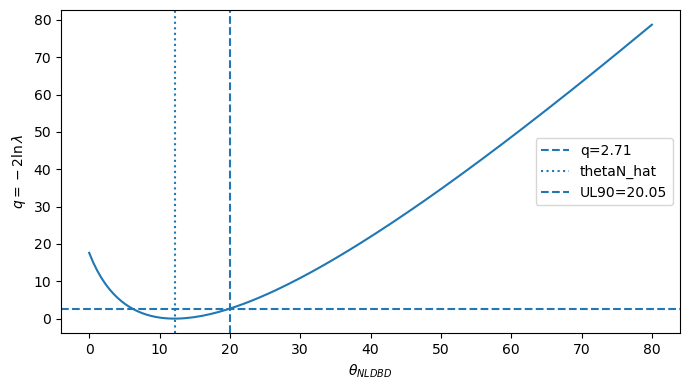

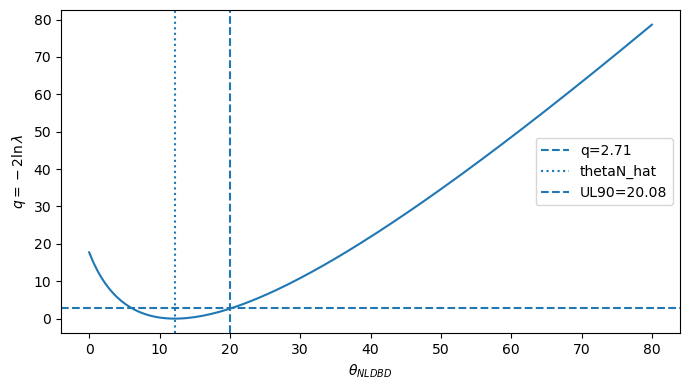

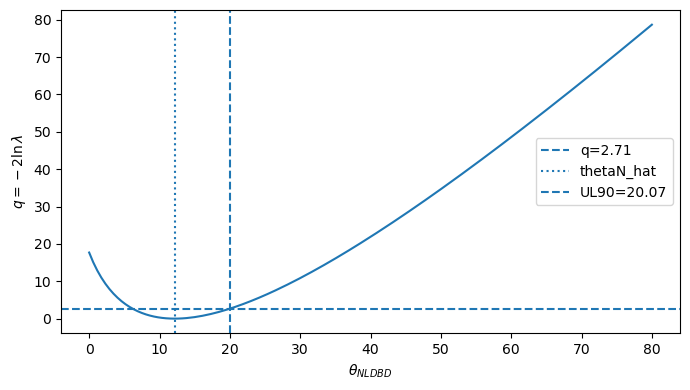

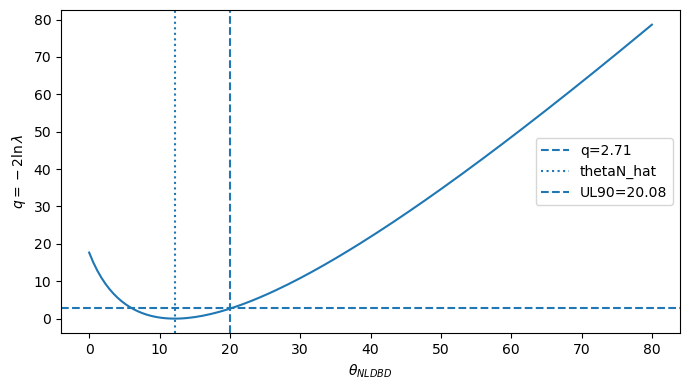

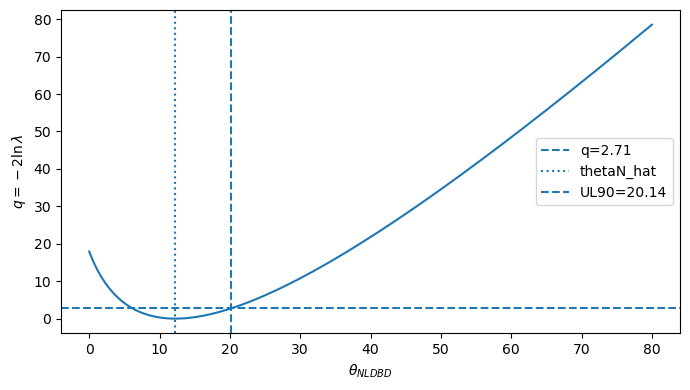

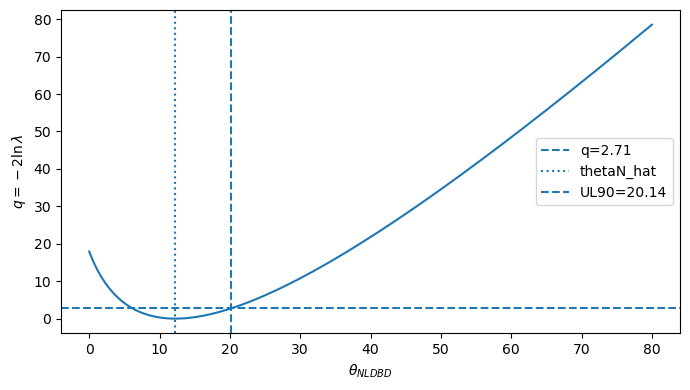

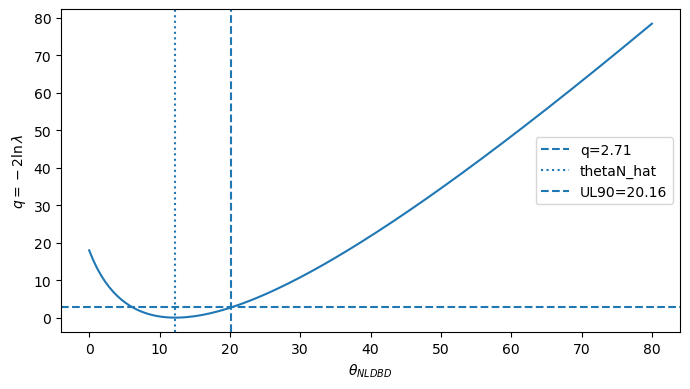

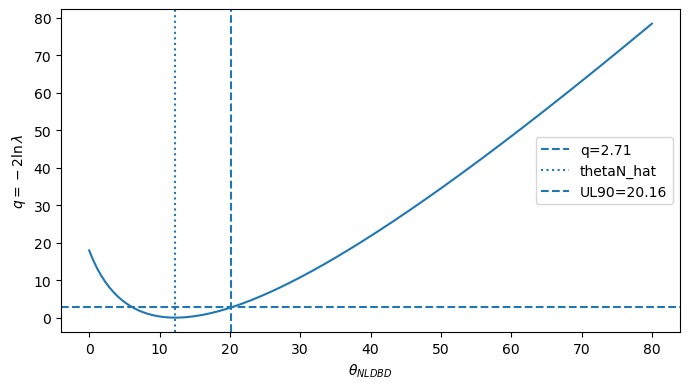

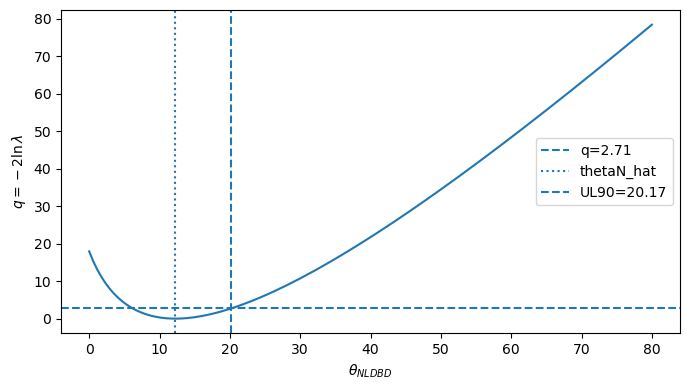

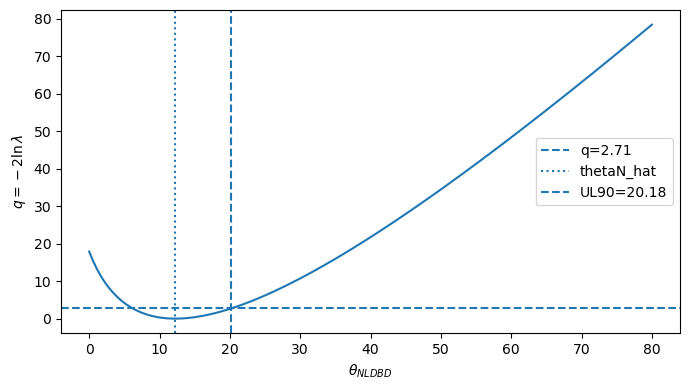

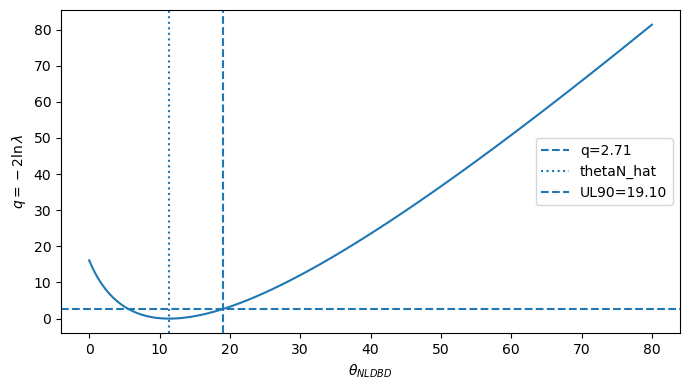

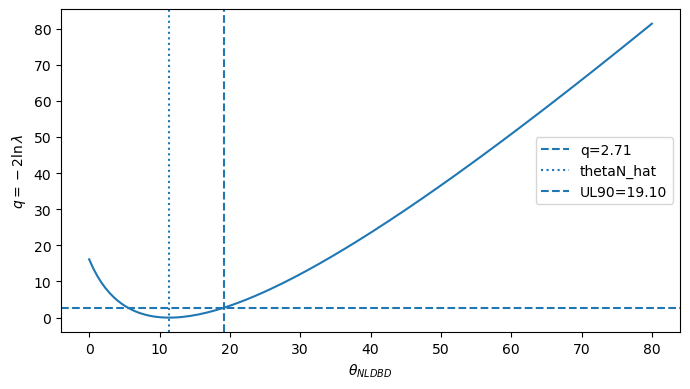

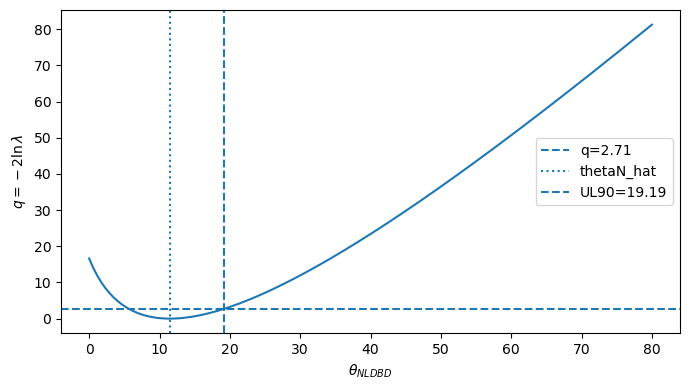

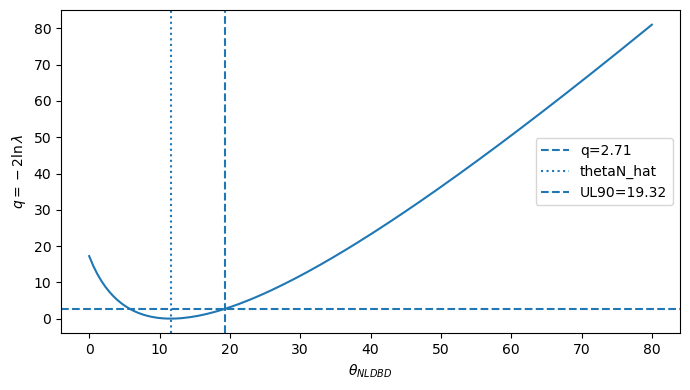

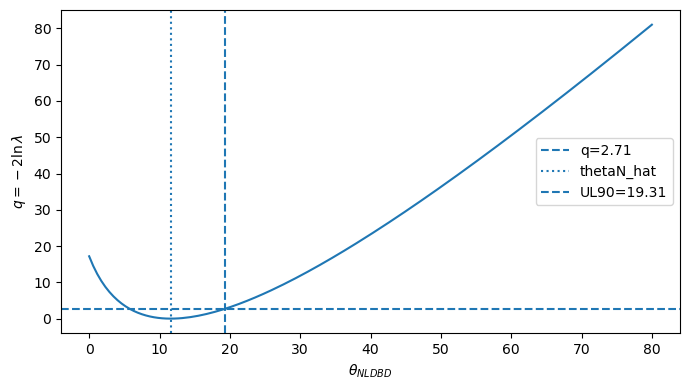

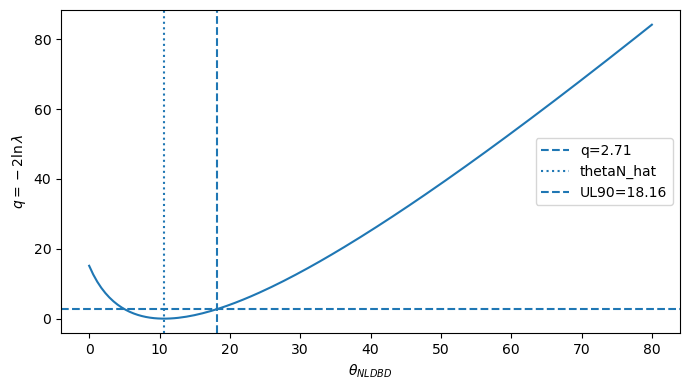

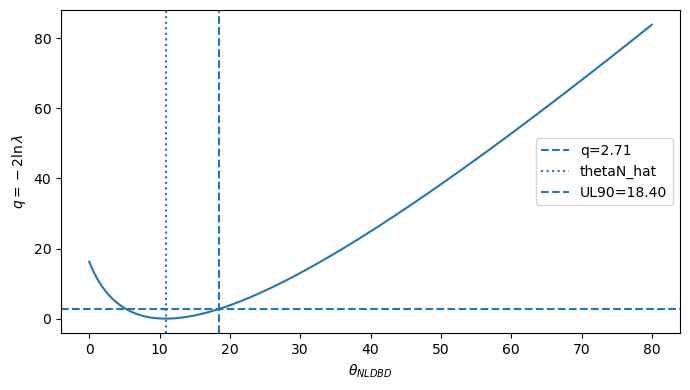

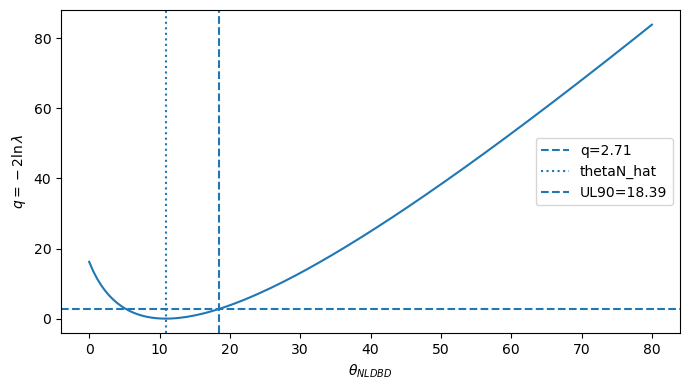

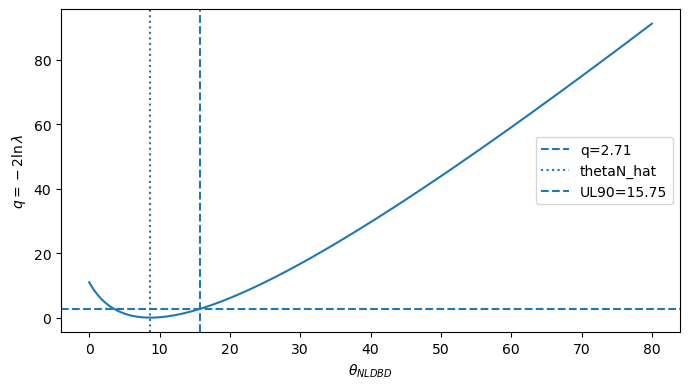

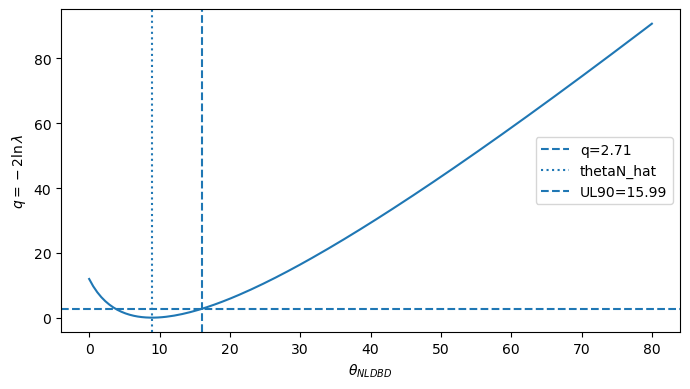

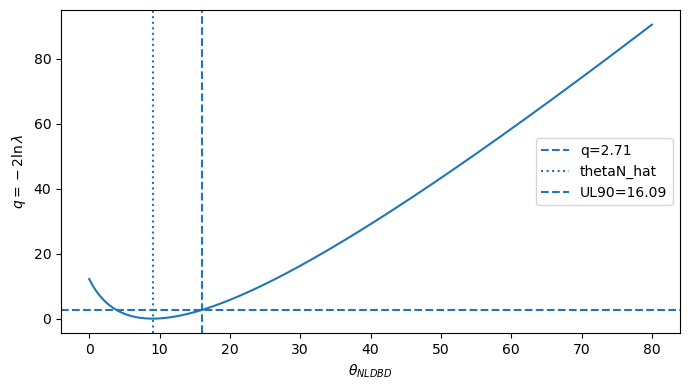

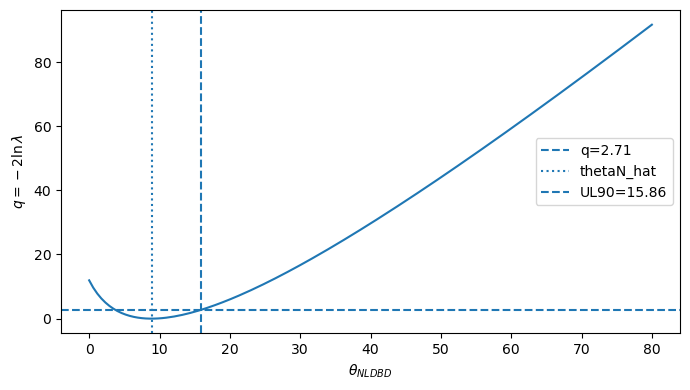

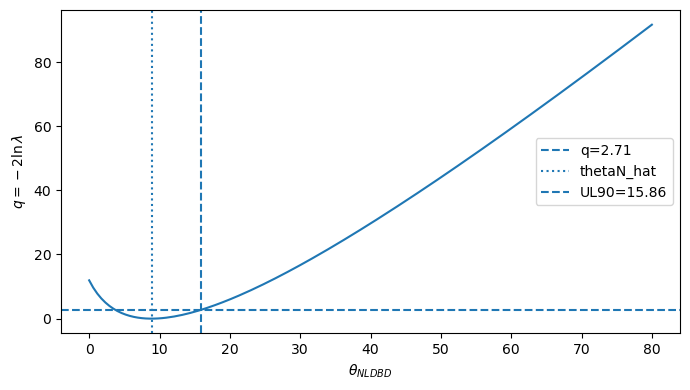

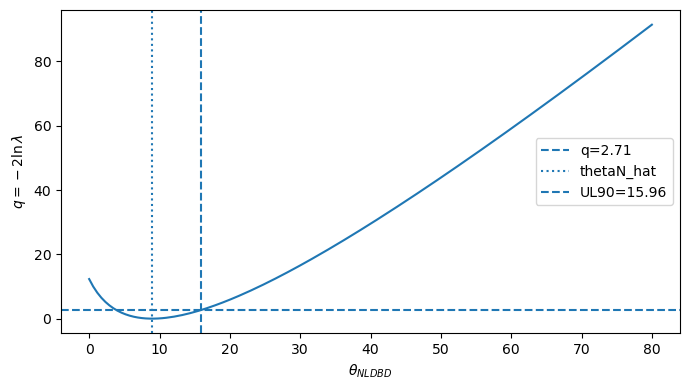

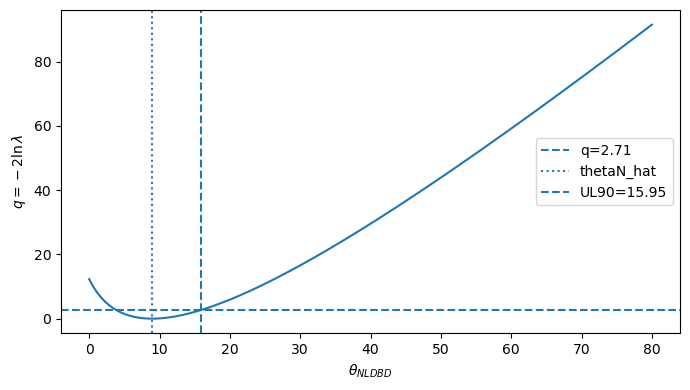

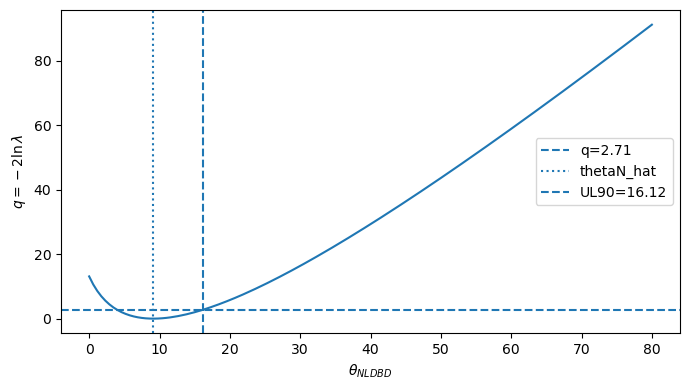

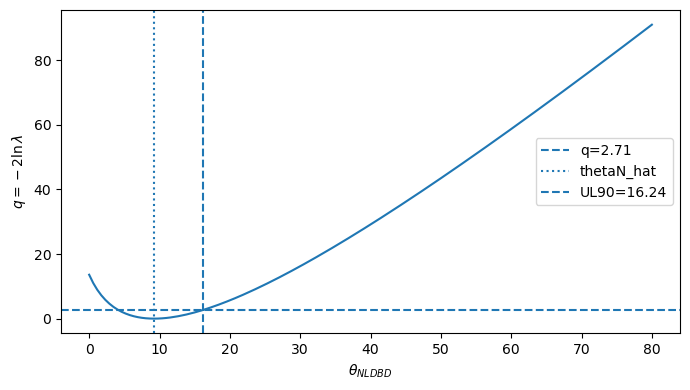

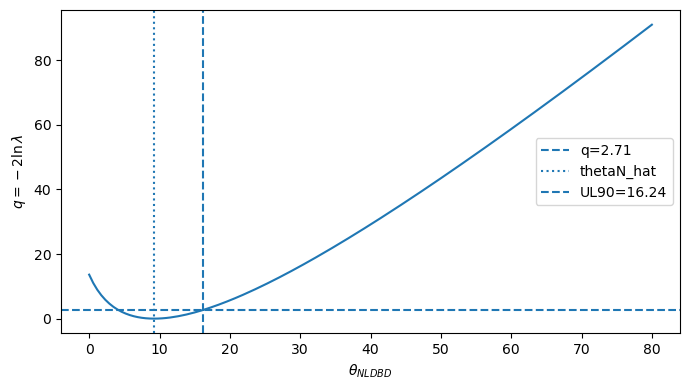

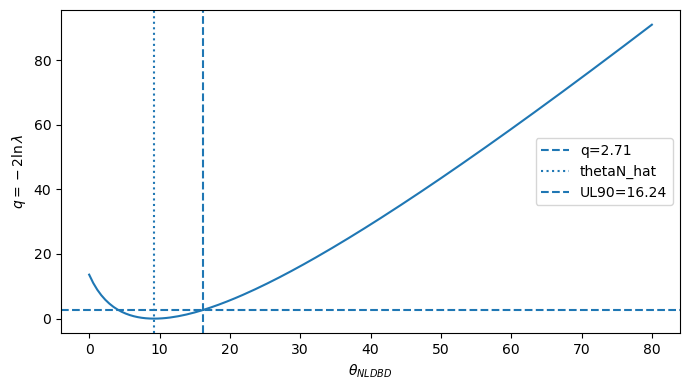

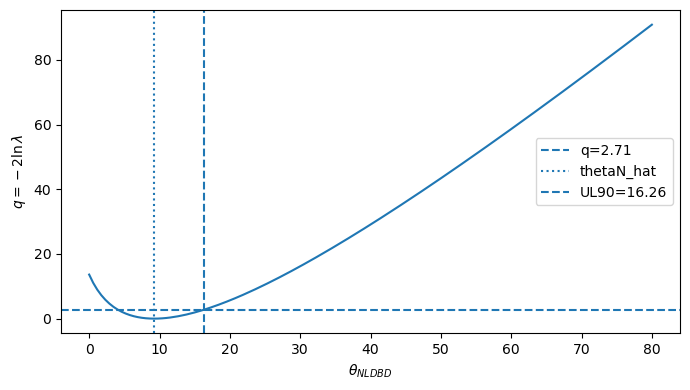

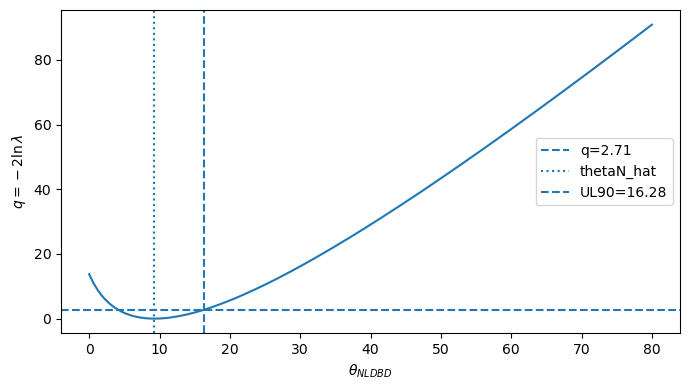

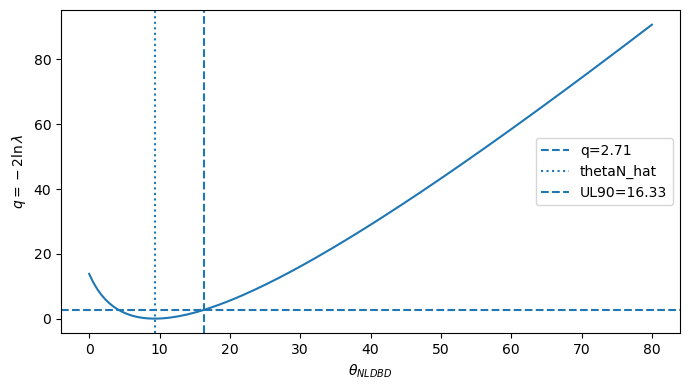

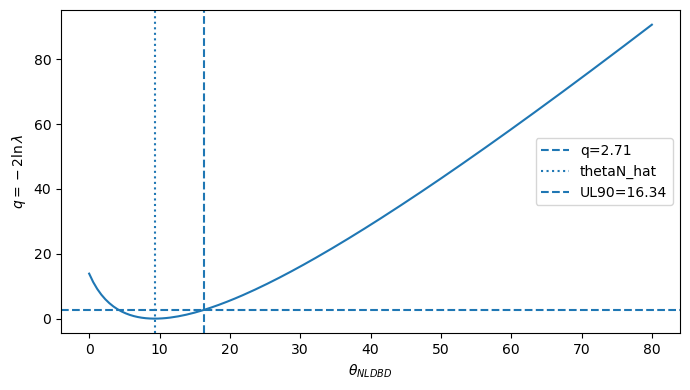

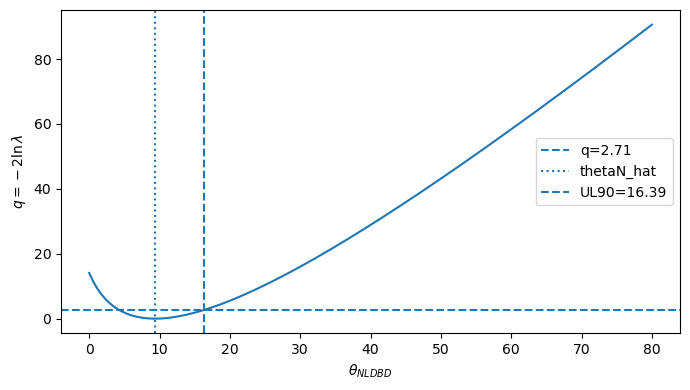

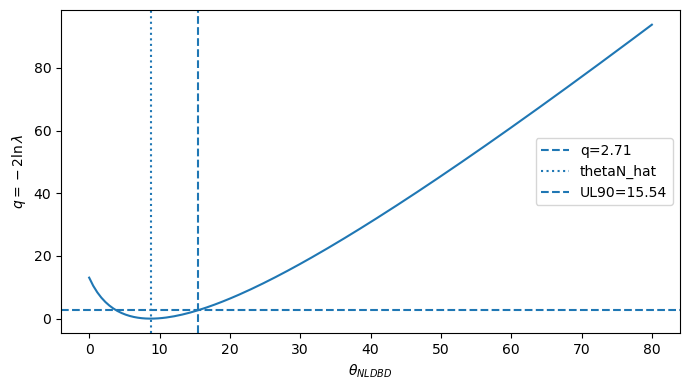

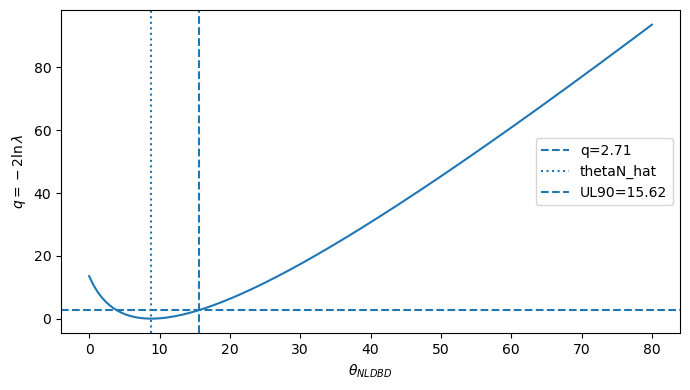

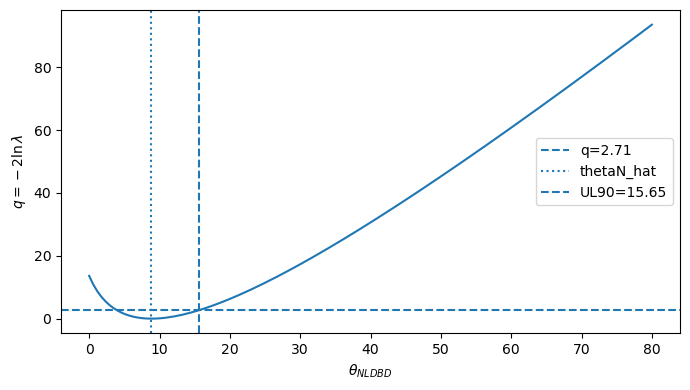

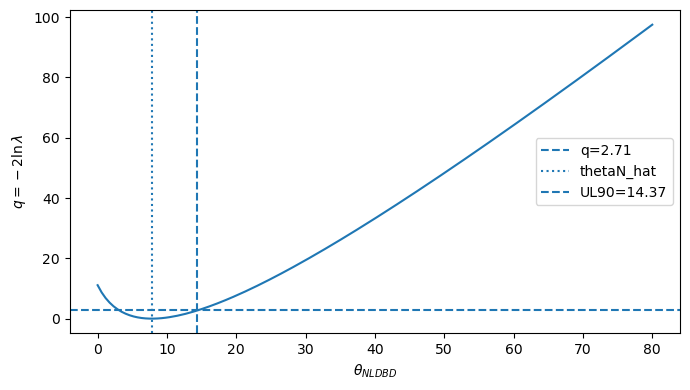

thr  TPR_A1592_net  FPR_B2103_net  fit_success  thetaN_hat     UL90    nll_min
0   0.0560         0.9490         0.2780         True     12.1475  20.0511   437.5416
1   0.0570         0.9465         0.2686         True     12.1769  20.0819   474.1626
2   0.0580         0.9417         0.2686         True     12.1682  20.0730   500.9856
3   0.0597         0.9368         0.2575         True     12.1775  20.0804   534.6665
4   0.0616         0.9344         0.2541         True     12.2340  20.1391   561.4315
5   0.0620         0.9344         0.2541         True     12.2340  20.1391   561.4315
6   0.0640         0.9283         0.2489         True     12.2522  20.1636   577.3998
7   0.0650         0.9247         0.2421         True     12.2473  20.1611   583.6953
8   0.0660         0.9198         0.2327         True     12.2587  20.1748   596.9032
9   0.0676         0.9149         0.2275         True     12.2612  20.1839   612.0850
10  0.0694         0.9101         0.2216         True     11.3862  19.0987   632.5966
11  0.0709         0.9064         0.2147         True     11.3886  19.1018   643.0279
12  0.0736         0.9016         0.2062         True     11.4753  19.1853   698.1229
13  0.0760         0.9004         0.2027         True     11.6077  19.3176   736.0257
14  0.0778         0.8943         0.1976         True     11.5990  19.3112   757.1926
15  0.0817         0.8943         0.1788         True     10.6619  18.1565   840.8847
16  0.0880         0.8967         0.1668         True     10.8974  18.4003   907.9516
17  0.0891         0.8870         0.1642         True     10.8910  18.3935   933.2212
18  0.0920         0.8882         0.1600         True      8.7054  15.7534   955.6276
19  0.0952         0.8797         0.1583         True      8.9416  15.9948   968.6855
20  0.0980         0.8797         0.1574         True      9.0205  16.0860   985.4946
21  0.1014         0.8748         0.1523         True      8.8649  15.8571  1018.1018
22  0.1020         0.8748         0.1523         True      8.8649  15.8571  1018.1018
23  0.1044         0.8615         0.1523         True      8.9627  15.9590  1031.5594
24  0.1058         0.8566         0.1514         True      8.9509  15.9519  1036.0320
25  0.1080         0.8542         0.1471         True      9.1263  16.1193  1024.9556
26  0.1110         0.8457         0.1446         True      9.2433  16.2366  1042.5005
27  0.1132         0.8433         0.1411         True      9.2460  16.2428  1053.8181
28  0.1160         0.8408         0.1369         True      9.2475  16.2447  1062.0570
29  0.1190         0.8360         0.1386         True      9.2549  16.2561  1074.0849
30  0.1230         0.8348         0.1343         True      9.2778  16.2804  1097.8162
31  0.1260         0.8287         0.1283         True      9.3168  16.3314  1115.7523
32  0.1290         0.8262         0.1198         True      9.3335  16.3434  1131.5756
33  0.1317         0.8226         0.1155         True      9.3755  16.3901  1139.2324
34  0.1358         0.8177         0.1138         True      8.7470  15.5360  1177.0976
35  0.1379         0.8129         0.1146         True      8.8278  15.6162  1187.9795
36  0.1410         0.8080         0.1163         True      8.8622  15.6533  1204.1397
37  0.1433         0.8007         0.1138         True      7.8246  14.3726  1221.3495

In [16]:
rows_step7 = []

for thr in THR_GRID_F:
    thr = float(thr)
    # Step5
    y, pA, pB, pC = build_templates_for_thr(A, B, C, T, thr, edges)

    # Step6
    fit = fit_target(y, pA, pB, pC, pN)
    if not fit["success"]:
        rows_step7.append({"thr": thr, "fit_success": False, "UL90": np.nan})
        continue

    # Step7
    ul90 = ul90_profile_for_templates(
        y, pA, pB, pC, pN,
        thetaA_hat=fit["thetaA"],
        thetaB_hat=fit["thetaB"],
        thetaC_hat=fit["thetaC"],
        thetaN_hat=fit["thetaN"],
        nll_min=fit["fun"],
        make_plot=True,    # plot every candidate figure
        plot_xlim=(0, 80),
        n_grid=140
    )

    rows_step7.append({
        "thr": thr,
        "fit_success": True,
        "thetaN_hat": fit["thetaN"],
        "UL90": ul90,
        "nll_min": fit["fun"],
    })

df_step7 = pd.DataFrame(rows_step7).sort_values("thr")
df_step7_merged = df_filt.merge(df_step7, on="thr", how="left").sort_values("thr")
display(df_step7_merged)


## Step 8:

In [17]:
# ==========================================================
# Step 8: Sensitivity function (median expected UL90 under thetaN=0)
# ==========================================================
RNG_SEED = 0
N_TOYS = 200
def sensitivity_for_templates(y_data, pA, pB, pC, pN,
                              n_toys=N_TOYS, seed=RNG_SEED,
                              make_hist=False):
    """
    Sensitivity = median expected 90% UL on thetaN under thetaN_true = 0.
    We take thetaA/B/C true from a profiled fit at thetaN=0,
    then generate toys and compute UL90 for each toy via profile likelihood (brentq).
    """
    rng = np.random.default_rng(seed)

    # 1) get "truth" thetaA/B/C under thetaN=0 via profile fit
    nll0, xabc0, ok = profile_nll(
        0.0, y_data, pA, pB, pC, pN,
        THETA_A_MU, THETA_A_SIG, THETA_B_MU, THETA_B_SIG,
        x0_abc=np.array([THETA_A_MU, THETA_B_MU, 10.0], float)
    )
    if not ok:
        return np.nan, []

    thetaA0, thetaB0, thetaC0 = xabc0
    mu_true = thetaA0*pA + thetaB0*pB + thetaC0*pC  # thetaN_true = 0
    mu_true = np.clip(mu_true, 1e-12, None)

    # 2) toys: UL90 each
    ULs = []
    for _ in range(n_toys):
        y_toy = rng.poisson(mu_true)

        # need a full fit on this toy to get (theta_hat, nll_min)
        fit_toy = fit_target(y_toy, pA, pB, pC, pN)
        if not fit_toy["success"]:
            continue

        ul = ul90_profile_for_templates(
            y_toy, pA, pB, pC, pN,
            thetaA_hat=fit_toy["thetaA"],
            thetaB_hat=fit_toy["thetaB"],
            thetaC_hat=fit_toy["thetaC"],
            thetaN_hat=fit_toy["thetaN"],
            nll_min=fit_toy["fun"],
            make_plot=False
        )
        if np.isfinite(ul):
            ULs.append(float(ul))

    sens = float(np.median(ULs)) if len(ULs) else np.nan

    # optional hist plot (for a single thr)
    if make_hist:
        plt.figure()
        plt.hist(ULs, bins=30)
        plt.xlabel("Toy 90% UL on thetaNLDBD")
        plt.ylabel("Counts")
        plt.title(f"Sensitivity toys (median={sens:.3f}, n={len(ULs)})")
        plt.tight_layout()
        plt.show()

    return sens, ULs


In [18]:
# quick scan setup
N_TOYS_QUICK = 30
rows_step8 = []


for thr in THR_GRID_F:
    thr = float(thr)

    # Step5 templates for this thr
    y, pA, pB, pC = build_templates_for_thr(A, B, C, T, thr, edges)

    # Step8 sensitivity for this thr
    sens, _ = sensitivity_for_templates(
        y, pA, pB, pC, pN,
        n_toys=N_TOYS_QUICK,
        seed=RNG_SEED,
        make_hist=False
    )

    rows_step8.append({"thr": thr, "Sensitivity_median_UL": sens})

df_step8 = pd.DataFrame(rows_step8).sort_values("thr")
df_step8_merged = df_filt.merge(df_step8, on="thr", how="left").sort_values("thr")
display(df_step8_merged)


thr  TPR_A1592_net  FPR_B2103_net  Sensitivity_median_UL
0   0.0560         0.9490         0.2780                 3.7485
1   0.0570         0.9465         0.2686                 3.8631
2   0.0580         0.9417         0.2686                 4.4975
3   0.0597         0.9368         0.2575                 3.8946
4   0.0616         0.9344         0.2541                 4.5061
5   0.0620         0.9344         0.2541                 4.5061
6   0.0640         0.9283         0.2489                 6.4476
7   0.0650         0.9247         0.2421                 4.5631
8   0.0660         0.9198         0.2327                 4.6157
9   0.0676         0.9149         0.2275                 4.1057
10  0.0694         0.9101         0.2216                 4.9555
11  0.0709         0.9064         0.2147                 5.5022
12  0.0736         0.9016         0.2062                 4.7643
13  0.0760         0.9004         0.2027                 5.5922
14  0.0778         0.8943         0.1976                 4.3279
15  0.0817         0.8943         0.1788                 5.1217
16  0.0880         0.8967         0.1668                 4.5118
17  0.0891         0.8870         0.1642                 3.2355
18  0.0920         0.8882         0.1600                 5.0175
19  0.0952         0.8797         0.1583                 5.0486
20  0.0980         0.8797         0.1574                 3.7873
21  0.1014         0.8748         0.1523                 4.2400
22  0.1020         0.8748         0.1523                 4.2400
23  0.1044         0.8615         0.1523                 4.5765
24  0.1058         0.8566         0.1514                 4.9376
25  0.1080         0.8542         0.1471                 3.5274
26  0.1110         0.8457         0.1446                 4.1689
27  0.1132         0.8433         0.1411                 3.8572
28  0.1160         0.8408         0.1369                 3.3646
29  0.1190         0.8360         0.1386                 3.8053
30  0.1230         0.8348         0.1343                 4.4574
31  0.1260         0.8287         0.1283                 4.3550
32  0.1290         0.8262         0.1198                 3.6004
33  0.1317         0.8226         0.1155                 4.0374
34  0.1358         0.8177         0.1138                 4.6608
35  0.1379         0.8129         0.1146                 4.7379
36  0.1410         0.8080         0.1163                 4.0971
37  0.1433         0.8007         0.1138                 3.3860

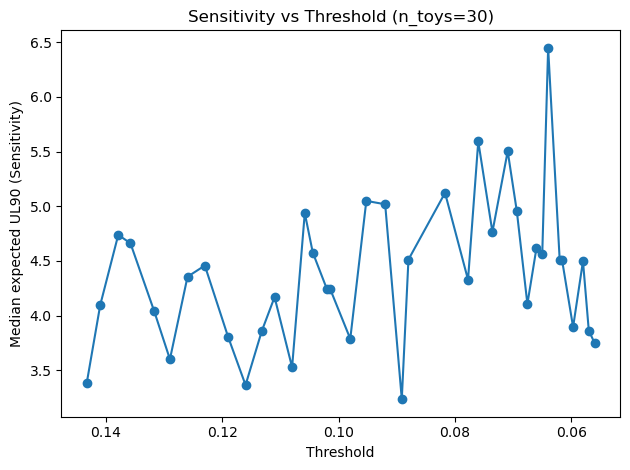

In [19]:
df_ok8 = df_step8_merged[np.isfinite(df_step8_merged["Sensitivity_median_UL"])]

plt.figure()
plt.plot(df_ok8["thr"], df_ok8["Sensitivity_median_UL"], marker="o")
plt.gca().invert_xaxis()
plt.xlabel("Threshold")
plt.ylabel("Median expected UL90 (Sensitivity)")
plt.title(f"Sensitivity vs Threshold (n_toys={N_TOYS_QUICK})")
plt.tight_layout()
plt.show()


Best thr (quick) = 0.089144578313253


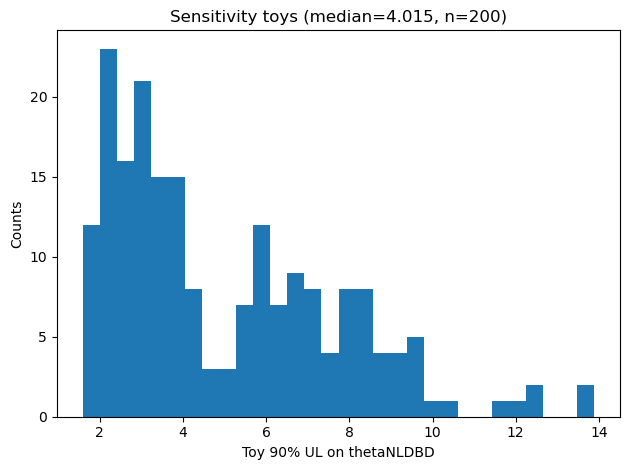

Final sensitivity (median expected UL) = 4.01496701961757


In [20]:
best_thr = float(df_ok8.loc[df_ok8["Sensitivity_median_UL"].idxmin(), "thr"])
print("Best thr (quick) =", best_thr)

y, pA, pB, pC = build_templates_for_thr(A, B, C, T, best_thr, edges)
sens_final, ULs = sensitivity_for_templates(
    y, pA, pB, pC, pN,
    n_toys=200,
    seed=RNG_SEED,
    make_hist=True
)
print("Final sensitivity (median expected UL) =", sens_final)


In [21]:
# =========================
# Final report for best_thr
# =========================

# Step5 (best_thr)
y_best, pA_best, pB_best, pC_best = build_templates_for_thr(A, B, C, T, best_thr, edges)

# Step6 fit (best_thr)
fit_best = fit_target(y_best, pA_best, pB_best, pC_best, pN)

# Step7 observed UL90 (best_thr)
ul_obs_best = ul90_profile_for_templates(
    y_best, pA_best, pB_best, pC_best, pN,
    thetaA_hat=fit_best["thetaA"],
    thetaB_hat=fit_best["thetaB"],
    thetaC_hat=fit_best["thetaC"],
    thetaN_hat=fit_best["thetaN"],
    nll_min=fit_best["fun"],
    make_plot=False
)

# TPR/FPR lookup (if df_filt available)
tpr_best = fpr_best = None
if "df_filt" in globals():
    row = df_filt.loc[np.isclose(df_filt["thr"].values, best_thr)]
    if len(row):
        tpr_best = float(row.iloc[0]["TPR_A1592_net"])
        fpr_best = float(row.iloc[0]["FPR_B2103_net"])

print("===== BEST THRESHOLD SUMMARY =====")
print(f"best_thr = {best_thr:.6f}")
if tpr_best is not None:
    print(f"TPR(A@1592±{PEAK_HALF_WIDTH}) = {tpr_best:.4f}")
if fpr_best is not None:
    print(f"FPR(B@2103±{PEAK_HALF_WIDTH}) = {fpr_best:.4f}")

print("\n--- Fit (Step6) ---")
print("Fit success:", fit_best["success"])
print(f"thetaA_hat = {fit_best['thetaA']:.2f}   (calib {THETA_A_MU}±{THETA_A_SIG})")
print(f"thetaB_hat = {fit_best['thetaB']:.2f}   (calib {THETA_B_MU}±{THETA_B_SIG})")
print(f"thetaC_hat = {fit_best['thetaC']:.2f}")
print(f"thetaN_hat = {fit_best['thetaN']:.2f}")
print(f"NLL_min    = {fit_best['fun']:.3f}")
print(f"Target total counts after cut = {float(np.sum(y_best)):.1f}")

print("\n--- Observed UL (Step7) ---")
print(f"Observed 90% UL on thetaNLDBD = {ul_obs_best:.4f}")

print("\n--- Sensitivity (Step8) ---")
print(f"Sensitivity (median expected UL) = {sens_final:.4f}  (toys used: {len(ULs)})")


===== BEST THRESHOLD SUMMARY =====
best_thr = 0.089145
TPR(A@1592±3.0) = 0.8870
FPR(B@2103±3.0) = 0.1642

--- Fit (Step6) ---
Fit success: True
thetaA_hat = 1138.31   (calib 1350.0±100.0)
thetaB_hat = 758.67   (calib 770.0±270.0)
thetaC_hat = 518.33
thetaN_hat = 10.89
NLL_min    = 933.221
Target total counts after cut = 2405.0

--- Observed UL (Step7) ---
Observed 90% UL on thetaNLDBD = 18.3935

--- Sensitivity (Step8) ---
Sensitivity (median expected UL) = 4.0150  (toys used: 200)


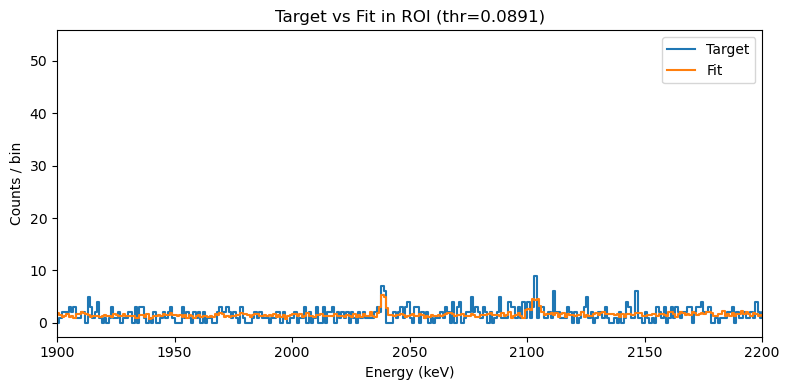

In [22]:
ROI = (1900, 2200)

plt.figure(figsize=(8,4))
plt.step(centers, y_best, where="mid", label="Target")
plt.step(centers, fit_best["mu_hat"], where="mid", label="Fit")
plt.xlim(*ROI)
plt.xlabel("Energy (keV)")
plt.ylabel("Counts / bin")
plt.title(f"Target vs Fit in ROI (thr={best_thr:.4f})")
plt.legend()
plt.tight_layout()
plt.show()

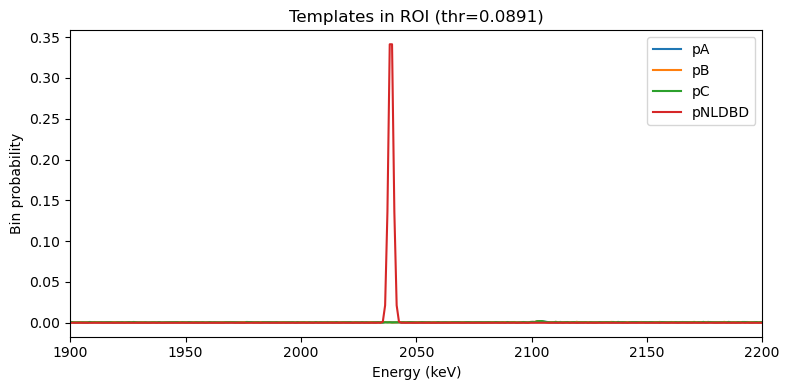

In [23]:
plt.figure(figsize=(8,4))
plt.plot(centers, pA_best, label="pA")
plt.plot(centers, pB_best, label="pB")
plt.plot(centers, pC_best, label="pC")
plt.plot(centers, pN, label="pNLDBD")
plt.xlim(*ROI)
plt.xlabel("Energy (keV)")
plt.ylabel("Bin probability")
plt.title(f"Templates in ROI (thr={best_thr:.4f})")
plt.legend()
plt.tight_layout()
plt.show()


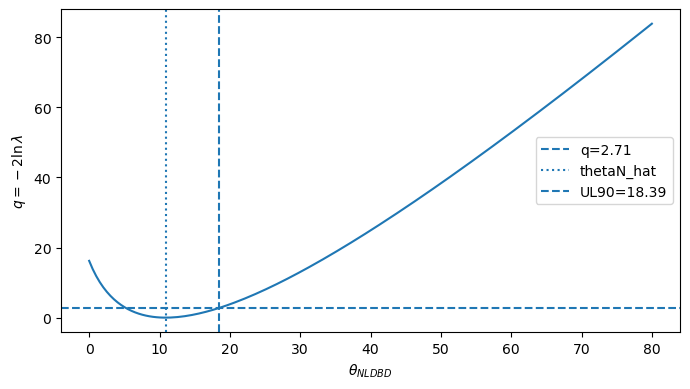

In [24]:
_ = ul90_profile_for_templates(
    y_best, pA_best, pB_best, pC_best, pN,
    thetaA_hat=fit_best["thetaA"],
    thetaB_hat=fit_best["thetaB"],
    thetaC_hat=fit_best["thetaC"],
    thetaN_hat=fit_best["thetaN"],
    nll_min=fit_best["fun"],
    make_plot=True,
    plot_xlim=(0, max(80, ul_obs_best*1.3 if np.isfinite(ul_obs_best) else 80)),
    n_grid=160
)


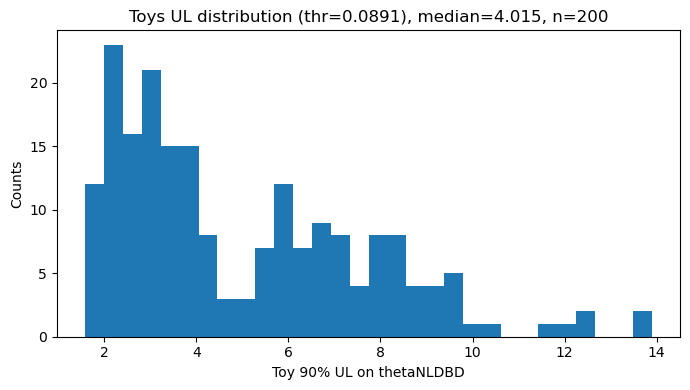

In [25]:
plt.figure(figsize=(7,4))
plt.hist(ULs, bins=30)
plt.xlabel("Toy 90% UL on thetaNLDBD")
plt.ylabel("Counts")
plt.title(f"Toys UL distribution (thr={best_thr:.4f}), median={sens_final:.3f}, n={len(ULs)}")
plt.tight_layout()
plt.show()


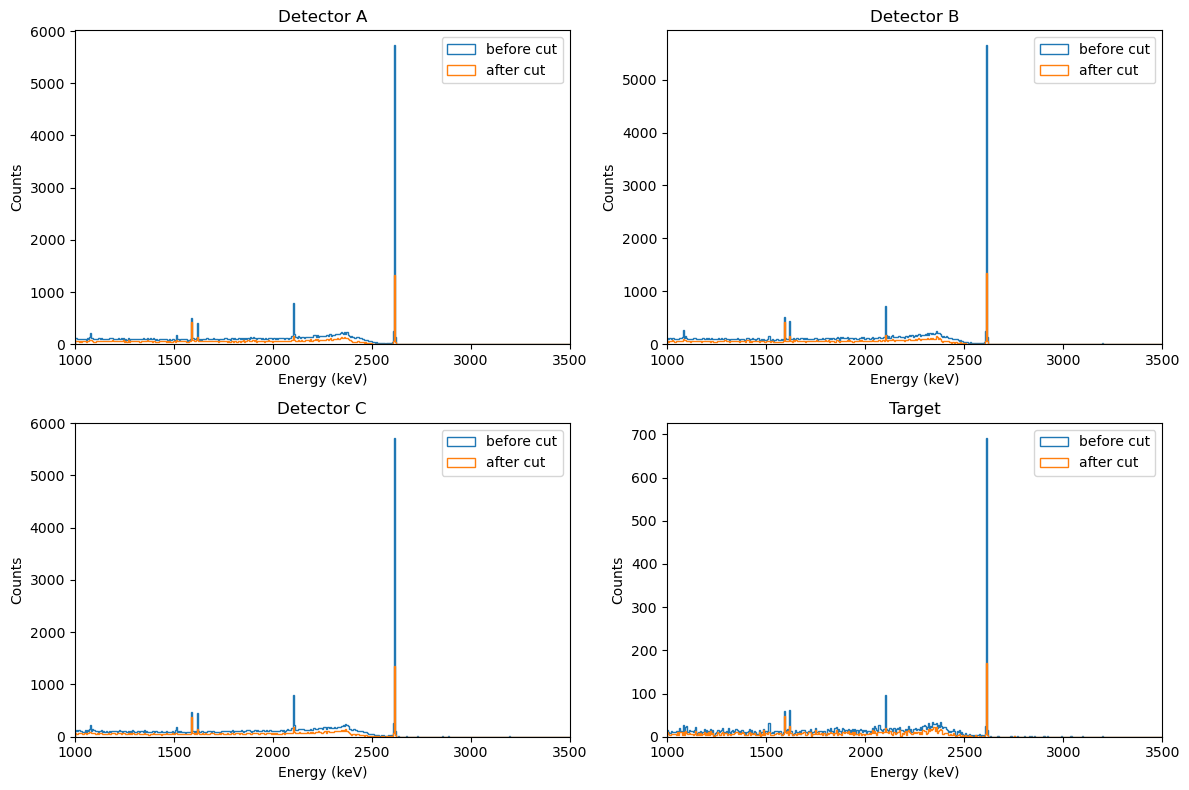

In [26]:
y_, pA_, pB_, pC_, A2, B2, C2, T2 = build_templates_for_thr(A, B, C, T, best_thr, edges, return_cut_dfs=True)

plot_before_after_grid(
    dfs_before=[A, B, C, T],
    dfs_after=[A2, B2, C2, T2],
    labels=["Detector A", "Detector B", "Detector C", "Target"],
    bins=450,
    xlim=(1000, 3500)
)
